# PRÁCTICA DE APA

Ivan Cobos Navarro


## Elección del dataset
**Descripcion** :  

    Hemos escogido el dataset statlog_german_credit_data de fetch_ucirepo.  
    Este dataset consiste de 20 variables mixtas numericas y categóricas.  
    El problema es de clasificación binaria en el que se tiene que intentar predecir si hay que ceder el crédito o no segun las diferentes carácterísticas del prestario.

In [37]:

#install libraries

#!pip3 install matplotlib  --upgrade --quiet
#!pip3 install seaborn  --upgrade --quiet
#!pip3 install scikit-learn --upgrade --quiet
#!pip3 install pandas --upgrade --quiet
#!pip3 install numpy  --upgrade --quiet
#!pip install ucimlrepo --upgrade --quiet
#!pip install missingno --upgrade --quiet
#pip install ucimlrepo --upgrade --quiet
#!pip install category-encoders --upgrade --quiet


In [38]:
# Importing the libraries and global variables
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,  
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score




#random seed para reproducibilidad
random = 0

In [39]:
# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

## Visualizacion de los datos antes del Preprocesado

Unimos los features y los targets en un único dataset y cambiamos los nombres a las variables y a los posibles valores de las variables categóricas para una mejor visualización.

In [40]:
# Cargar dataset
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# Combinar características y objetivo en un solo DataFrame
df = pd.concat([X, y], axis=1)

# Obtener el DataFrame de variables
variables_df = statlog_german_credit_data.variables

# Filtrar variables_df para excluir 'class'
variables_to_rename = variables_df[variables_df['name'] != 'class']

# Reemplazar espacios por guiones bajos en las descripciones
variables_to_rename['description_underscore'] = variables_to_rename['description'].str.replace(' ', '_')

# Crear un diccionario que mapee 'name' a 'description_underscore', excluyendo 'class'
name_to_description = dict(zip(variables_to_rename['name'], variables_to_rename['description_underscore']))

# Renombrar las columnas del DataFrame, excluyendo 'class'
df = df.rename(columns=name_to_description)

# Ahora puedes utilizar las listas de variables actualizadas
numerical_cols_original = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
categorical_cols_original = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10',
                             'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']

# Actualizar las listas con los nuevos nombres
numerical_cols = [name_to_description.get(col, col) for col in numerical_cols_original]
categorical_cols = [name_to_description.get(col, col) for col in categorical_cols_original]

#Se hace para que sea legible los valores de las variables categóricas
mapping_attribute1 = {
    'A11': '... < 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '... >= 200 DM',
    'A14': 'no checking account'
}
mapping_attribute3 = {
    'A30': 'no credits taken/ all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account/ other credits existing (not at this bank)'
}
mapping_attribute4 = {
    'A40': 'car (new)',
    'A41': 'car (used)',
    'A42': 'furniture/equipment',
    'A43': 'radio/television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}
mapping_attribute6 = {
    'A61': '... < 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '... >= 1000 DM',
    'A65': 'unknown/ no savings account'
}
mapping_attribute7 = {
    'A71': 'unemployed',
    'A72': '... < 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '... >= 7 years'
}
mapping_attribute9 = {
    'A91': 'male: divorced/separated',
    'A92': 'female: divorced/separated/married',
    'A93': 'male: single',
    'A94': 'male: married/widowed',
    'A95': 'female: single'
}
mapping_attribute10 = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}
mapping_attribute12 = {
    'A121': 'real estate',
    'A122': 'building society savings/life insurance',
    'A123': 'car or other',
    'A124': 'unknown / no property'
}
mapping_attribute14 = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}
mapping_attribute15 = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}
mapping_attribute17 = {
    'A171': 'unemployed/ unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee / official',
    'A174': 'management/ self-employed/ highly qualified'
}
mapping_attribute19 = {
    'A191': 'none',
    'A192': 'yes, registered under the customer\'s name'
}
mapping_attribute20 = {
    'A201': 'yes',
    'A202': 'no'
}
# Aplicar los mapeos de las variables categoricas al DataFrame para que sea más legible
df['Status_of_existing_checking_account'] = df['Status_of_existing_checking_account'].map(mapping_attribute1)
df['Credit_history'] = df['Credit_history'].map(mapping_attribute3)
df['Purpose'] = df['Purpose'].map(mapping_attribute4)
df['Savings_account/bonds'] = df['Savings_account/bonds'].map(mapping_attribute6)
df['Present_employment_since'] = df['Present_employment_since'].map(mapping_attribute7)
df['Personal_status_and_sex'] = df['Personal_status_and_sex'].map(mapping_attribute9)
df['Other_debtors_/_guarantors'] = df['Other_debtors_/_guarantors'].map(mapping_attribute10)
df['Property'] = df['Property'].map(mapping_attribute12)
df['Other_installment_plans'] = df['Other_installment_plans'].map(mapping_attribute14)
df['Housing'] = df['Housing'].map(mapping_attribute15)
df['Job'] = df['Job'].map(mapping_attribute17)
df['Telephone'] = df['Telephone'].map(mapping_attribute19)
df['foreign_worker'] = df['foreign_worker'].map(mapping_attribute20)

"""
df tiene los valores de las variables categóricas reemplazados por cadenas de texto más descriptivas.
y los nombres de las columnas se han actualizado para que sean más legibles.
"""

num_filas = df.shape[0]

print(f"El número de instancias (filas) es: {num_filas}")

print(f"\nLas primeras 5 filas del DataFrame son: {df.head()}")



El número de instancias (filas) es: 1000

Las primeras 5 filas del DataFrame son:   Status_of_existing_checking_account  Duration  \
0                          ... < 0 DM         6   
1                   0 <= ... < 200 DM        48   
2                 no checking account        12   
3                          ... < 0 DM        42   
4                          ... < 0 DM        24   

                                      Credit_history              Purpose  \
0  critical account/ other credits existing (not ...     radio/television   
1           existing credits paid back duly till now     radio/television   
2  critical account/ other credits existing (not ...            education   
3           existing credits paid back duly till now  furniture/equipment   
4                    delay in paying off in the past            car (new)   

   Credit_amount        Savings_account/bonds Present_employment_since  \
0           1169  unknown/ no savings account           ... >= 7 years   


C:\Users\Guille\AppData\Local\Temp\ipykernel_14364\4129261621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_to_rename['description_underscore'] = variables_to_rename['description'].str.replace(' ', '_')


In [41]:
def visualize_numerical(df, numerical_cols=None):
    """
    Visualiza variables numéricas mediante histogramas y diagramas de caja.

    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - numerical_cols: Lista de nombres de columnas numéricas. Si es None, se detectan automáticamente.
    """
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    for col in numerical_cols:
        plt.figure(figsize=(8, 4))

        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')

        # Diagrama de caja
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'{col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

def visualize_categorical(df, categorical_cols):
    """
    Visualiza variables categóricas mediante gráficos de barras.
    """

    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        order = df[col].value_counts().index  # Ordenar por frecuencia

        # Obtener una paleta de colores con tantos colores como categorías
        palette = sns.color_palette('viridis', n_colors=len(order))

        # Crear el gráfico sin especificar 'palette' ni 'hue'
        ax = sns.countplot(x=col, data=df, order=order)

        # Asignar los colores manualmente a cada barra
        for i, patch in enumerate(ax.patches):
            patch.set_facecolor(palette[i % len(palette)])

        plt.title(f'Conteo de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



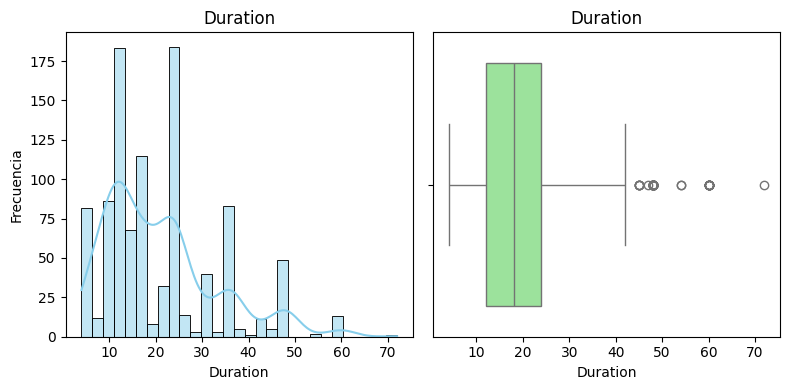

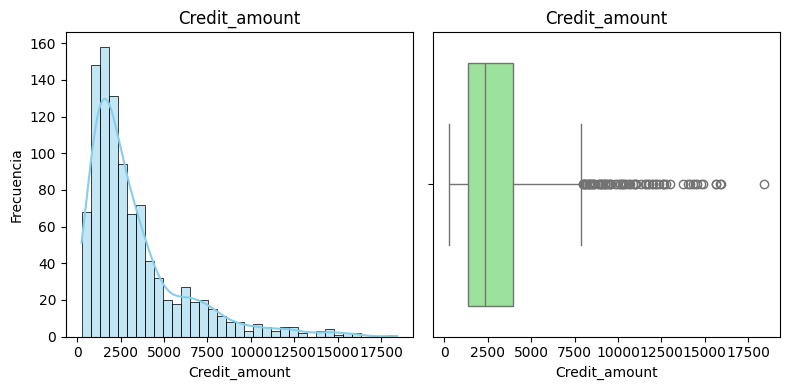

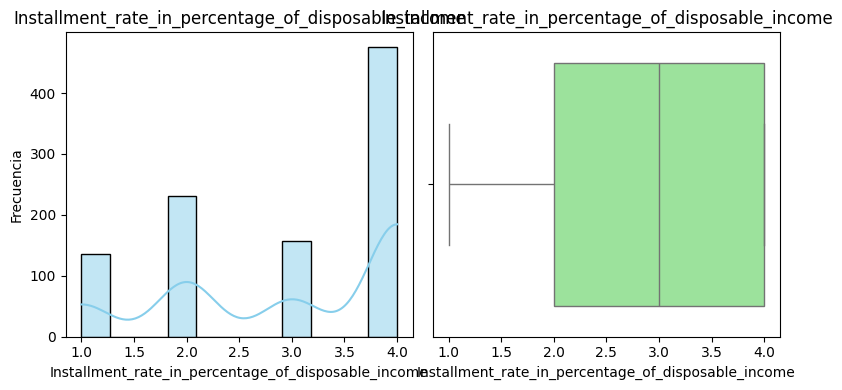

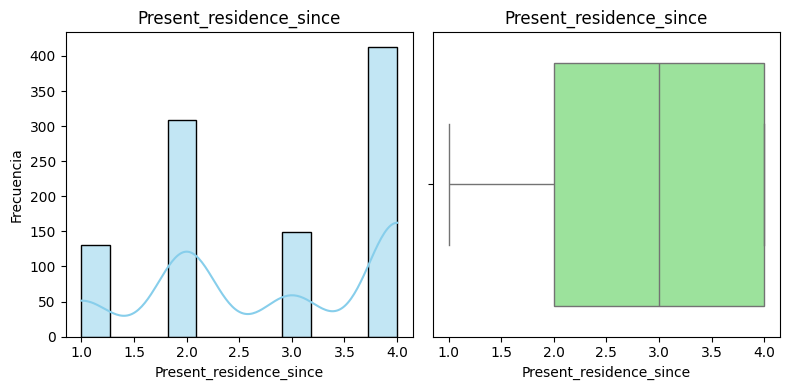

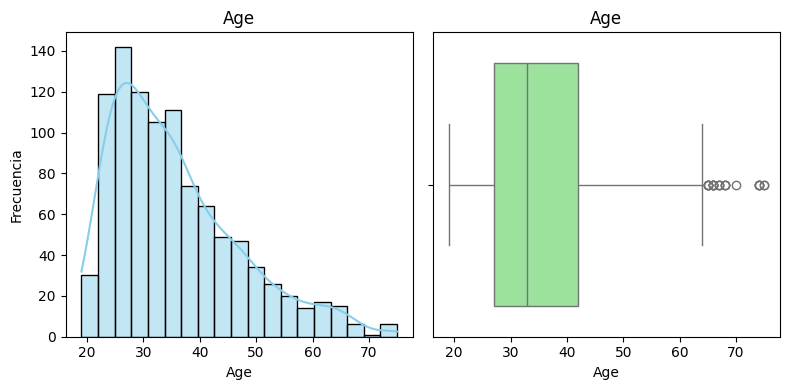

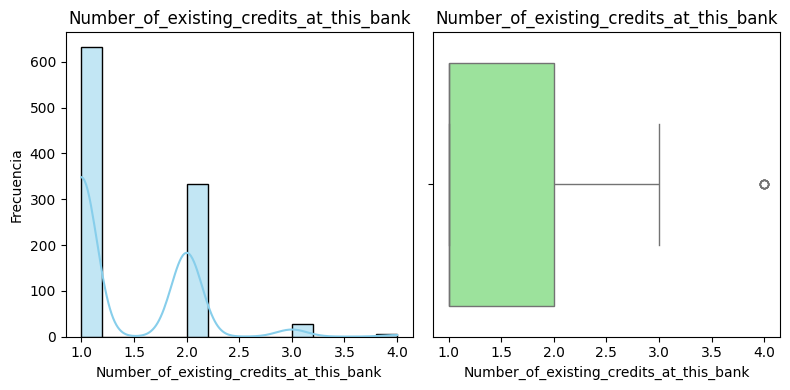

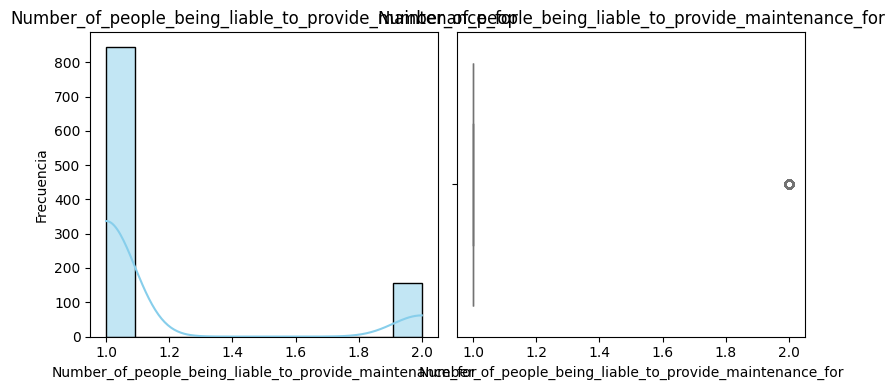

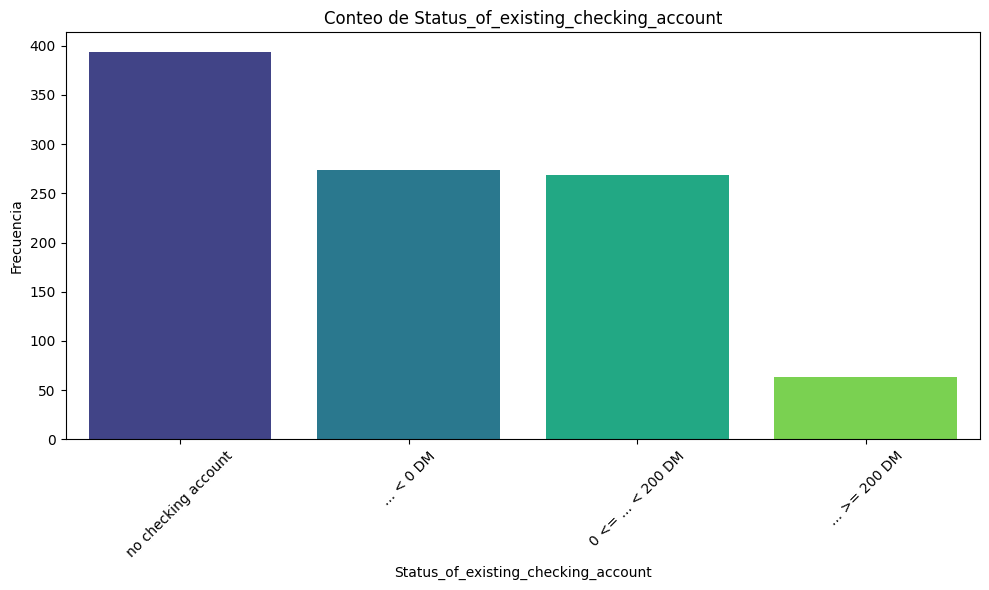

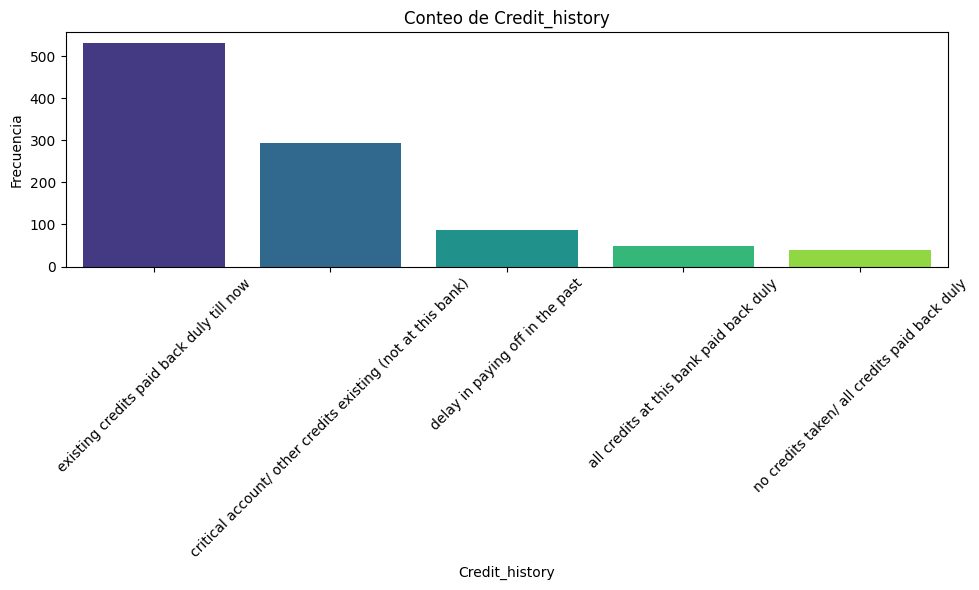

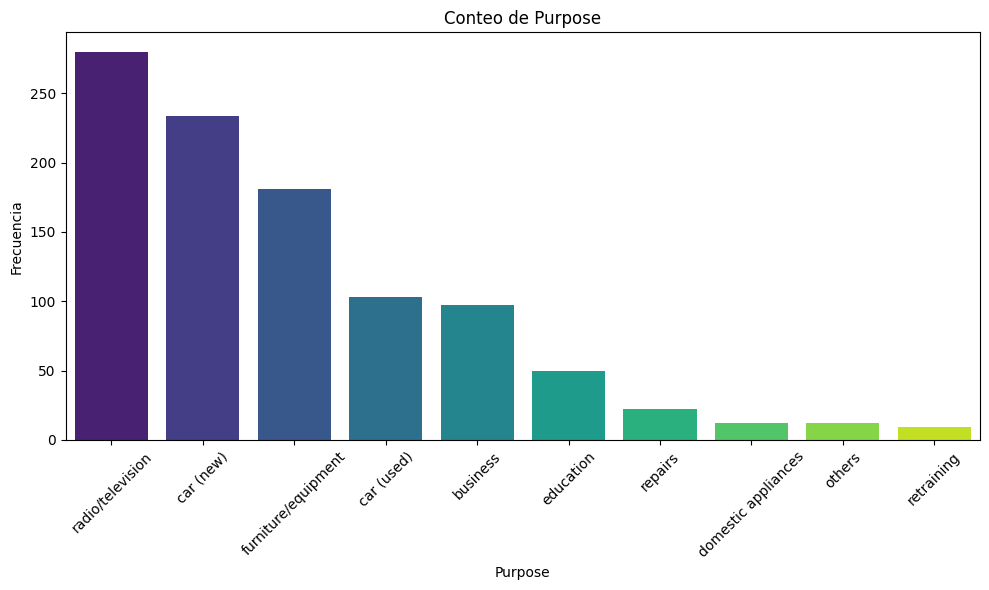

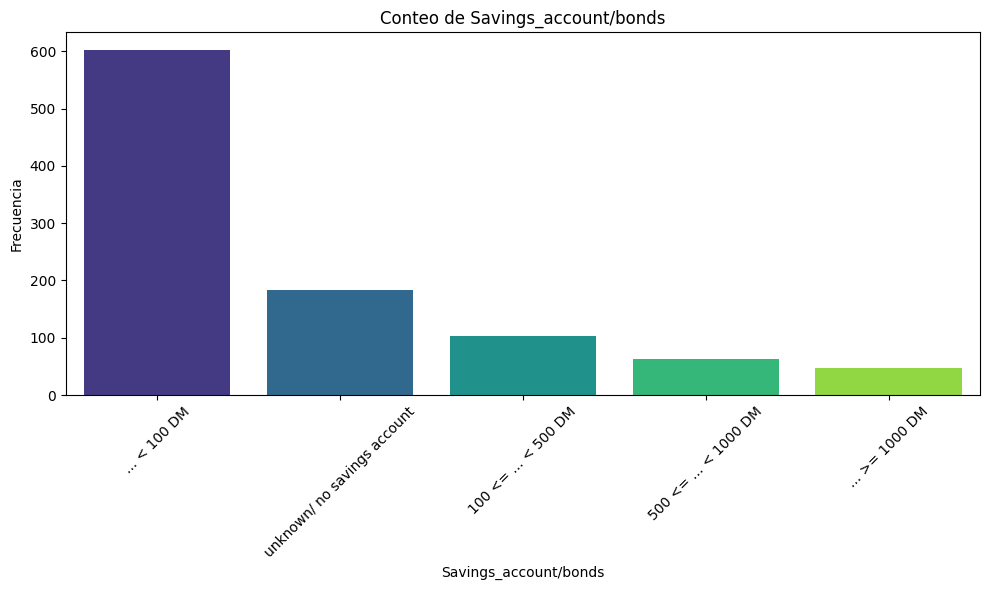

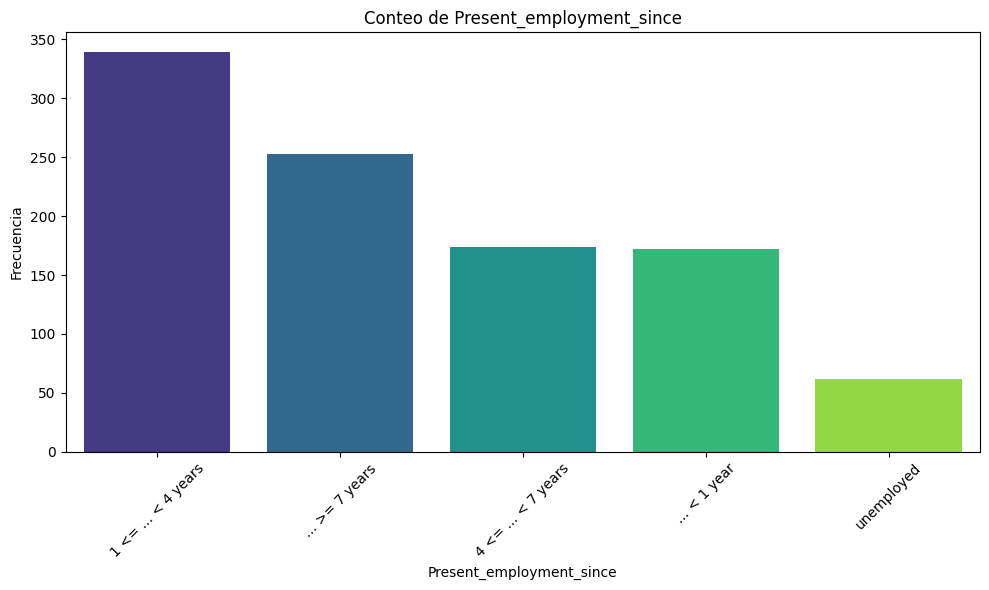

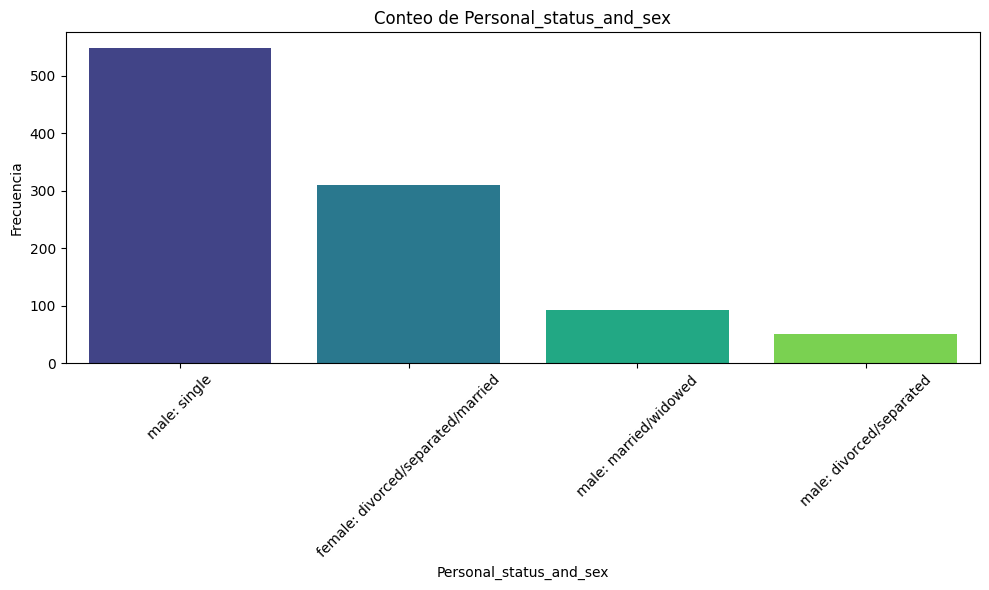

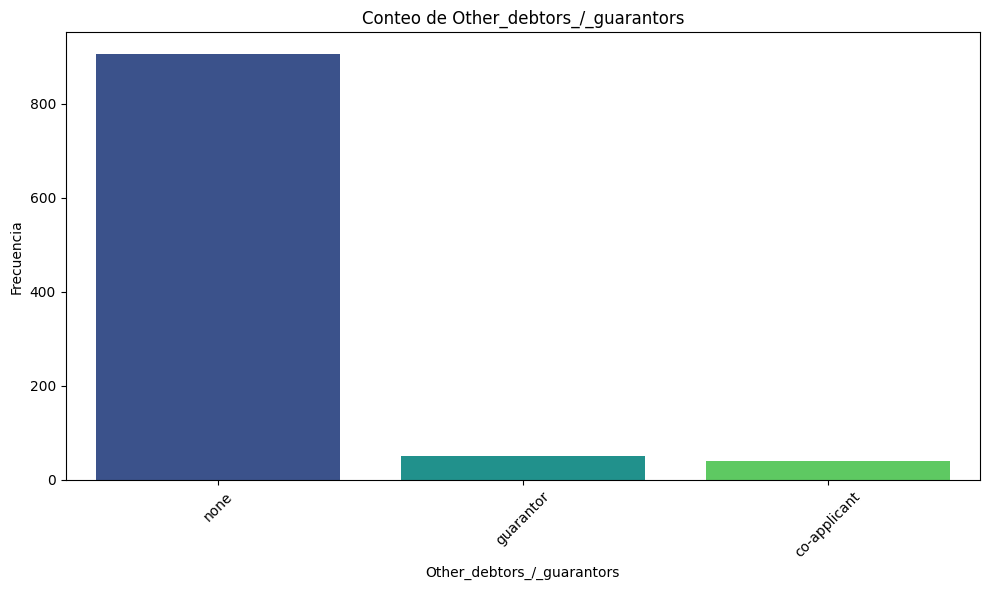

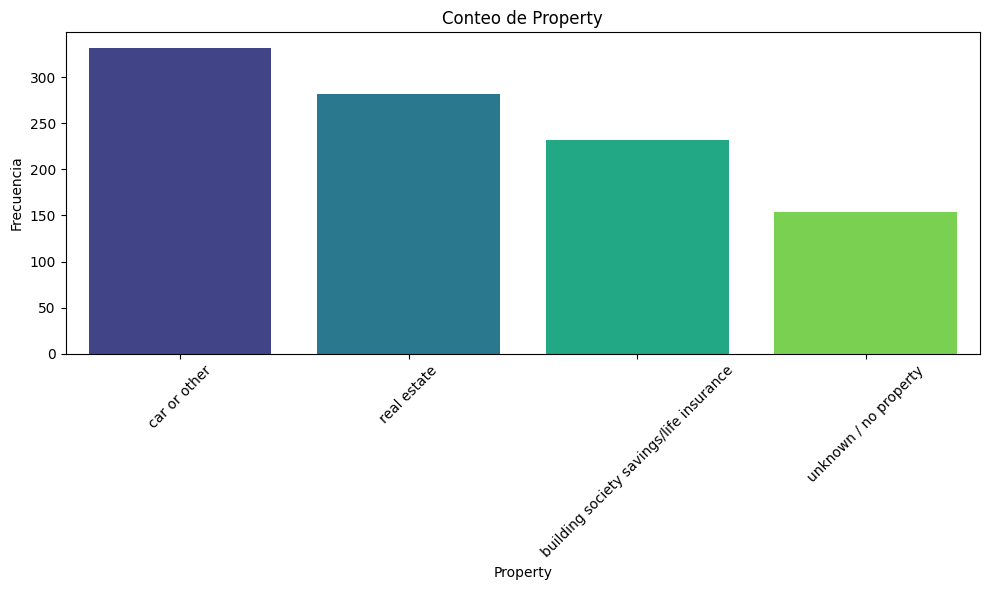

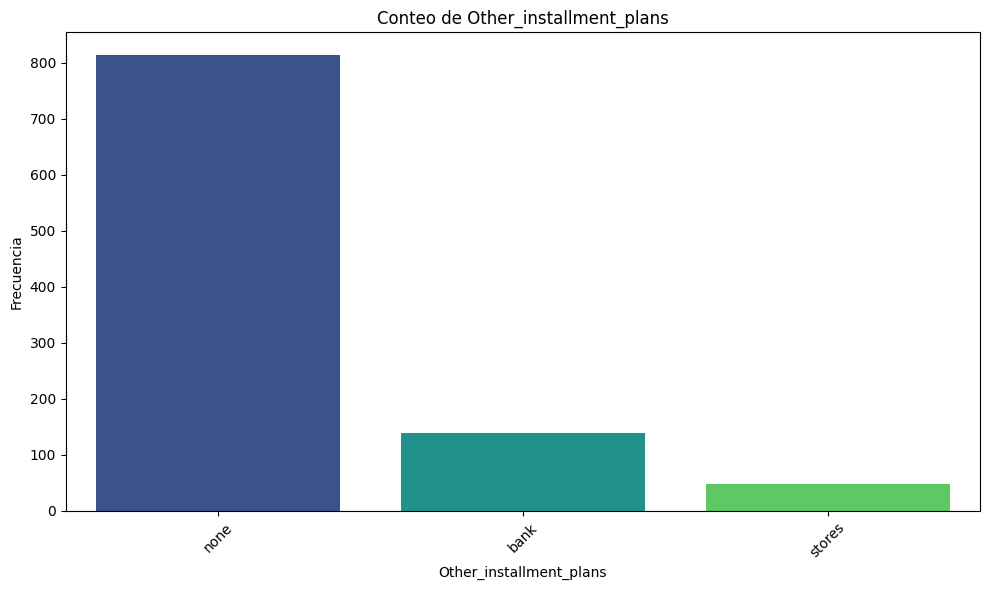

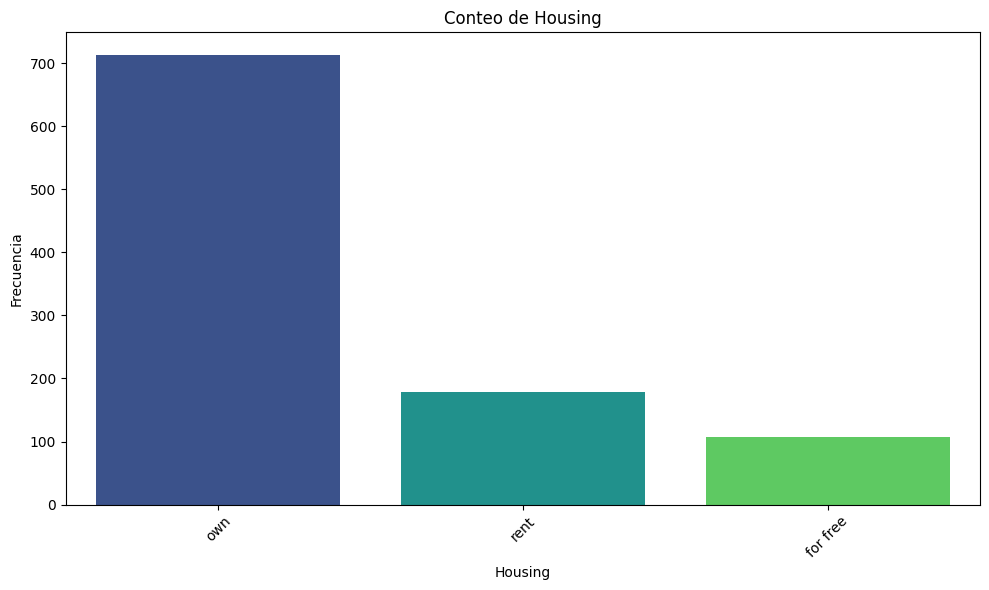

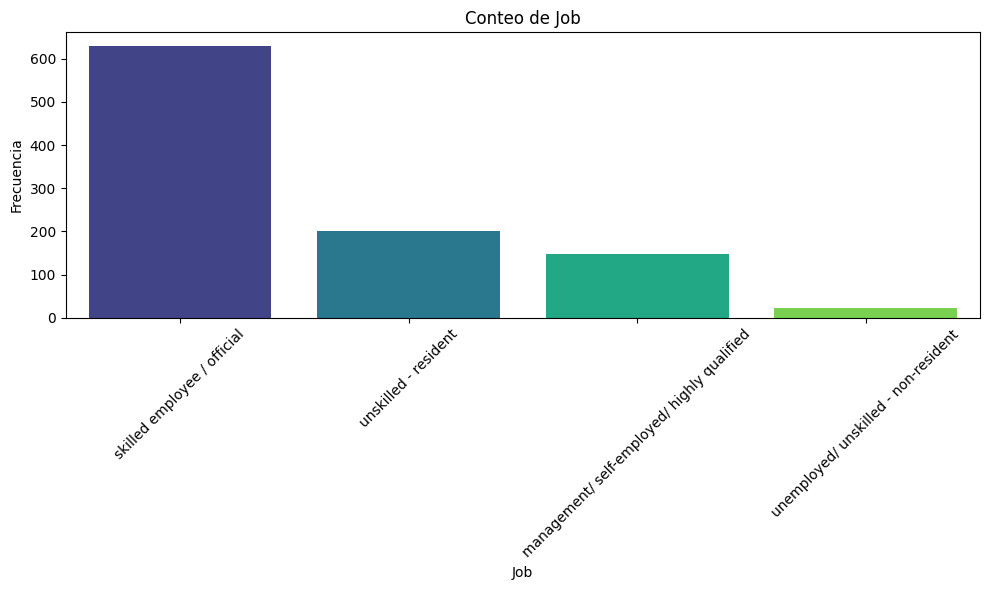

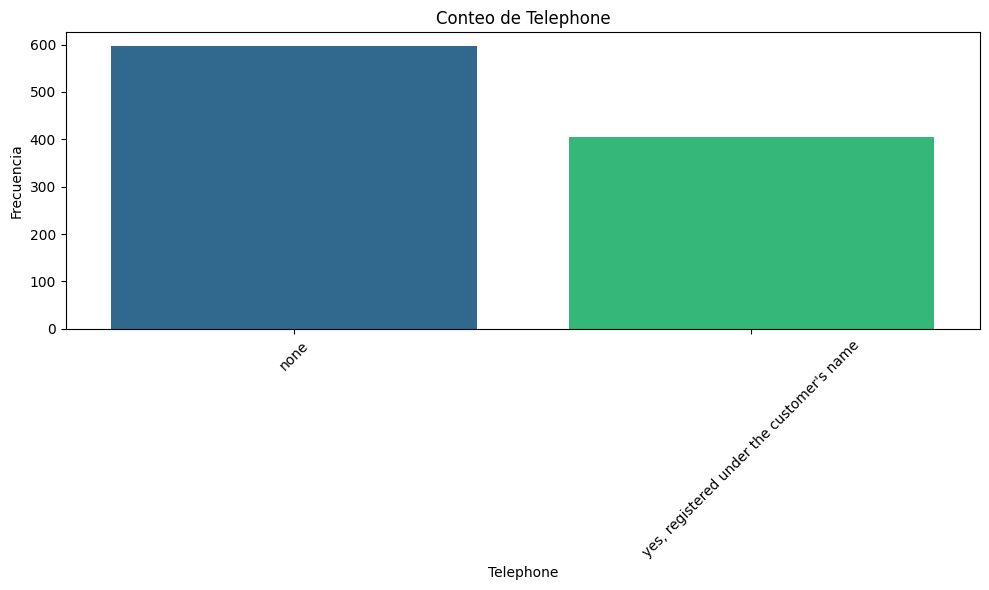

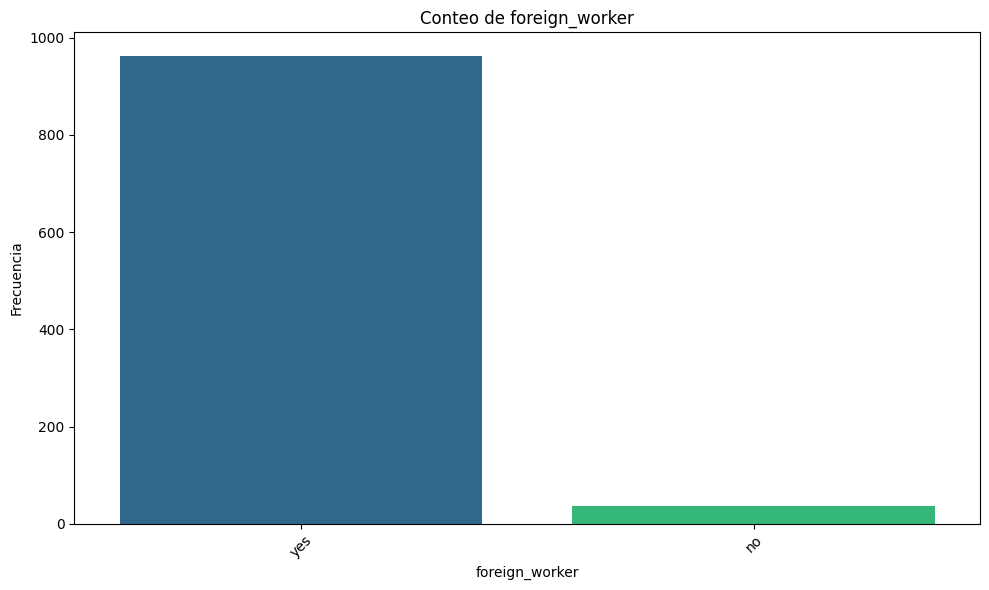

In [42]:
visualize_numerical(df, numerical_cols)
visualize_categorical(df, categorical_cols)

Al analizar la visualización de las variables numéricas, podemos confirmar que no se encuentran valores perdidos en el conjunto de datos, lo cual facilita el análisis y garantiza que todas las observaciones están completas. Observamos que las variables numéricas siguen tienen un problema, los outliers, cosa que deberemos considerar más adelante en el preproceso. 

Al examinar los histogramas de algunas variables, observamos que no siguen una distribución normal, lo cual es esperado dada la naturaleza de estas características. Por ejemplo, variables como el número de créditos existentes en el banco no presentan una curva simétrica, ya que se espera que esta variable esté concentrada en ciertos valores debido a las prácticas de crédito estándar. Esta falta de normalidad es común en datos financieros y no representa necesariamente un problema para el análisis.

En la visualización de las variables categóricas, observamos una distribución balanceada y desequilibrada en diferentes variables, que refleja la diversidad y características de los solicitantes de crédito. Mediante un tratamiento adecuado del desequilibrio en algunas categorías, podemos mejorar la capacidad del modelo para capturar patrones significativos y asegurar que aprenda de manera equilibrada y representativa de todo el conjunto de datos.

['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank', 'Number_of_people_being_liable_to_provide_maintenance_for']


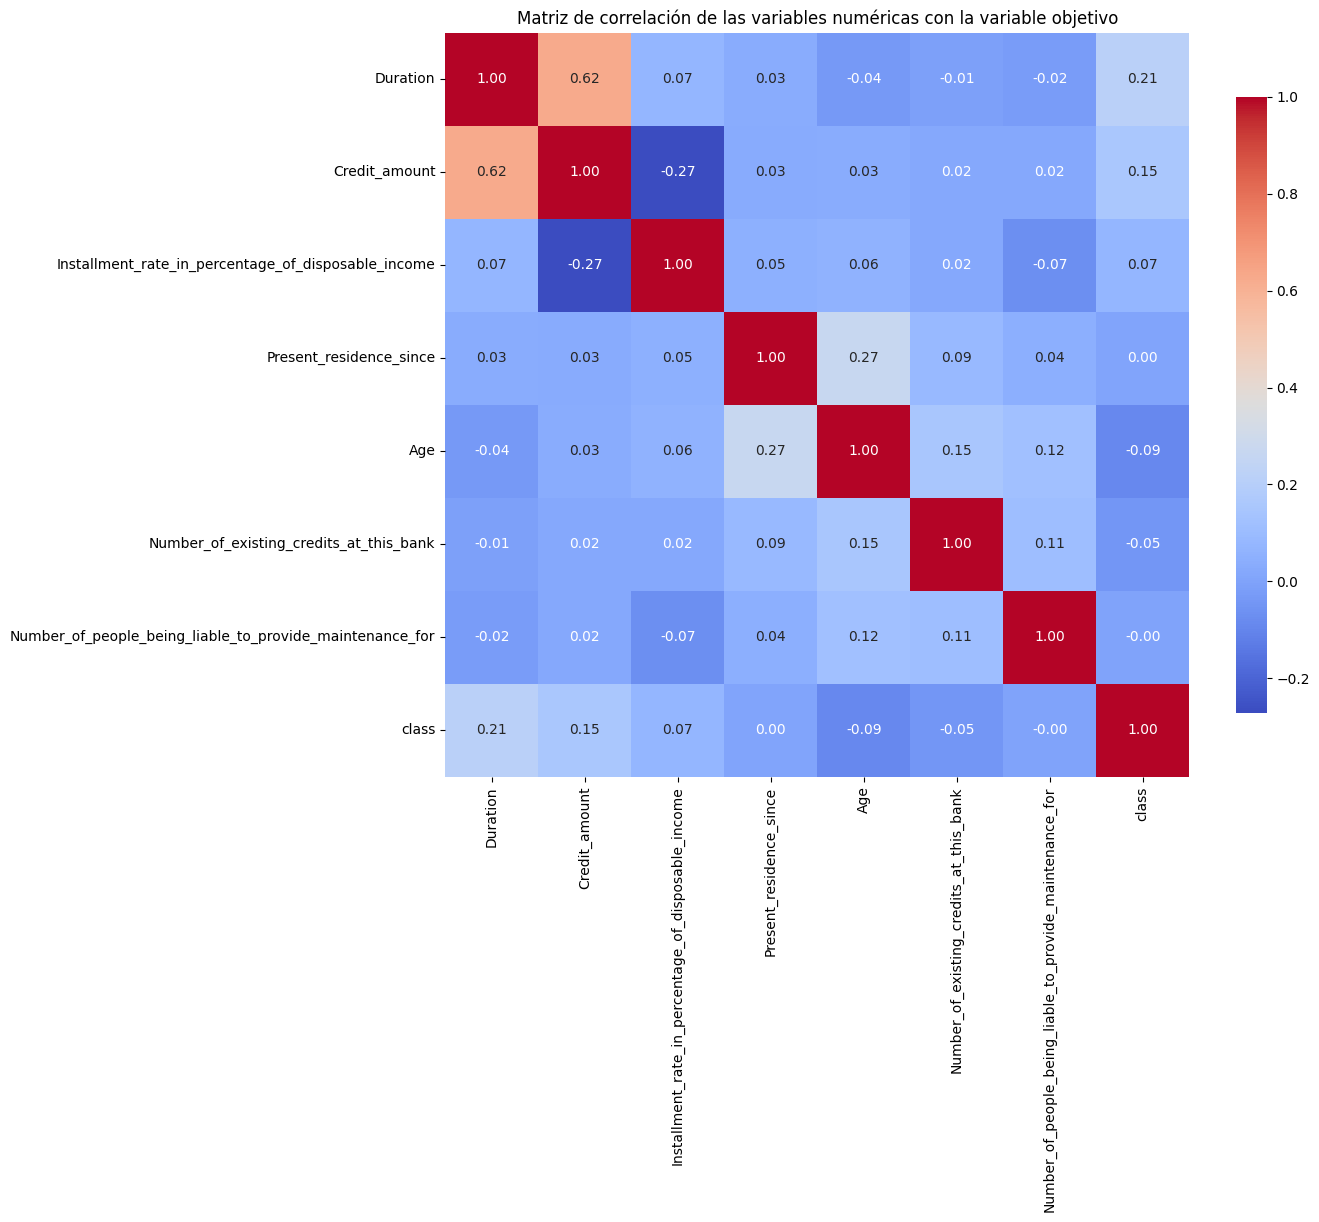

In [43]:

numerical_cols_with_target = numerical_cols + ['class']

print(numerical_cols)

corr_matrix_with_target = df[numerical_cols_with_target].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_with_target, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de correlación de las variables numéricas con la variable objetivo')
plt.show()


Al observar la matriz de correlación de las variables numéricas, notamos que la mayoría de los coeficientes de correlación se encuentran muy cerca de 0. Esto sugiere que, en general, las variables numéricas del conjunto de datos no presentan relaciones lineales fuertes entre sí. Este bajo grado de correlación implica que cada variable aporta información relativamente independiente, lo cual puede ser beneficioso para el modelo, ya que no se corre el riesgo de redundancia o multicolinealidad significativa entre las variables numéricas.

Sin embargo, hay una excepción: encontramos una correlación de aproximadamente 0.62 entre las variables Duration y Credit Amount. Una correlación positiva en este caso tendría sentido: a medida que aumenta la cantidad solicitada, es probable que también se extienda la duración del préstamo para permitir pagos más asequibles.

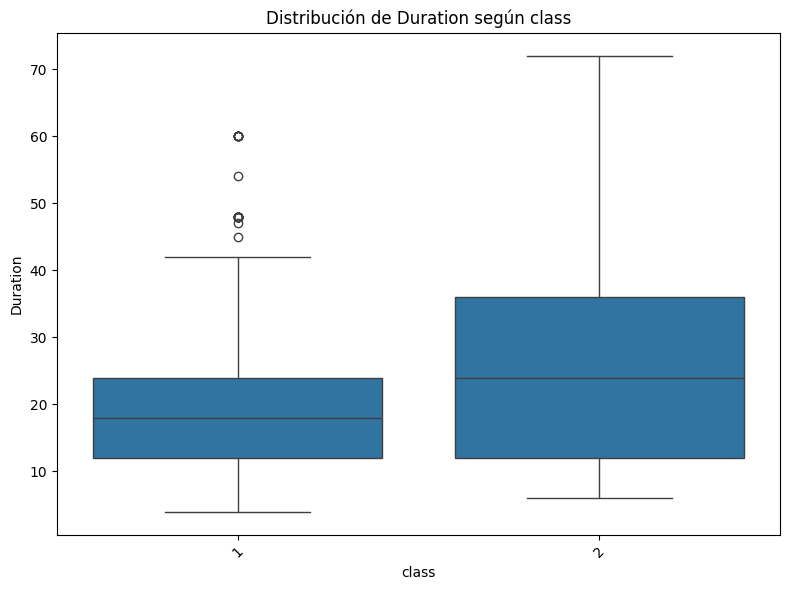

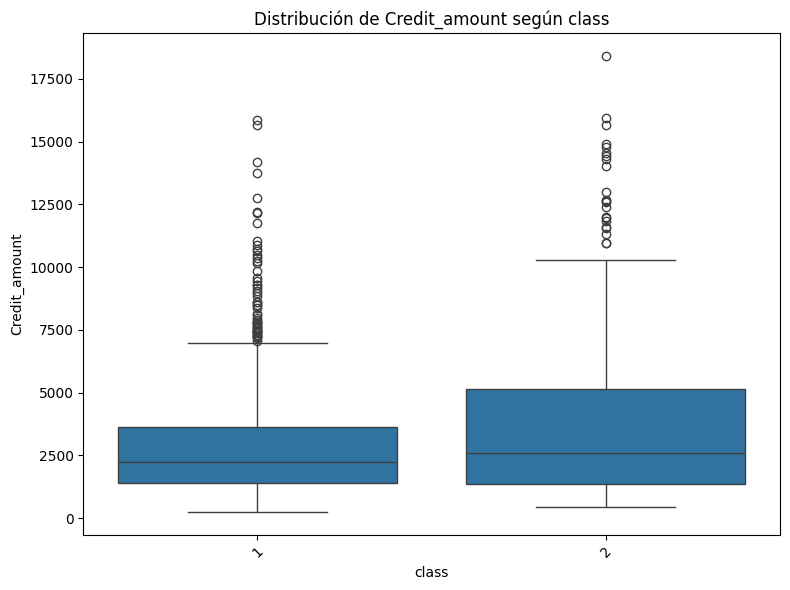

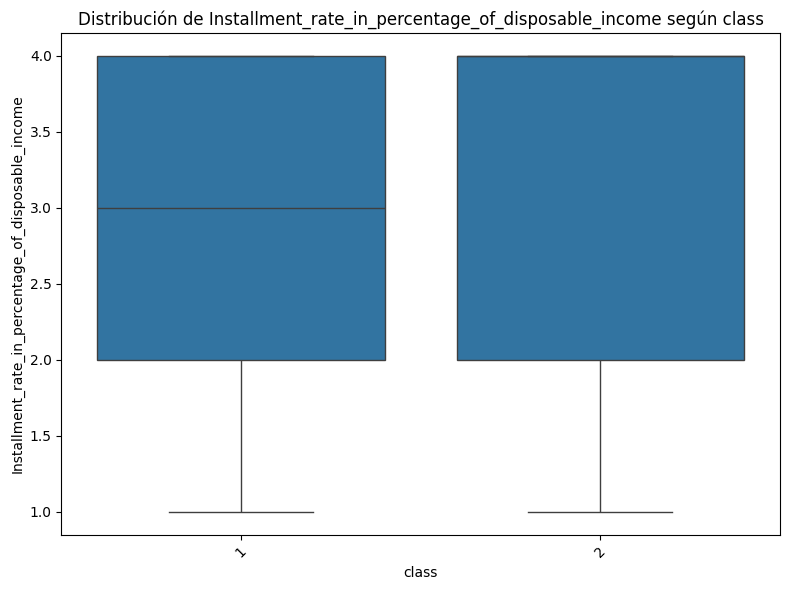

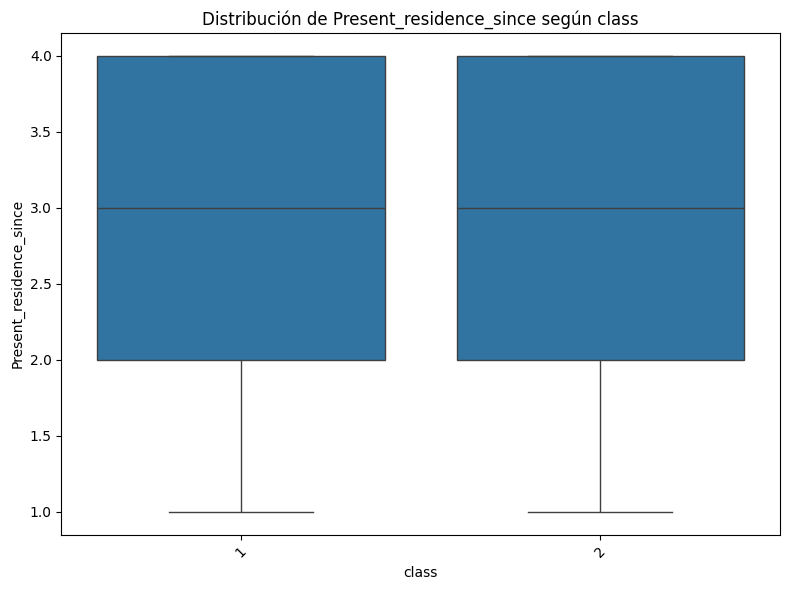

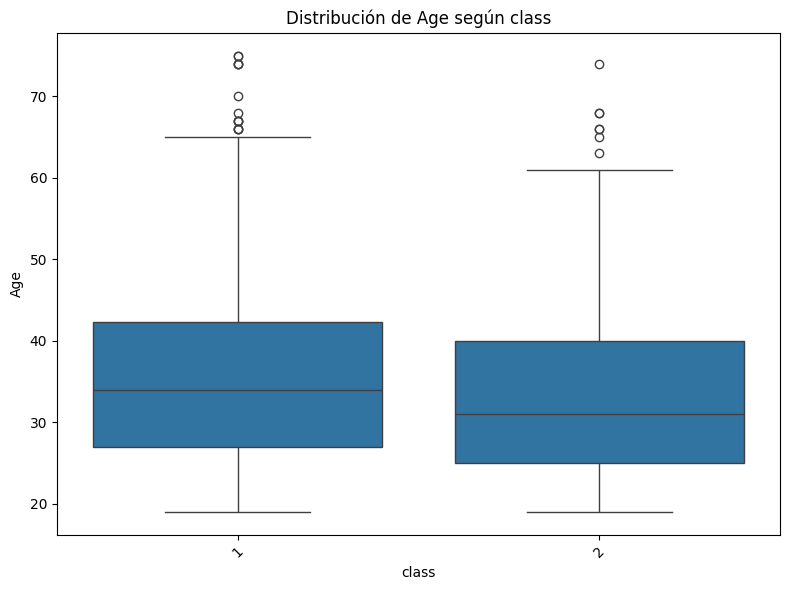

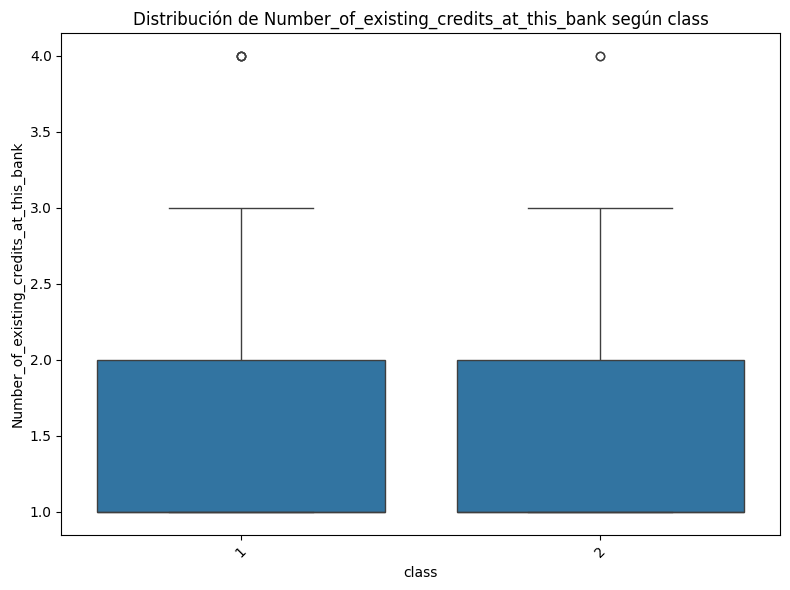

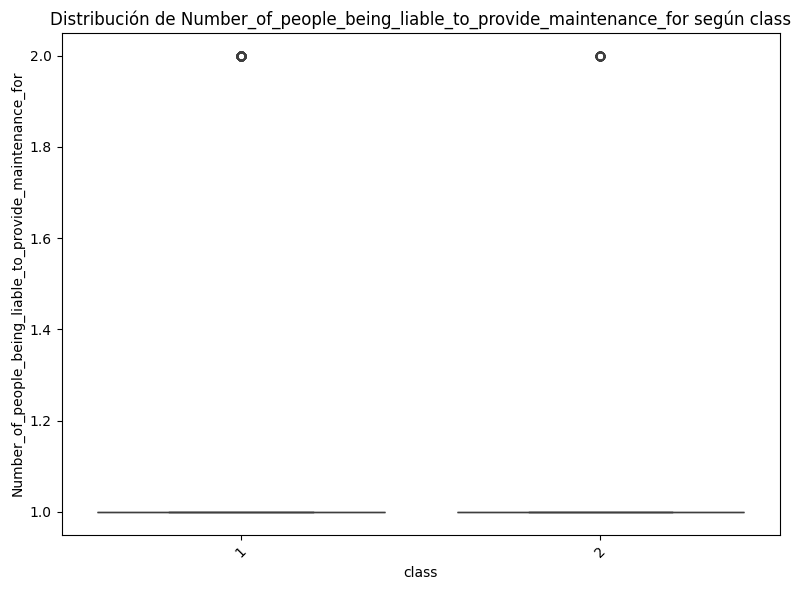

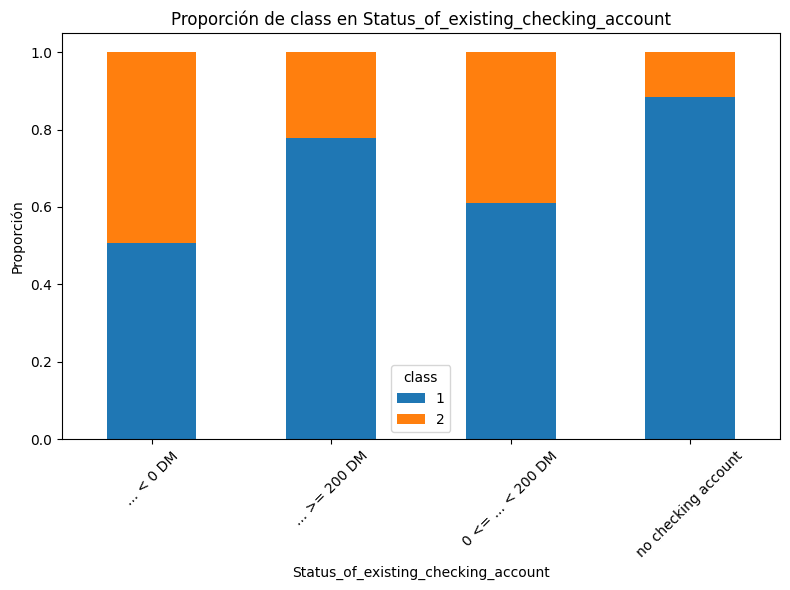

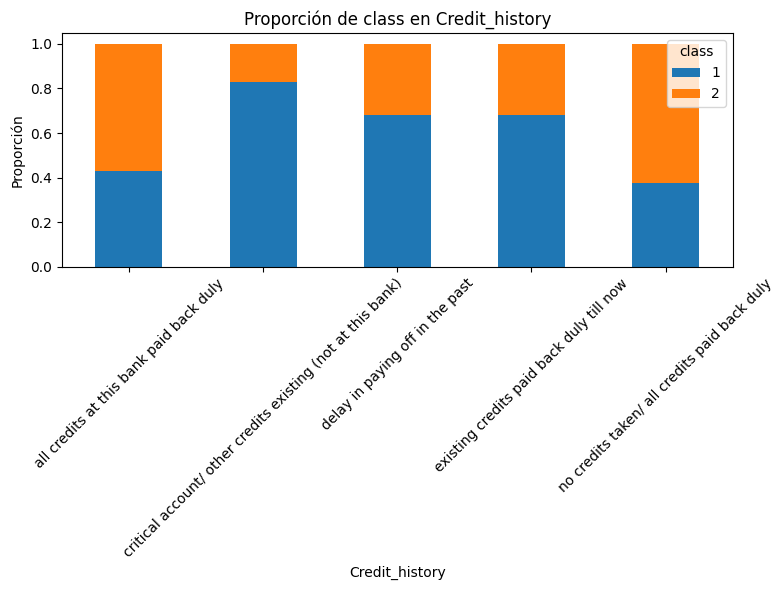

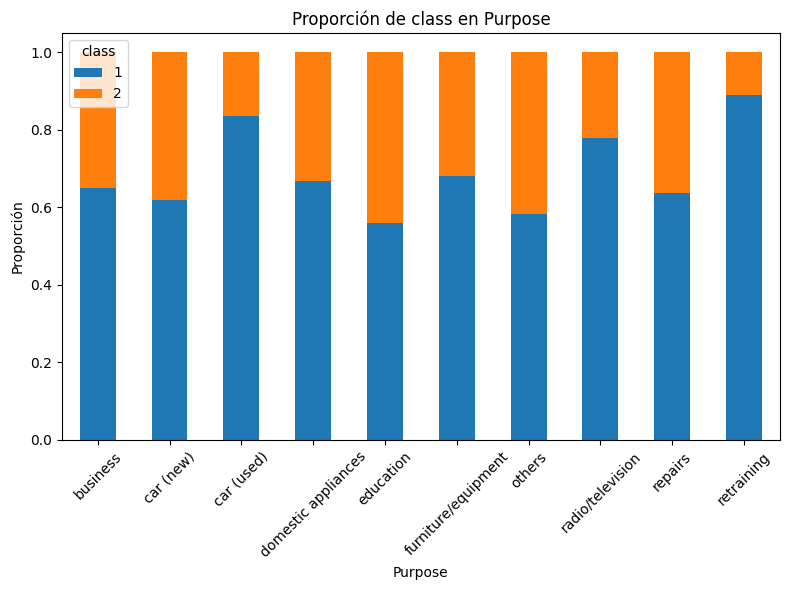

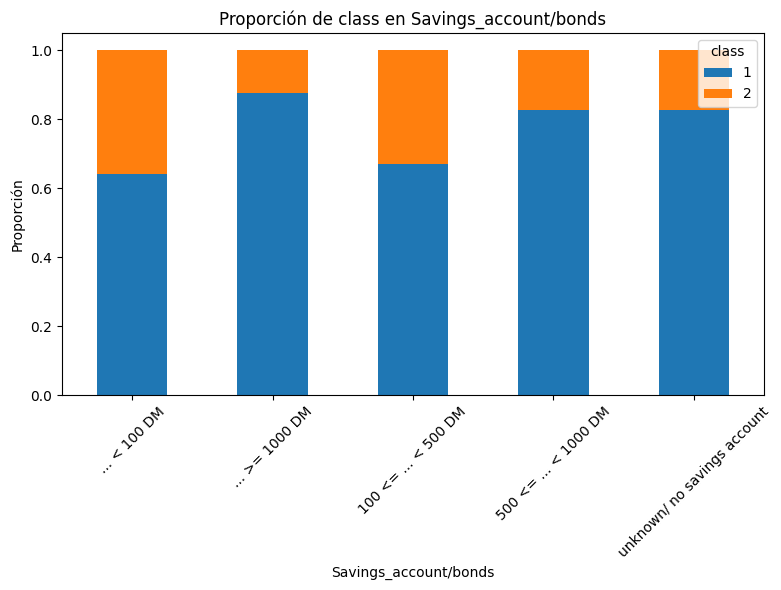

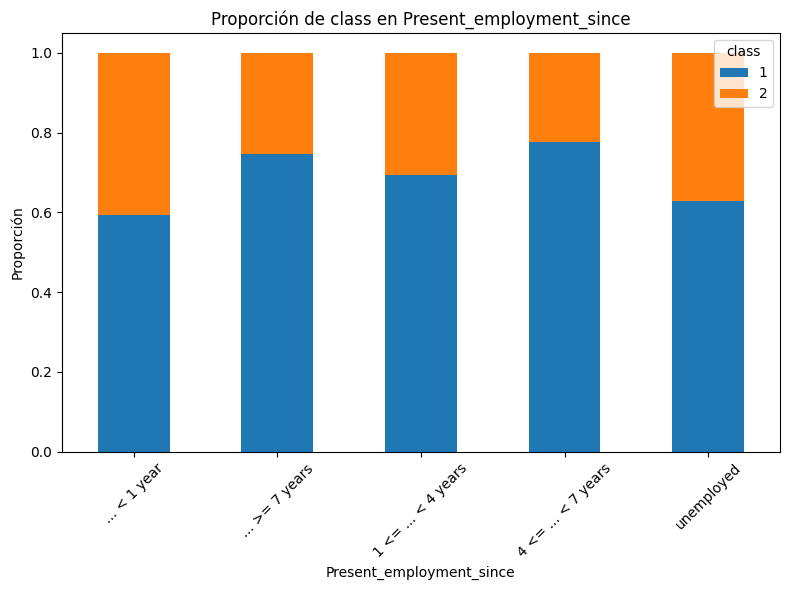

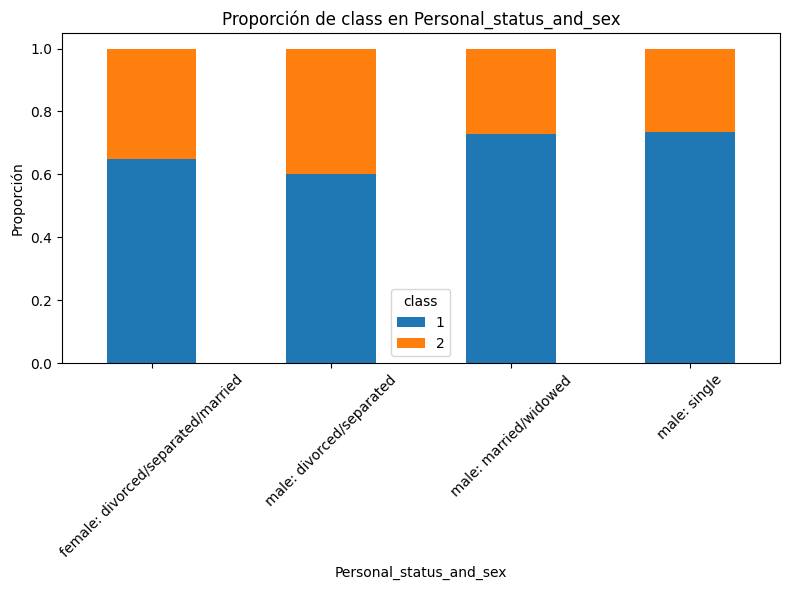

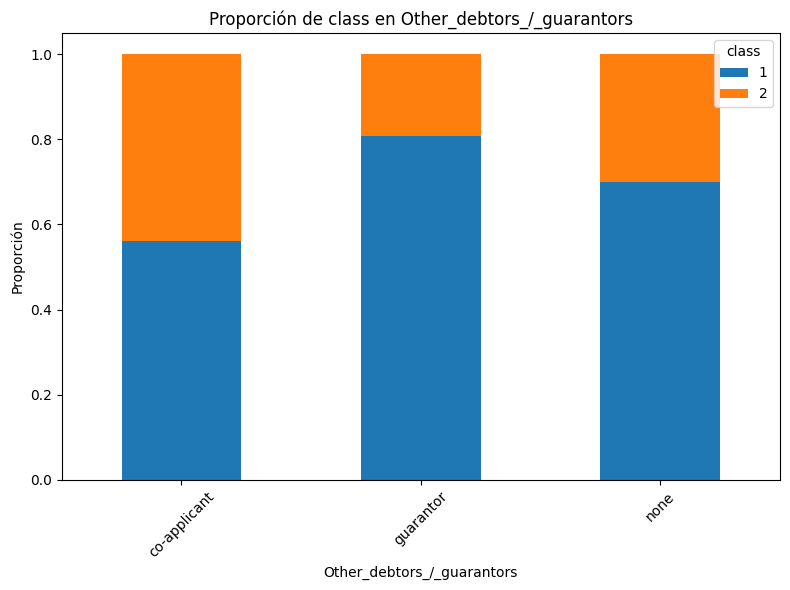

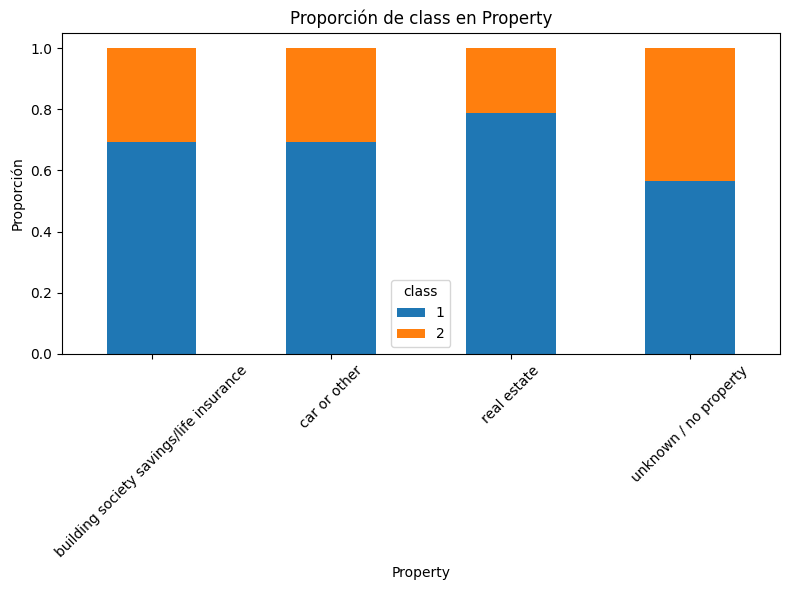

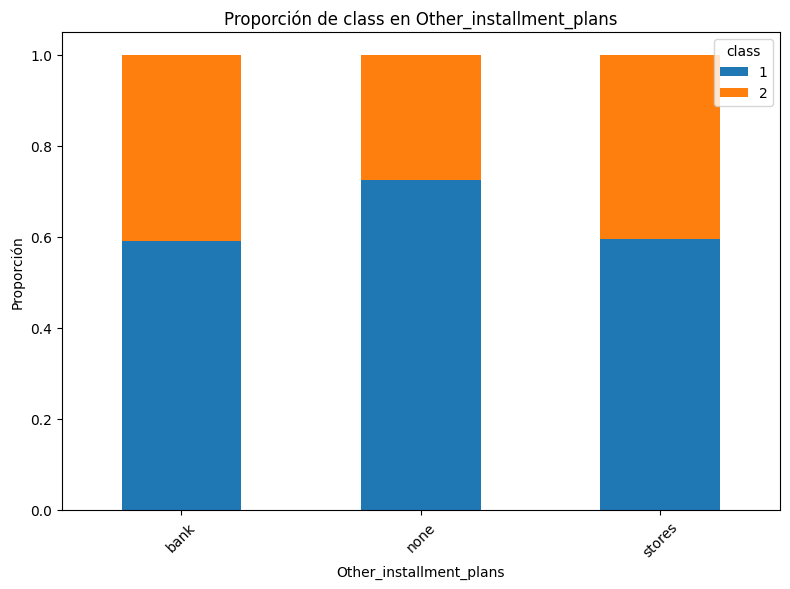

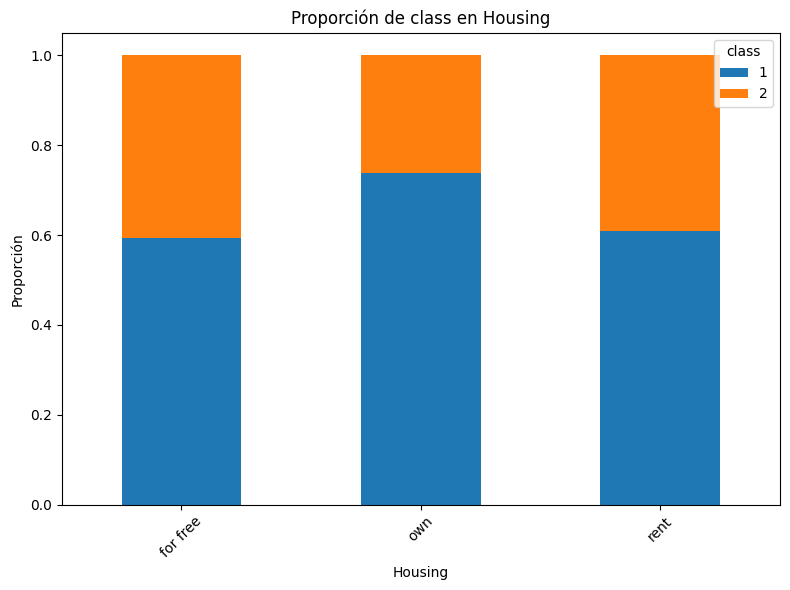

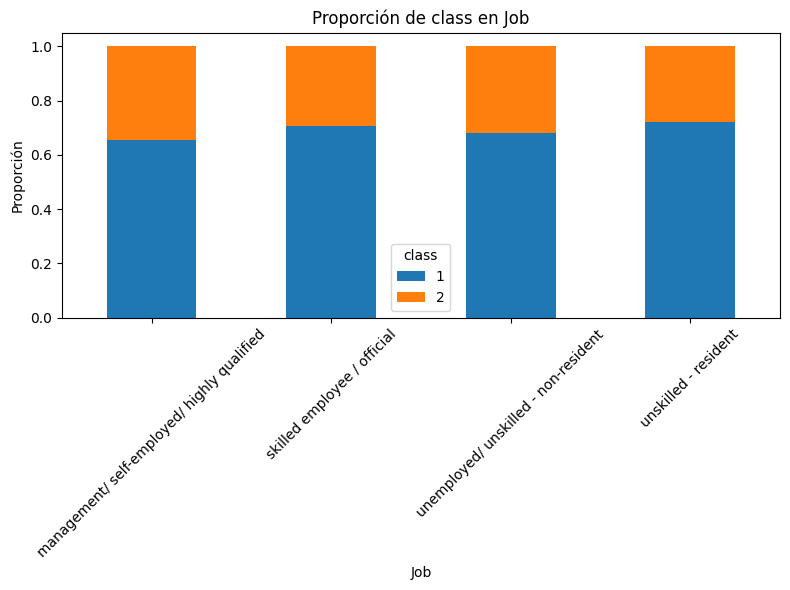

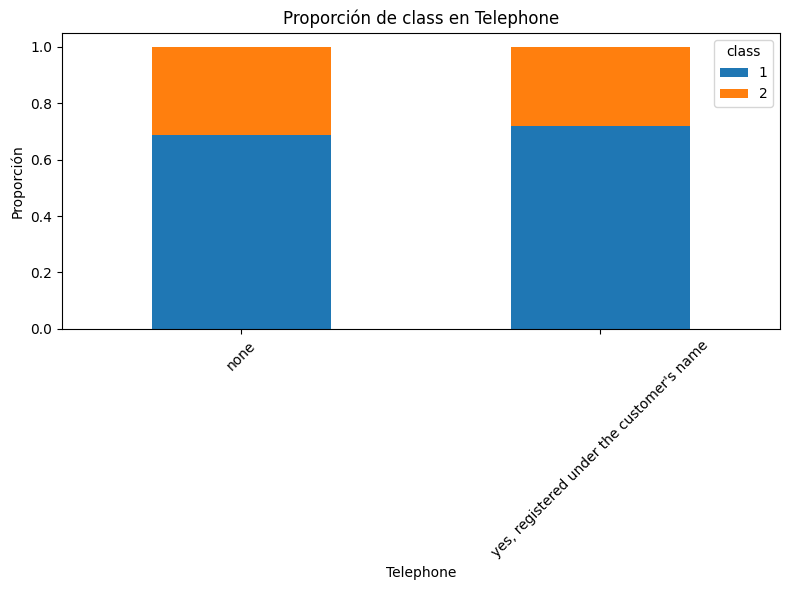

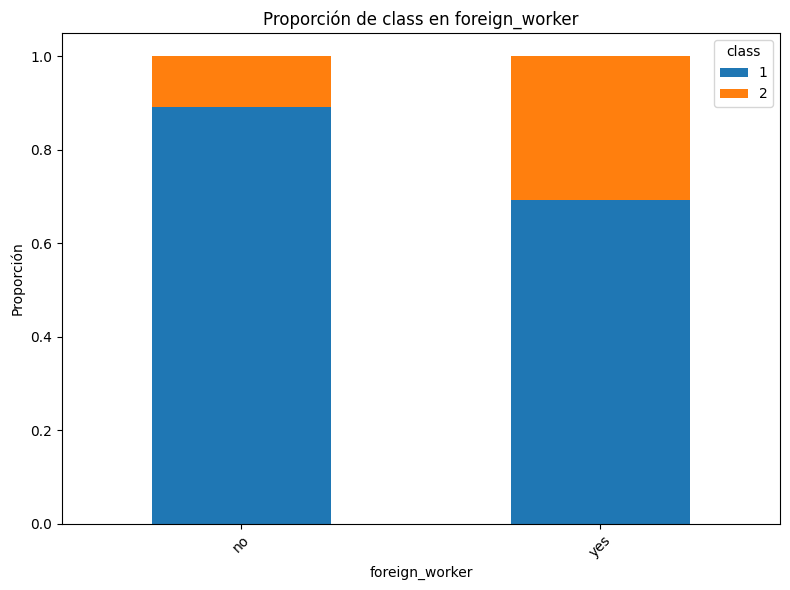

In [44]:
def visualize_categorical_vs_target_stacked(df, categorical_cols, target_col):

    figsize = (8,6)
    for col in categorical_cols:
        ct = pd.crosstab(df[col], df[target_col], normalize='index')
        ct.plot(kind='bar', stacked=True, figsize=figsize)
        plt.title(f'Proporción de {target_col} en {col}')
        plt.xlabel(col)
        plt.ylabel('Proporción')
        plt.legend(title=target_col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def visualize_numerical_vs_target(df, numerical_cols, target_col):
    """
    Visualiza la relación entre variables numéricas y la variable objetivo mediante boxplots.

    Parameters:
    - df: DataFrame que contiene los datos.
    - numerical_cols: Lista de columnas numéricas.
    - target_col: Columna objetivo.
    """
    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=target_col, y=col)
        plt.title(f'Distribución de {col} según {target_col}')
        plt.xlabel(target_col)
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

visualize_numerical_vs_target(df, numerical_cols, 'class')

#class: 1 = good , 2 = bad
visualize_categorical_vs_target_stacked(df, categorical_cols, 'class')


Estos gráficos de barras apiladas nos permiten analizar la proporción de la variable objetivo (class) dentro de cada categoría de las variables categóricas. Este tipo de gráfico apilado muestra, para cada categoría, la distribución proporcional de las clases (en este caso, "Good" y "Bad"), permitiendo observar si alguna categoría está más asociada a una de las clases.

En este caso concreto, no parece que ninguna categoría muestre una tendencia claramente dominante hacia una u otra clase de riesgo. Esto sugiere que, al menos a primera vista, ninguna de las categorías se destaca significativamente como indicador del riesgo de un préstamo.

    Estas gráficas nos muestran además que será necesario estratificar los datos cuando los vayamos a dividir en entrenamiento y test ya que podemos observar como hay más ejemplos con la clase "good" que "bad" 

## Preprocesamiento

En este apartado aplicaremos el preprocesamiento a los datos según lo que hemos observado en las gráficas y según información adicional que miraremos durante este proceso.
### Missing Values
Observemos si existen missing values:

In [45]:
df.isnull().sum()

Status_of_existing_checking_account                         0
Duration                                                    0
Credit_history                                              0
Purpose                                                     0
Credit_amount                                               0
Savings_account/bonds                                       0
Present_employment_since                                    0
Installment_rate_in_percentage_of_disposable_income         0
Personal_status_and_sex                                     0
Other_debtors_/_guarantors                                  0
Present_residence_since                                     0
Property                                                    0
Age                                                         0
Other_installment_plans                                     0
Housing                                                     0
Number_of_existing_credits_at_this_bank                     0
Job     

No existen valores perdidos.   

### Outliers 

Miremos si hay valores extremos que debamos tener en cuenta. Segun lo que hemos podido ver de los gráficos en la visualizacion inicial de los datos,
no hay valores perdidos codificados como valores extremos (podría ser que en vez de null los valores perdidos tuvieran un valor extremo para indicarse).
Por los boxplot sí que hay algunos valores que podriamos identificar como outliers pero no vamos a quitar o sustituir esas filas ya que són valores que siguen la distribución de las variables y tampoco son lo que concluiríamos como "extremos".

También cabe decir que hemos hecho pruebas quitando o sustituyendo(Winsorizing) estos outliers y los modelos entrenados són más o menos iguales o peores.


### Valores incoherentes o incorrectos

No se observan valores incoherentes ni incorrectos en ninguna variable todos los valores por cada atributo estan dentro de los rangos y distribuciones que esperaríamos

### Posible eliminación de variables irrelevantes o redundantes (selección de características)

A continuación, observamos las correlaciones entre todas las variables, para identificar posibles candidatas a ser eliminadas.

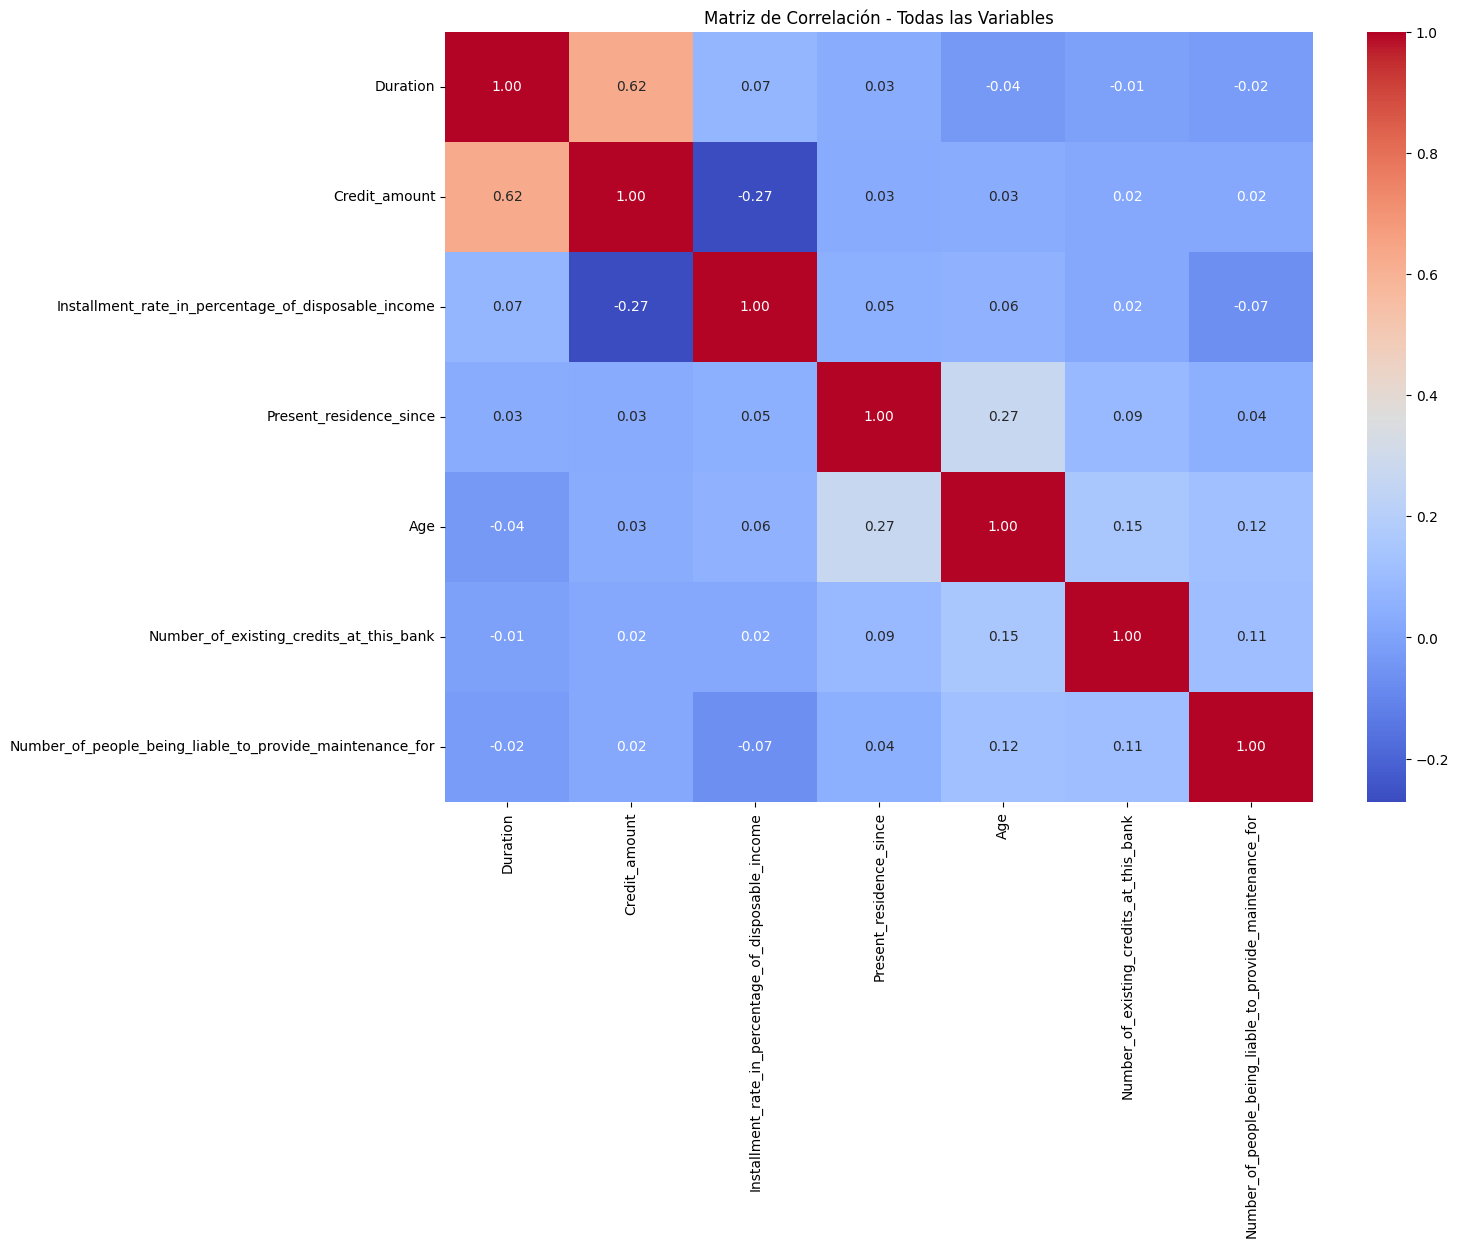

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt


# Verificar si hay variables numéricas
if len(numerical_cols) == 0:
    print("No hay columnas numéricas válidas para generar un mapa de calor.")
else:
    # Calcular la matriz de correlación para todas las variables numéricas
    combined_corr_matrix = df[numerical_cols].corr()

    # Visualizar el mapa de calor
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        combined_corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        cbar=True
    )
    plt.title('Matriz de Correlación - Todas las Variables')
    plt.show()


El análisis del mapa de calor muestra que las correlaciones entre las variables son moderadas, con valores entre 0.62 y -0.27, y no se observan relaciones extremadamente altas que indiquen redundancia. 

### Creación de nuevas variables que puedan ser útiles (extracción de características)

En este caso, considerando las variables disponibles, no se considera necesario crear nuevas características en este momento. Las variables ya proporcionan información clara y bien definida, como duración del crédito, historial crediticio, cantidad del crédito, edad, y otras que capturan distintos aspectos relevantes del problema.

### Transformación de las variables (e.g. corrección de asimetrías graves y/o curtosis en los valores de los datos)

Después de probar el uso de estas transformaciones y observar los resultados hemos decidido no realizarlas por simplicidad

In [47]:
"""
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

# Lista de columnas numéricas
numerical_cols = [
    'Duration', 
    'Credit_amount', 
    'Installment_rate_in_percentage_of_disposable_income', 
    'Present_residence_since', 
    'Age', 
    'Number_of_existing_credits_at_this_bank', 
    'Number_of_people_being_liable_to_provide_maintenance_for'
]

# Crear transformador para las columnas con asimetría significativa
transformer = PowerTransformer(method='yeo-johnson', standardize=False)

# Transformar las columnas numéricas
for col in numerical_cols:
    skewness = skew(df[col])
    print(f"{col}: Asimetría antes de transformación = {skewness:.2f}")
    
    if abs(skewness) > 1:  
        print(f"Aplicando transformación a {col}...")
        df[col] = transformer.fit_transform(df[col].values.reshape(-1, 1))

    # Verificar asimetría después de la transformación
    skewness_after = skew(df[col])
    print(f"{col}: Asimetría después de transformación = {skewness_after:.2f}")

"""

'\nfrom sklearn.preprocessing import PowerTransformer\nfrom scipy.stats import skew\n\n# Lista de columnas numéricas\nnumerical_cols = [\n    \'Duration\', \n    \'Credit_amount\', \n    \'Installment_rate_in_percentage_of_disposable_income\', \n    \'Present_residence_since\', \n    \'Age\', \n    \'Number_of_existing_credits_at_this_bank\', \n    \'Number_of_people_being_liable_to_provide_maintenance_for\'\n]\n\n# Crear transformador para las columnas con asimetría significativa\ntransformer = PowerTransformer(method=\'yeo-johnson\', standardize=False)\n\n# Transformar las columnas numéricas\nfor col in numerical_cols:\n    skewness = skew(df[col])\n    print(f"{col}: Asimetría antes de transformación = {skewness:.2f}")\n    \n    if abs(skewness) > 1:  # Transformar solo si la asimetría es significativa\n        print(f"Aplicando transformación a {col}...")\n        df[col] = transformer.fit_transform(df[col].values.reshape(-1, 1))\n\n    # Verificar asimetría después de la transfor

## Método de Remuestreo 

Antes de la normalización haremos el remuestreo de los datos ya que el procedimiento correcto es dividir el conjunto en entramiento y test y aplicar solo el escalado a los datos de entrenamiento (fit_transform), y despues con el escalador ajustado a los datos de entrenamiento, escalar los de test.

Separamos las características y la variable objetivo, dividiendo el conjunto en entrenamiento (80%) y prueba (20%) de forma estratificada por lo que hemos comentado anteriormente después de observar las gráficas (que ahora afirmaremos en este apartado con y.value_counts()). stratify=y en train_test_split asegura que la proporción entre las clases de la variable objetivo se conserve en los conjuntos de entrenamiento y prueba. Esto es especialmente útil cuando las clases están desbalanceadas, que es nuestro caso, para garantizar que ambas particiones tengan representaciones proporcionales de todas las clases.  

 Utilizamos validación cruzada con 5 pliegues para evaluar el modelo de manera robusta.

In [48]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('class', axis=1)  
y = df['class']

print("Distribución de las etiquetas en el conjunto original:")
print(y.value_counts(), "\n")

# Dividir los datos en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random, stratify=y
)

# Configurar la validación cruzada estratificada con 5 pliegues 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

# Imprimir las dimensiones de los conjuntos
print("Dimensiones de los conjuntos:\n")
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")
print("\n")
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())

# Contar las instancias de cada etiqueta en y_test
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())
X_train[:2]

Distribución de las etiquetas en el conjunto original:
class
1    700
2    300
Name: count, dtype: int64 

Dimensiones de los conjuntos:

Conjunto de entrenamiento: (800, 20)
Conjunto de prueba: (200, 20)


Distribución en el conjunto de entrenamiento:
class
1    560
2    240
Name: count, dtype: int64

Distribución en el conjunto de prueba:
class
1    140
2     60
Name: count, dtype: int64


Status_of_existing_checking_account  Duration  \
882                   0 <= ... < 200 DM        30   
719                   0 <= ... < 200 DM        20   

                                        Credit_history     Purpose  \
882  critical account/ other credits existing (not ...   car (new)   
719       no credits taken/ all credits paid back duly  car (used)   

     Credit_amount        Savings_account/bonds Present_employment_since  \
882           2181  unknown/ no savings account           ... >= 7 years   
719           6148          100 <= ... < 500 DM           ... >= 7 years   

     Installment_rate_in_percentage_of_disposable_income  \
882                                                  4     
719                                                  3     

    Personal_status_and_sex Other_debtors_/_guarantors  \
882            male: single                       none   
719   male: married/widowed                       none   

     Present_residence_since      Property  Age Other_installment_plans  \
882                        4   real estate   36                    none   
719                        4  car or other   31                    bank   

    Housing  Number_of_existing_credits_at_this_bank  \
882     own                                        2   
719     own                                        2   

                             Job  \
882  skilled employee / official   
719  skilled employee / official   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                                  1          
719                                                  1          

                                     Telephone foreign_worker  
882                                       none            yes  
719  yes, registered under the customer's name            yes

### Codificación de variables no continuas o no ordenadas y Normalización de la variables (e.g. estandarización)

En nuestro conjunto de datos hace falta cambiar los valores de las variables categóricas de strings a numeros:
Utilizaremos One-Hot Encoding ya que estas las clases de estas variables categóricas no representan un orden.

La normalización de las variables es un paso clave en el preprocesamiento, especialmente para modelos que son sensibles a las escalas de los datos. Este proceso garantiza que todas las variables numéricas tengan una escala comparable, evitando que aquellas con rangos más grandes dominen el análisis. En este caso, se realizará la estandarización, transformando las variables numéricas para que tengan una media de 0 y una desviación estándar de 1. Esto facilita la convergencia de los modelos y mejora la interpretabilidad de los resultados.



In [49]:
from sklearn.preprocessing import OneHotEncoder
#Identificar numéricas y categóricas
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear ColumnTransformer 
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])

# Crear pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

#Ajustar pipeline en entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)  # y_train se usaría si tuvieras un step supervisado
X_test_transformed = pipeline.transform(X_test)

#Reconstruir DataFrame si deseas visualizar
num_col_names = num_features
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_col_names = ohe.get_feature_names_out(cat_features)
final_col_names = list(num_col_names) + list(ohe_col_names) # Lista de nombres de columnas finales

X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=final_col_names,
                                      index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=final_col_names,
                                     index=X_test.index)

display(X_train.head(2))

display(X_train_transformed_df.head(2))



Status_of_existing_checking_account  Duration  \
882                   0 <= ... < 200 DM        30   
719                   0 <= ... < 200 DM        20   

                                        Credit_history     Purpose  \
882  critical account/ other credits existing (not ...   car (new)   
719       no credits taken/ all credits paid back duly  car (used)   

     Credit_amount        Savings_account/bonds Present_employment_since  \
882           2181  unknown/ no savings account           ... >= 7 years   
719           6148          100 <= ... < 500 DM           ... >= 7 years   

     Installment_rate_in_percentage_of_disposable_income  \
882                                                  4     
719                                                  3     

    Personal_status_and_sex Other_debtors_/_guarantors  \
882            male: single                       none   
719   male: married/widowed                       none   

     Present_residence_since      Property  Age Other_installment_plans  \
882                        4   real estate   36                    none   
719                        4  car or other   31                    bank   

    Housing  Number_of_existing_credits_at_this_bank  \
882     own                                        2   
719     own                                        2   

                             Job  \
882  skilled employee / official   
719  skilled employee / official   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                                  1          
719                                                  1          

                                     Telephone foreign_worker  
882                                       none            yes  
719  yes, registered under the customer's name            yes

Duration  Credit_amount  \
882  0.754215      -0.379305   
719 -0.089898       1.060270   

     Installment_rate_in_percentage_of_disposable_income  \
882                                           0.925948     
719                                           0.032391     

     Present_residence_since       Age  \
882                 1.045269  0.021988   
719                 1.045269 -0.413415   

     Number_of_existing_credits_at_this_bank  \
882                                  1.01522   
719                                  1.01522   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                          -0.444528          
719                                          -0.444528          

     Status_of_existing_checking_account_... >= 200 DM  \
882                                                0.0   
719                                                0.0   

     Status_of_existing_checking_account_0 <= ... < 200 DM  \
882                                                1.0       
719                                                1.0       

     Status_of_existing_checking_account_no checking account  ...  \
882                                                0.0        ...   
719                                                0.0        ...   

     Property_unknown / no property  Other_installment_plans_none  \
882                             0.0                           1.0   
719                             0.0                           0.0   

     Other_installment_plans_stores  Housing_own  Housing_rent  \
882                             0.0          1.0           0.0   
719                             0.0          1.0           0.0   

     Job_skilled employee / official  \
882                              1.0   
719                              1.0   

     Job_unemployed/ unskilled - non-resident  Job_unskilled - resident  \
882                                       0.0                       0.0   
719                                       0.0                       0.0   

     Telephone_yes, registered under the customer's name  foreign_worker_yes  
882                                                0.0                   1.0  
719                                                1.0                   1.0  

[2 rows x 48 columns]

## PCA

Para reducir la dimensionalidad de nuestros datos y facilitar su análisis, hemos aplicado un Análisis de Componentes Principales (PCA). Este método transforma las variables originales en un conjunto de componentes principales que explican la mayor cantidad de varianza posible en los datos. El objetivo es capturar al menos el 95% de la varianza total con el menor número de componentes principales, asegurando que la mayor parte de la información relevante se conserve mientras reducimos la complejidad del modelo.

Varianza explicada por cada componente principal:
[0.236572   0.20026425 0.16313891 0.13607517 0.12523053 0.1005337 ]
El número de componentes seleccionados para explicar el 95% de la varianza es: 6


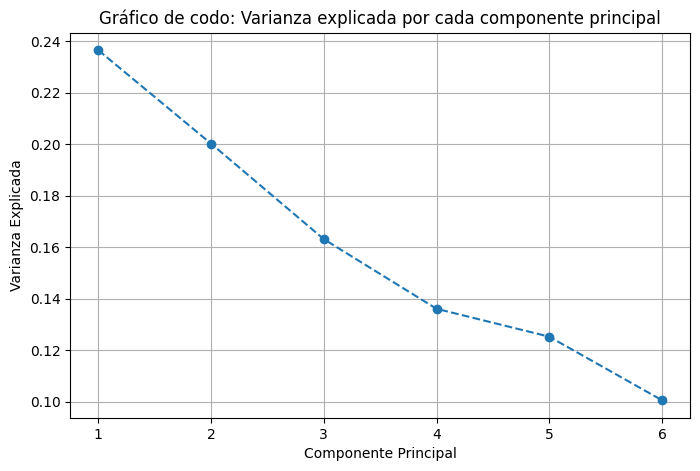

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Inicializar el PCA para capturar el 95% de la varianza
pca = PCA(n_components=0.95)

# Aplicar PCA a las variables numéricas ya estandarizadas
pca_transformed = pca.fit_transform(X_train_transformed_df[numerical_cols]) 

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(pca_transformed.shape[1])])

# Imprimir el porcentaje de varianza explicada por cada componente
print("Varianza explicada por cada componente principal:")
print(pca.explained_variance_ratio_)

# Imprimir el número de componentes seleccionados
print(f"El número de componentes seleccionados para explicar el 95% de la varianza es: {pca.n_components_}")

# Visualización: Gráfico de codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Gráfico de codo: Varianza explicada por cada componente principal')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.grid()
plt.show()


El análisis de componentes principales (PCA) redujo la dimensionalidad del conjunto de datos a seis componentes, que explican el 95% de la varianza total. Las primeras componentes capturan la mayor parte de la información, mientras que las adicionales tienen poca contribución. Esto podría permitir simplificar el modelo sin perder información clave, mejorando la eficiencia en el procesamiento y el rendimiento predictivo.

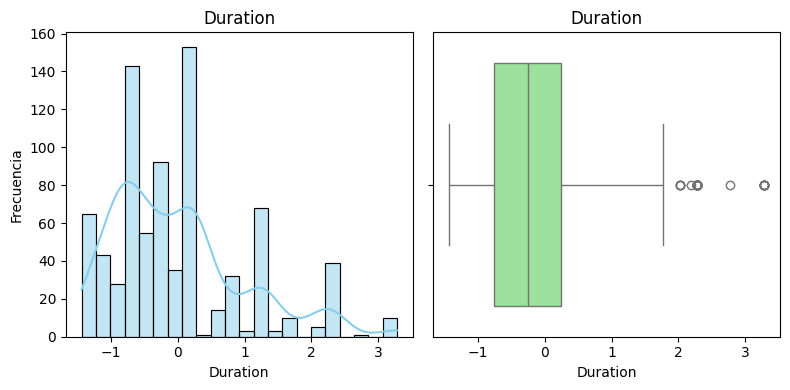

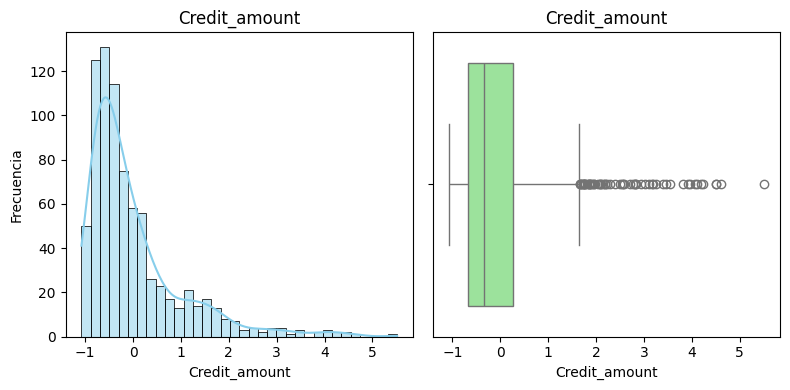

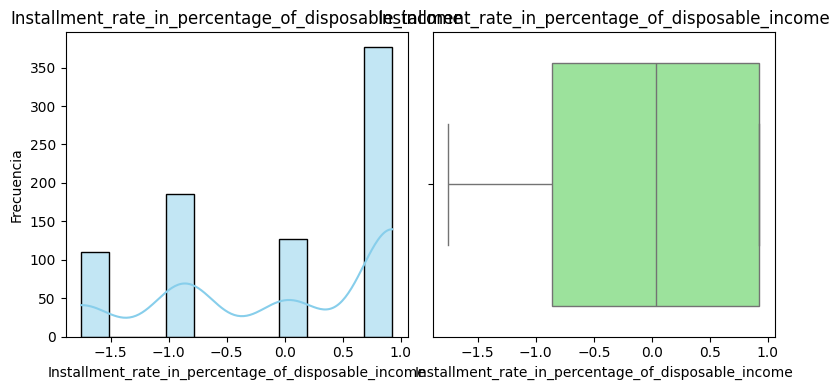

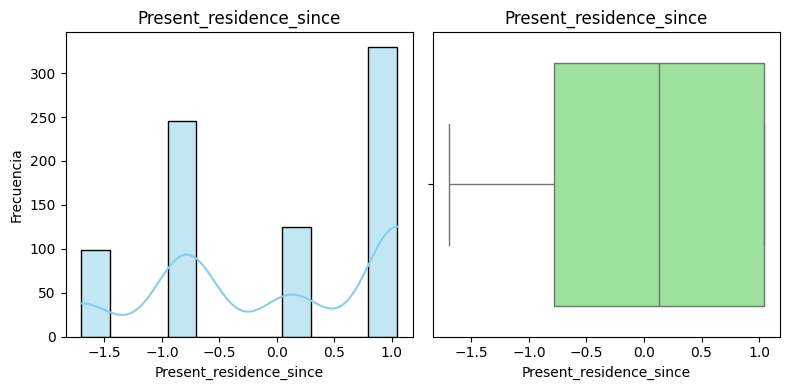

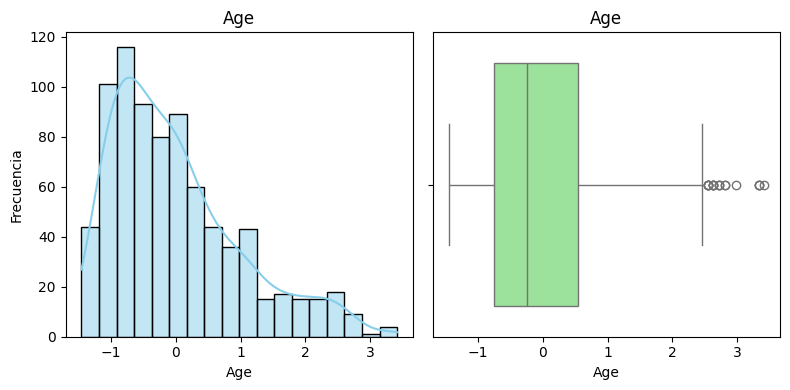

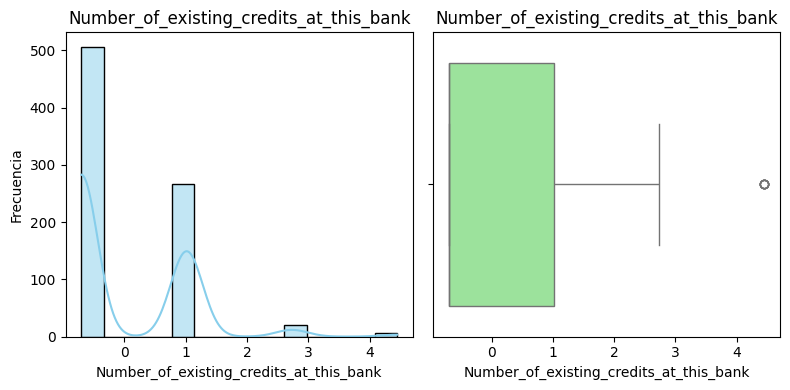

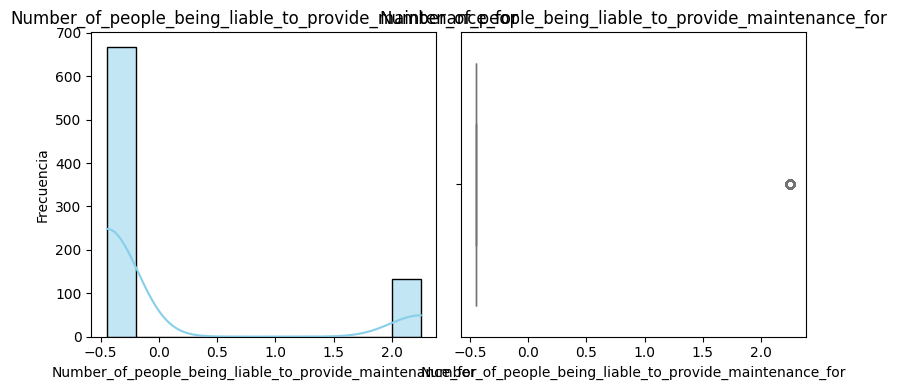

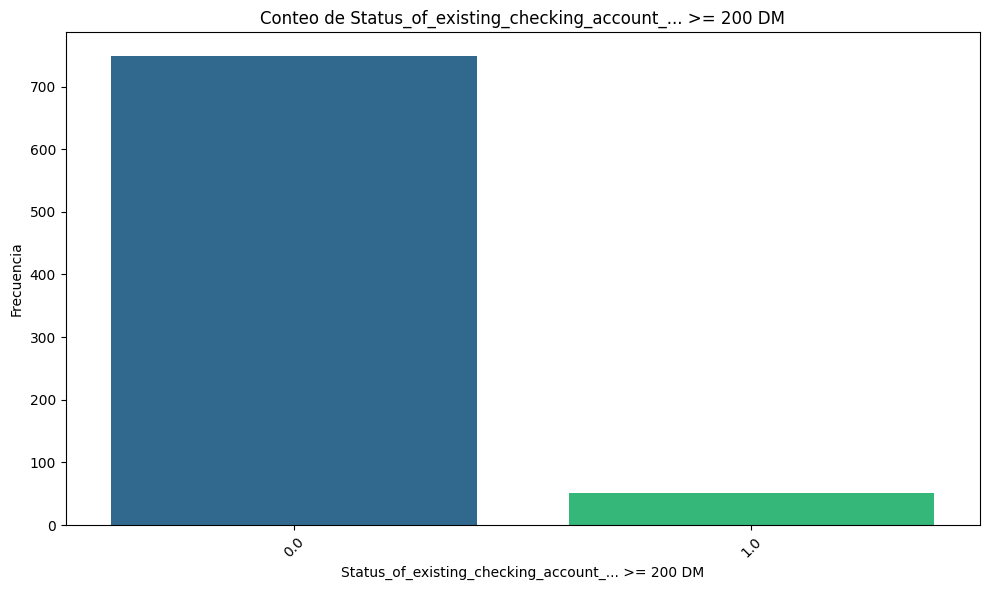

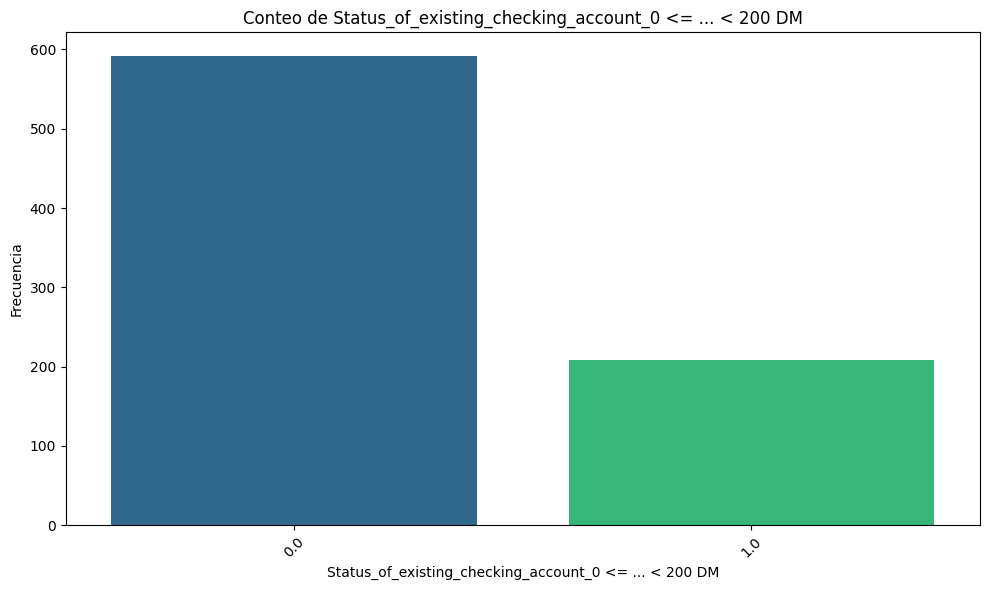

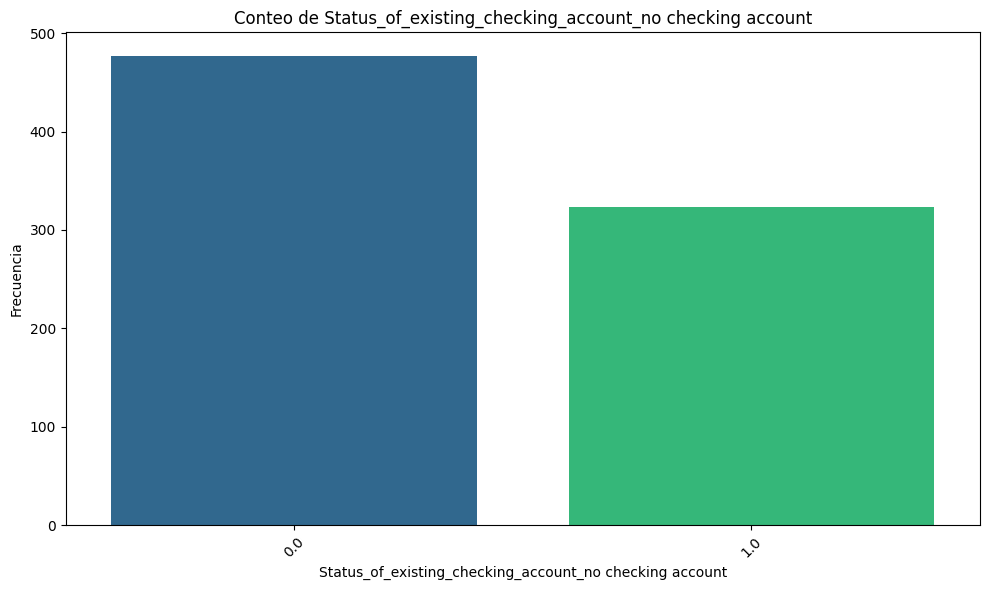

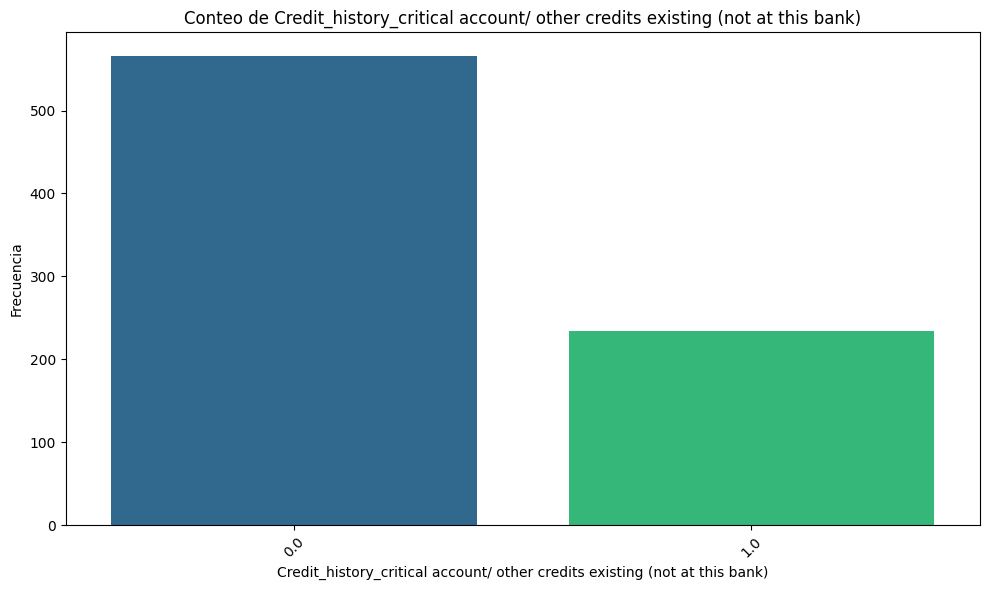

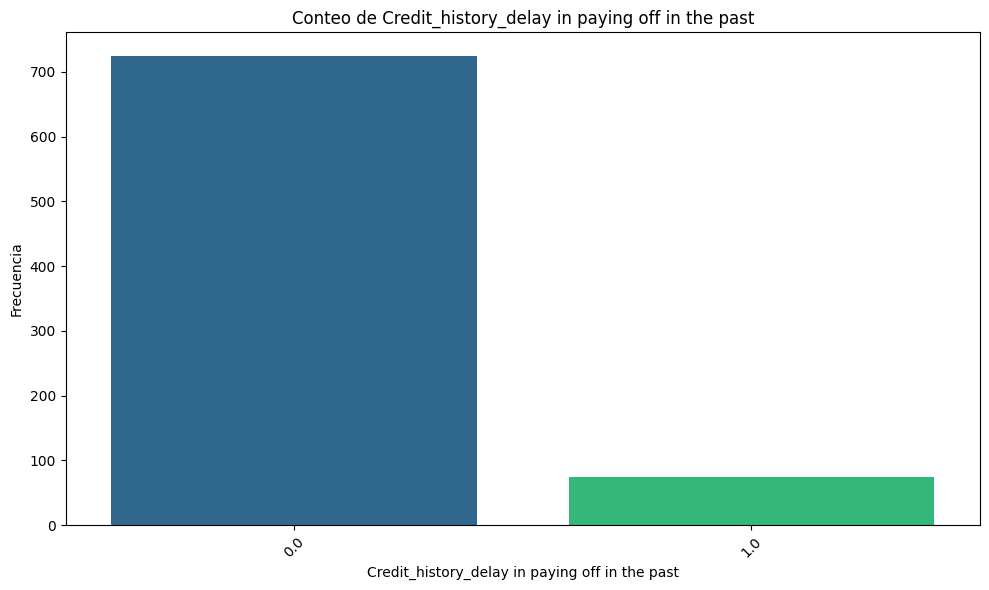

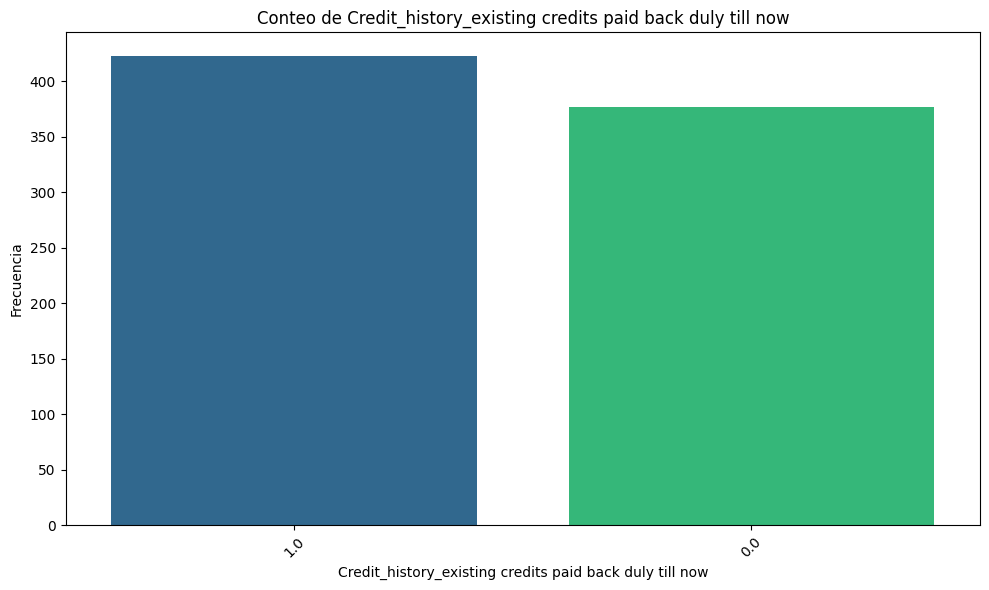

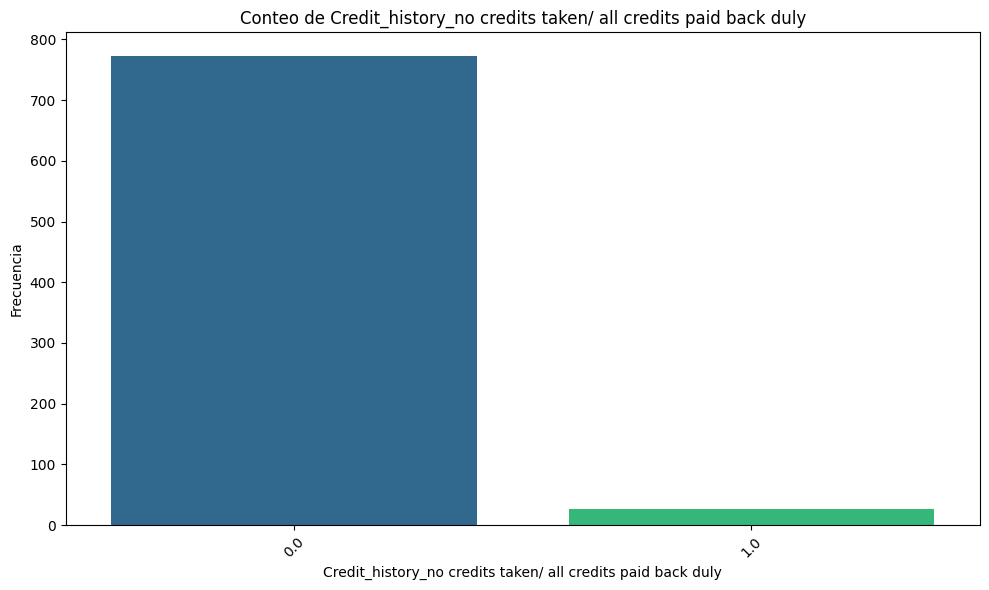

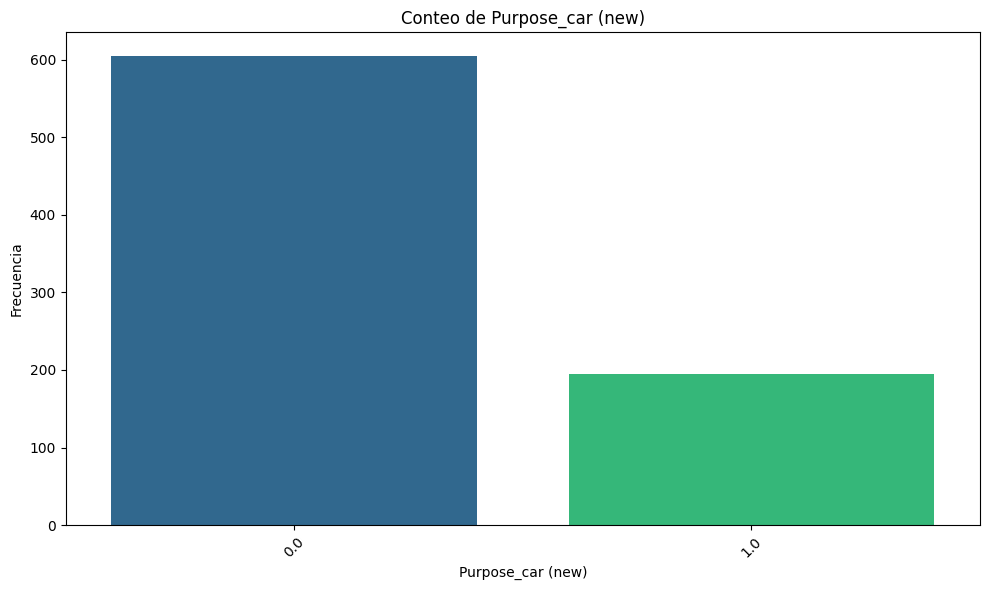

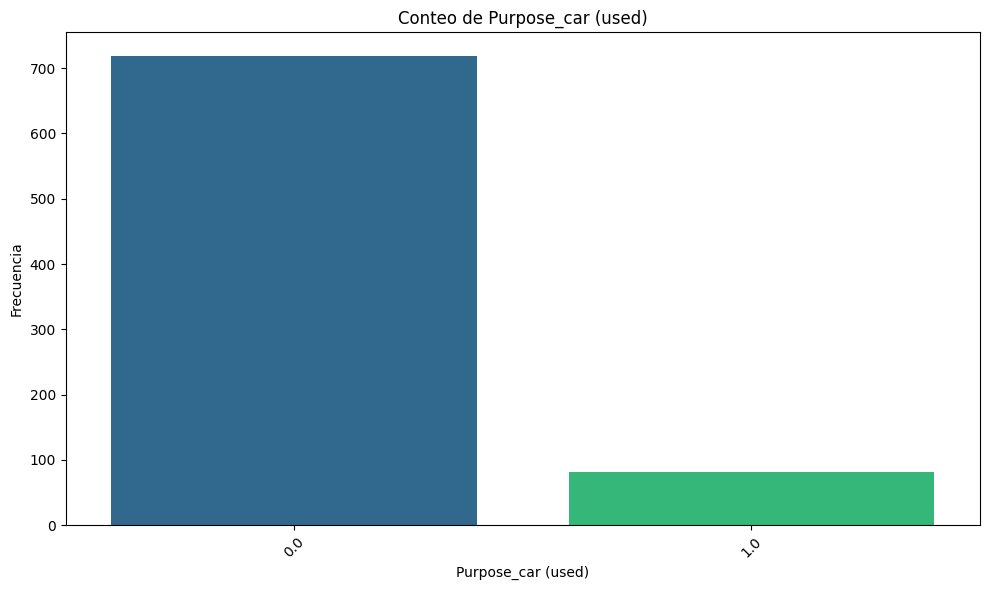

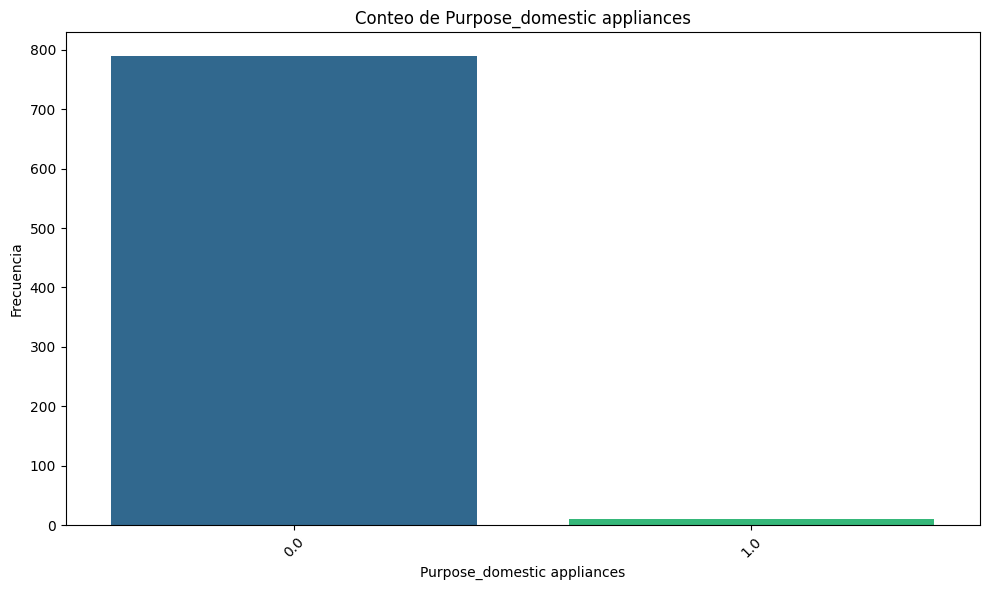

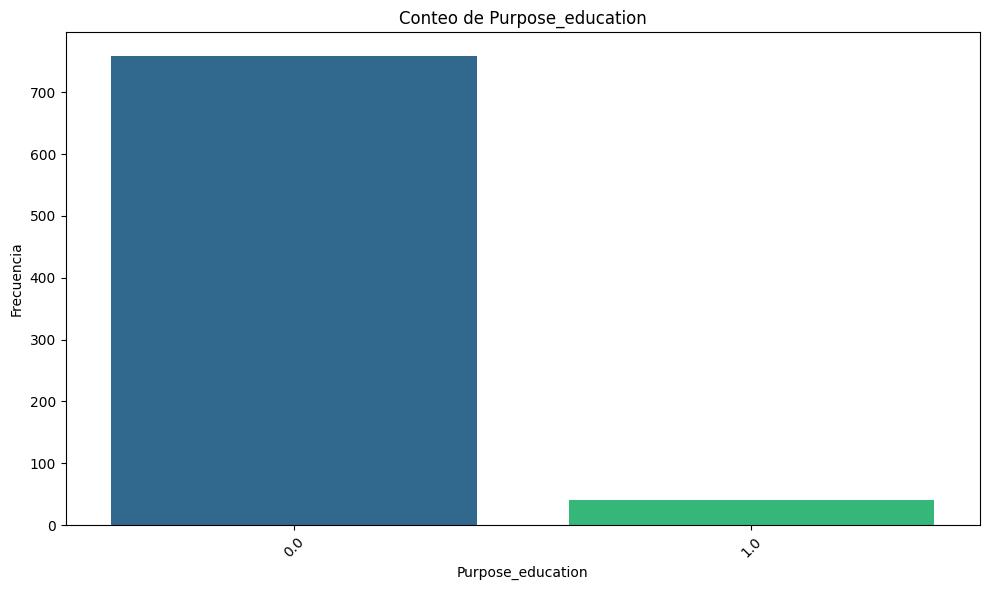

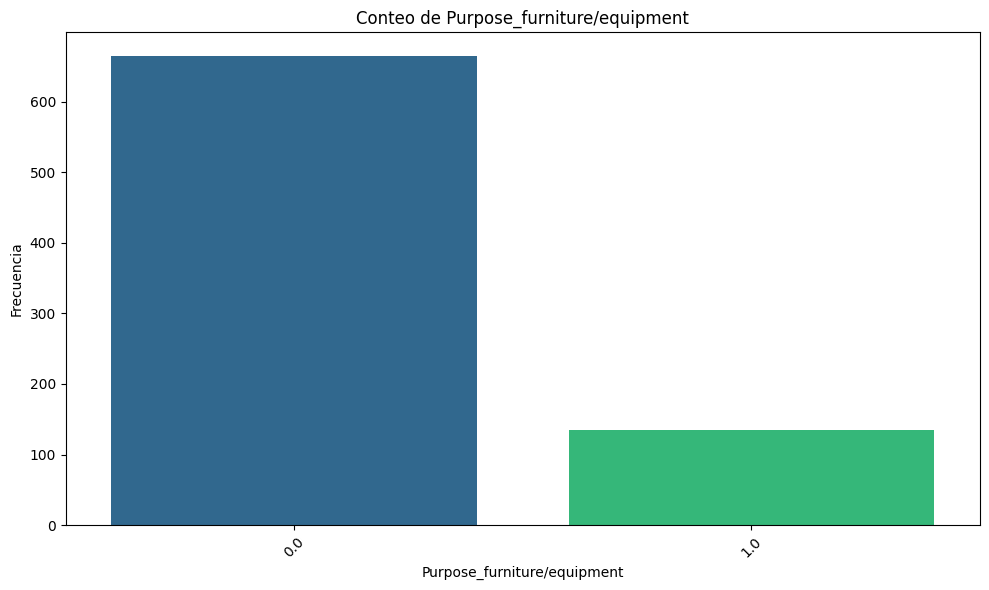

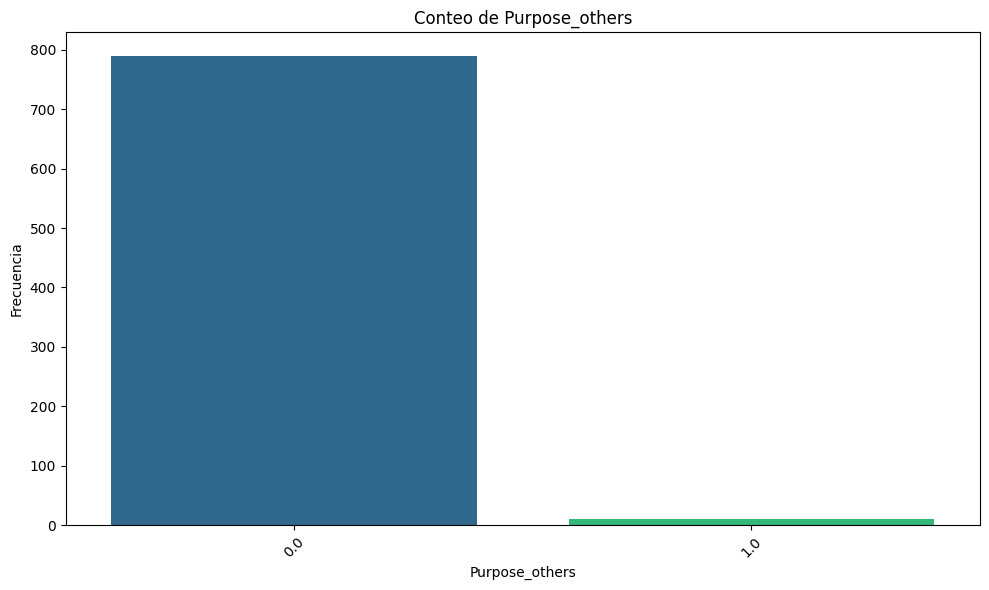

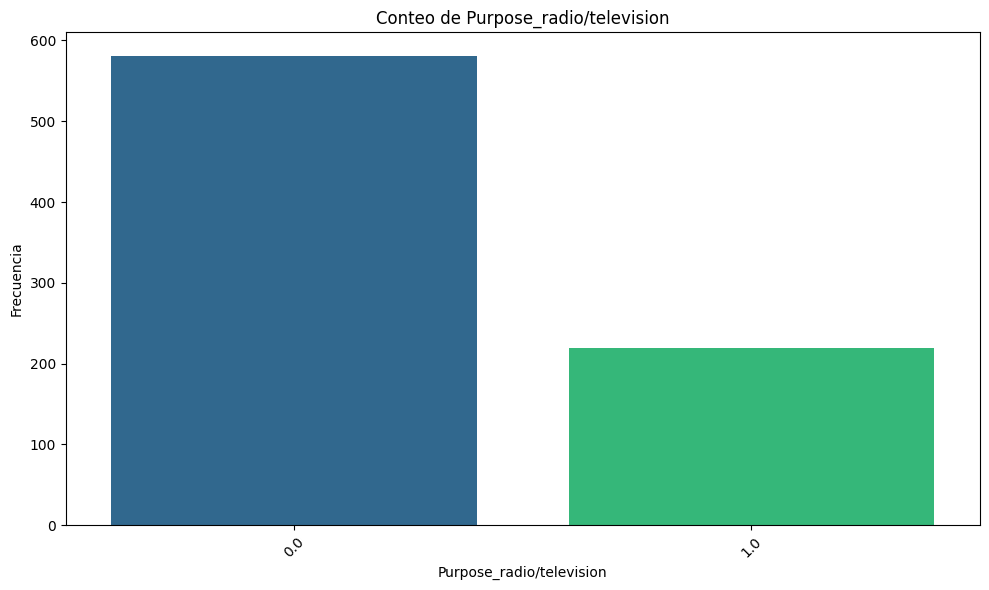

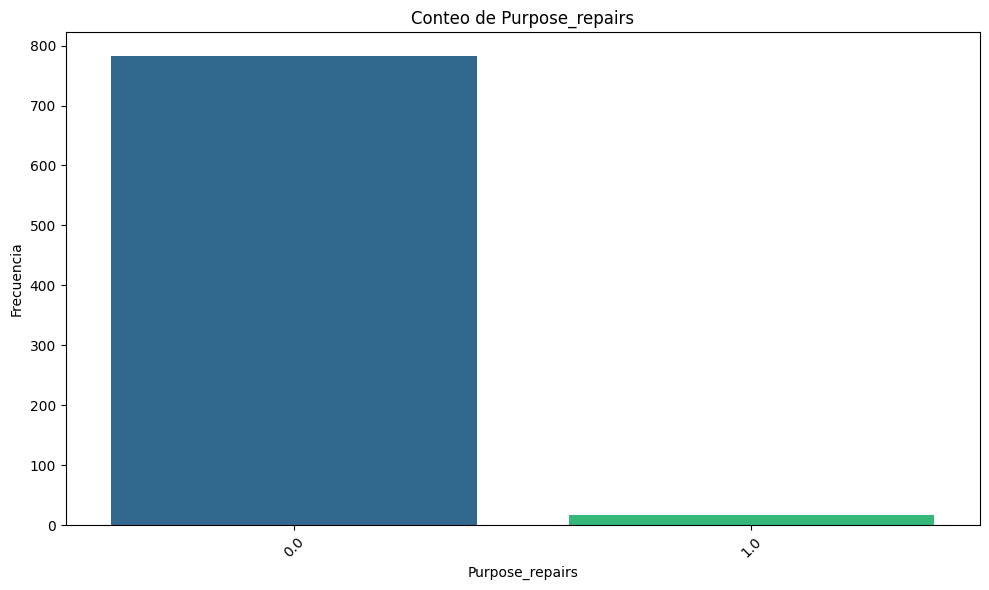

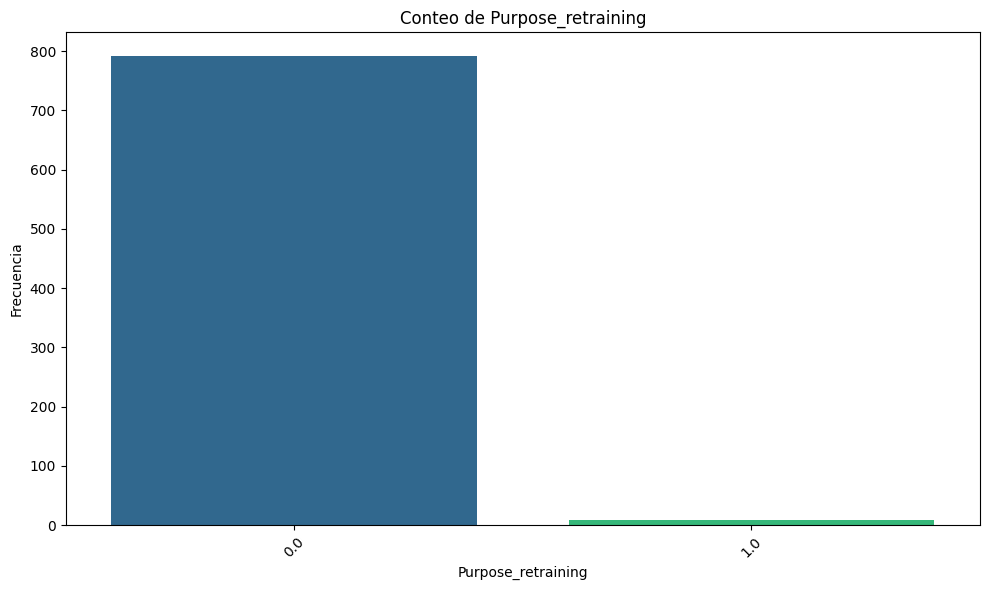

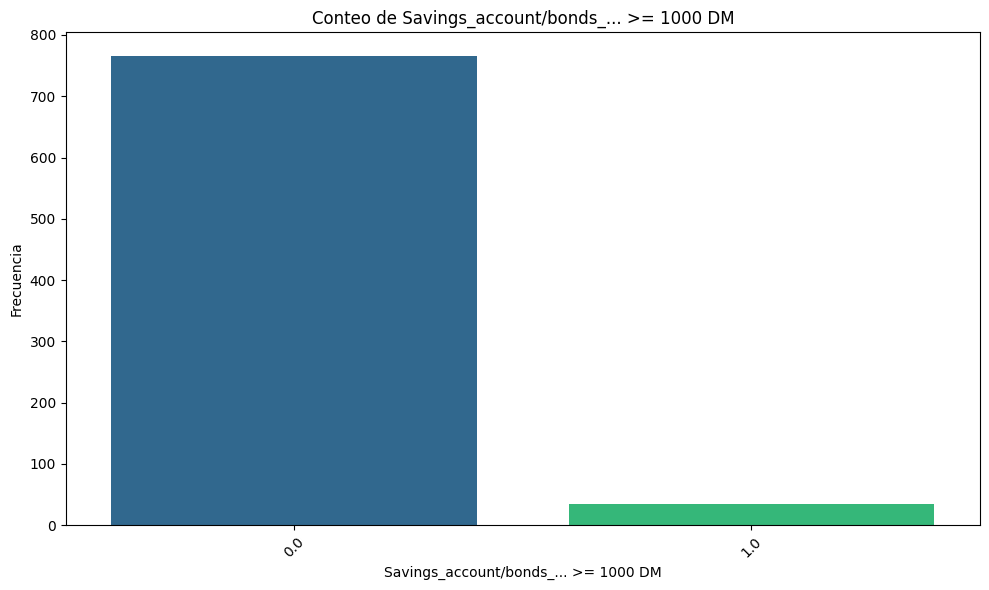

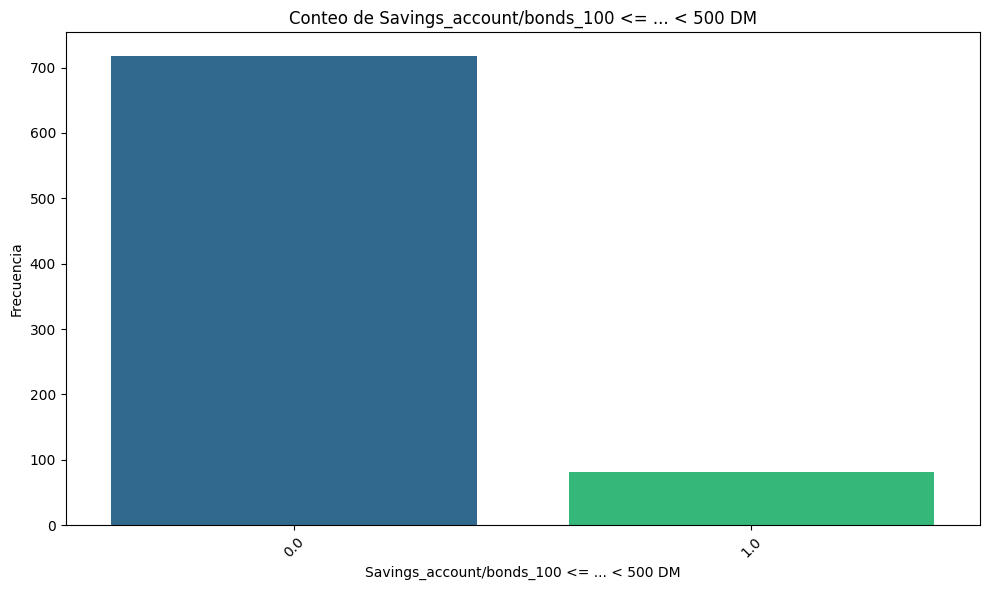

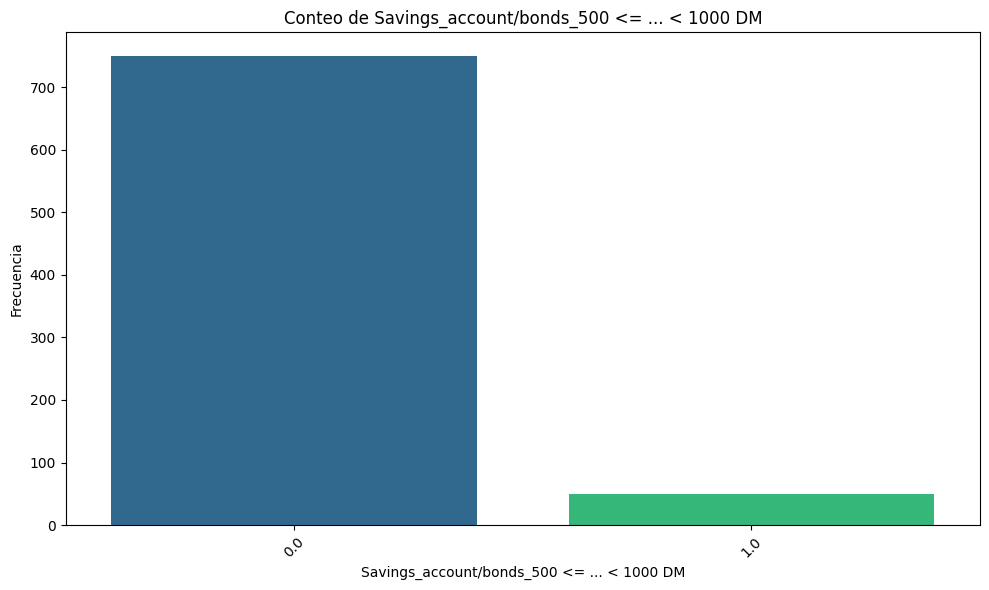

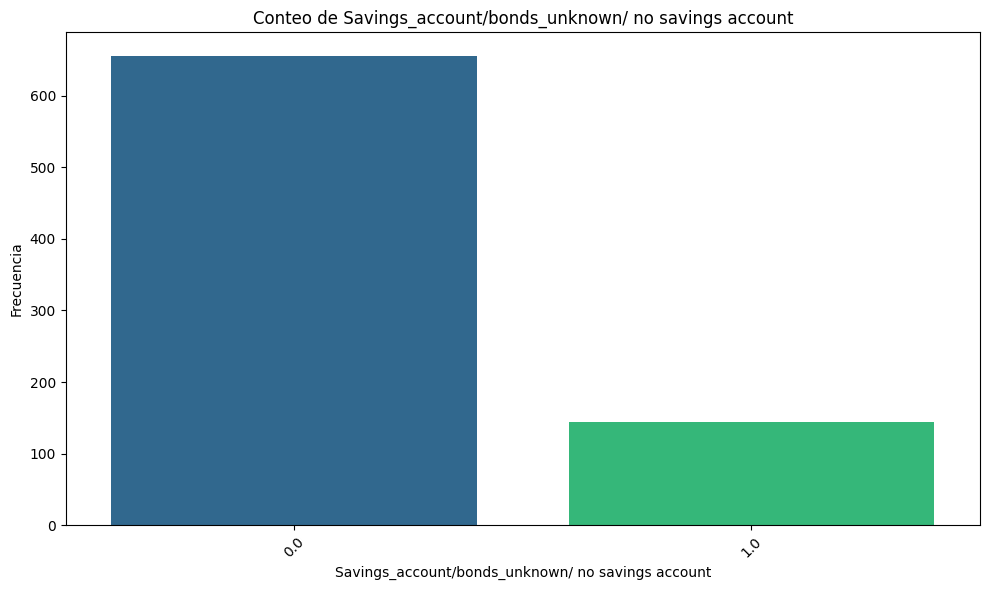

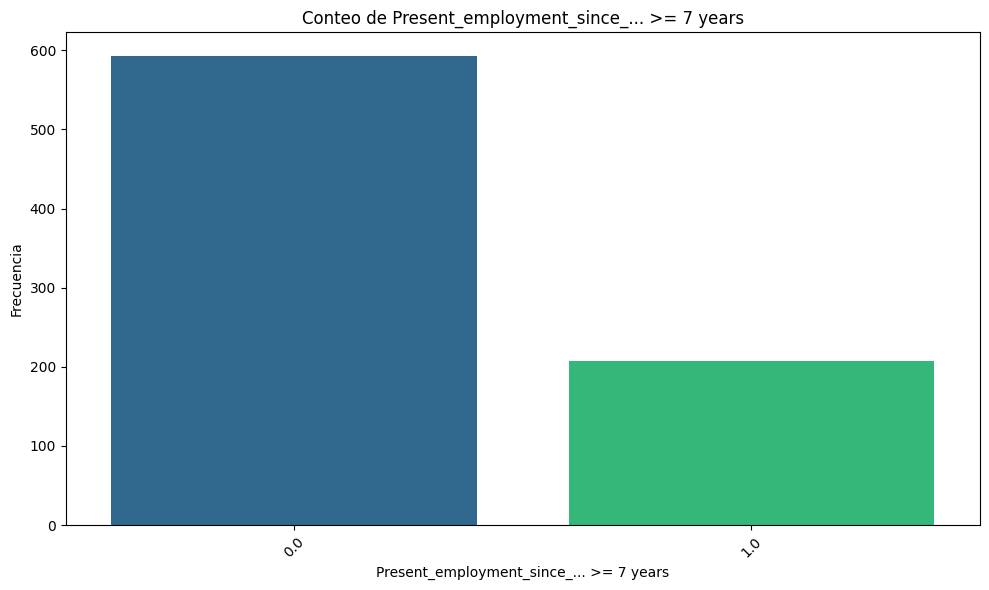

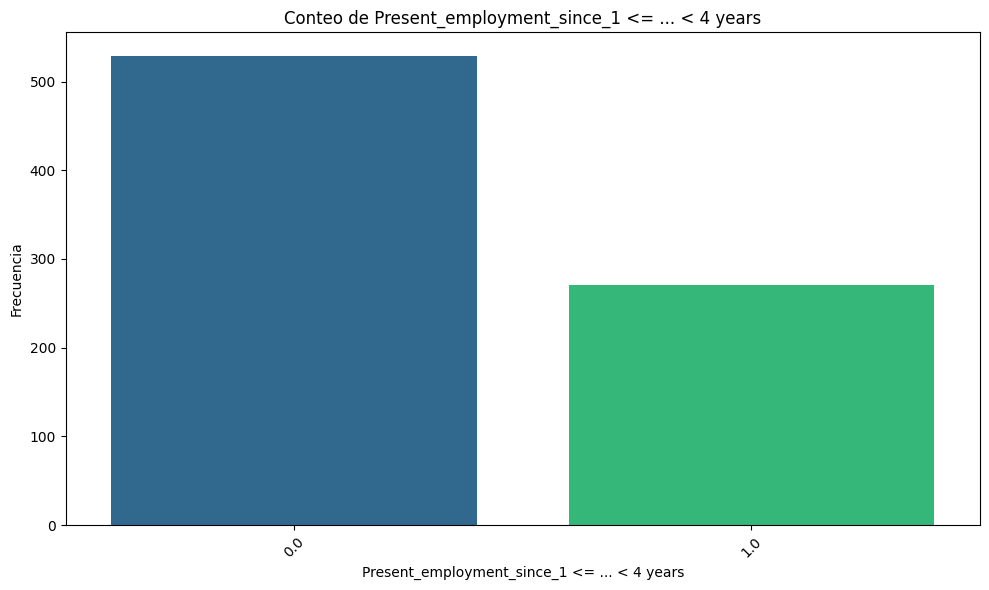

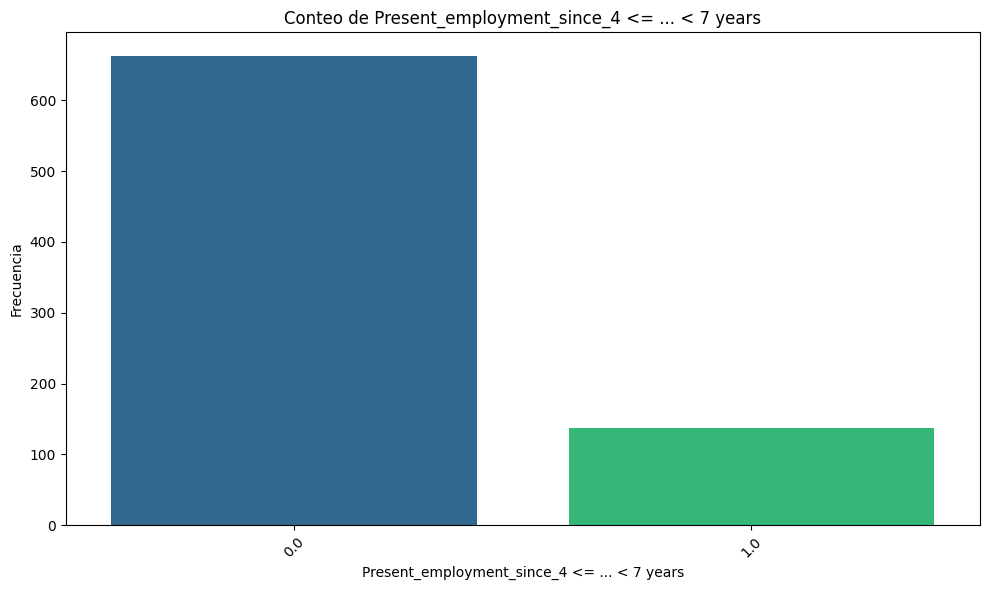

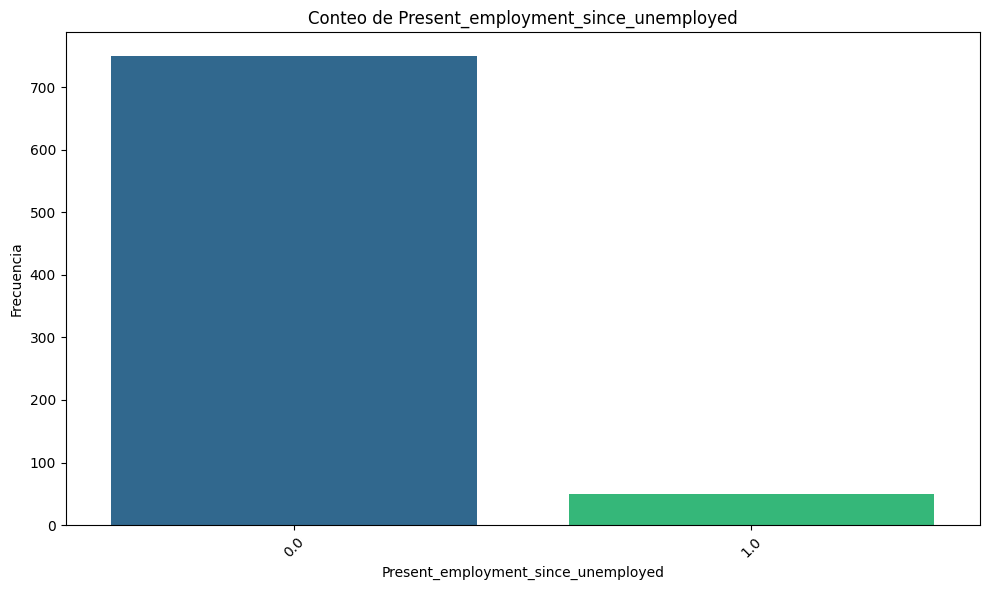

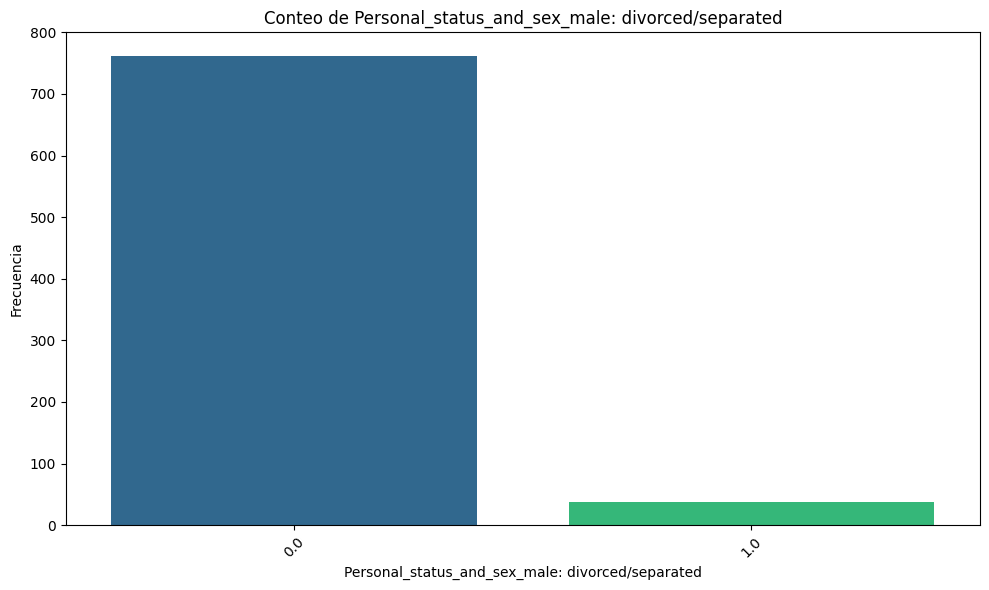

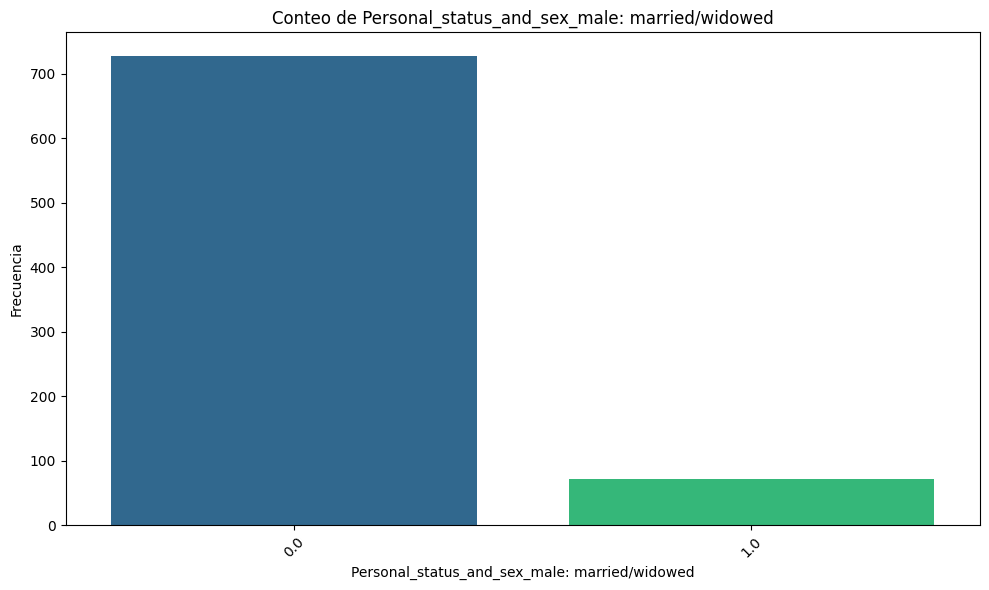

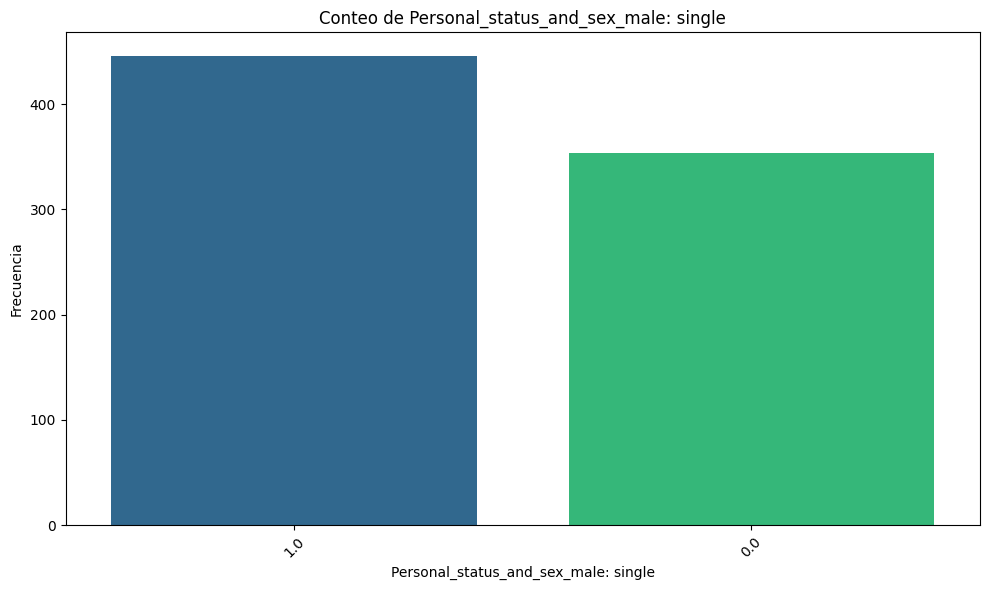

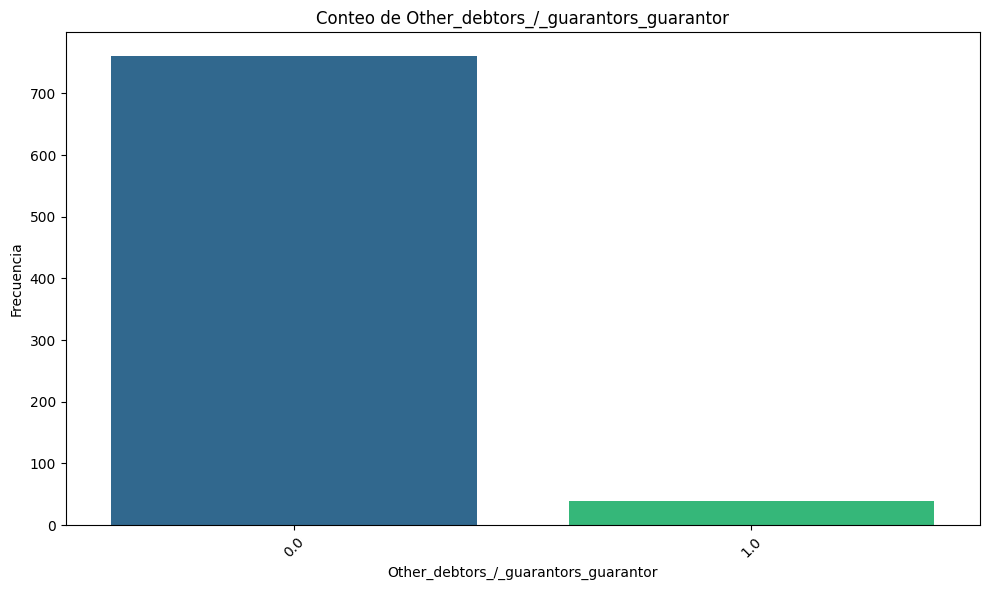

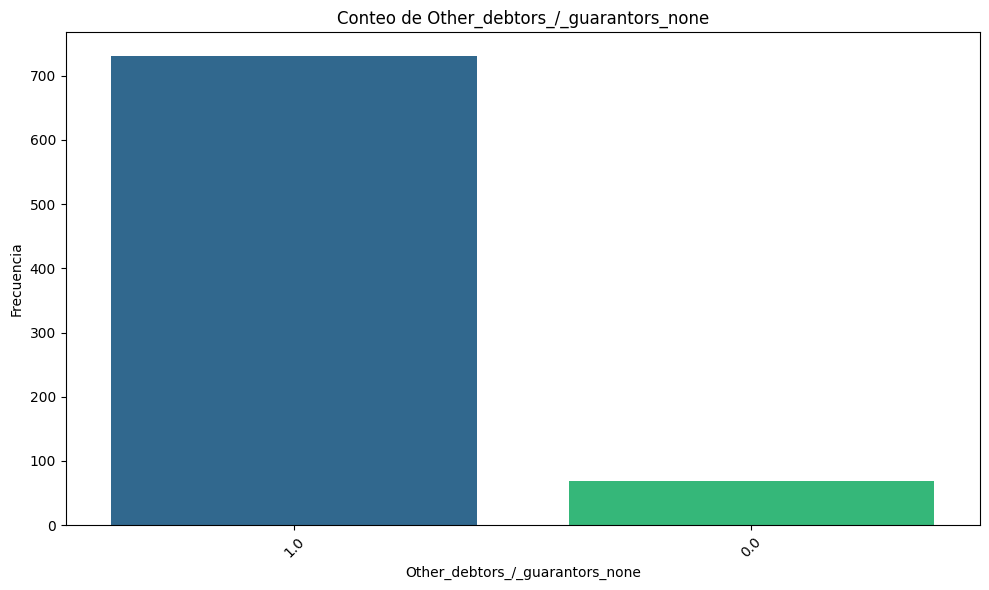

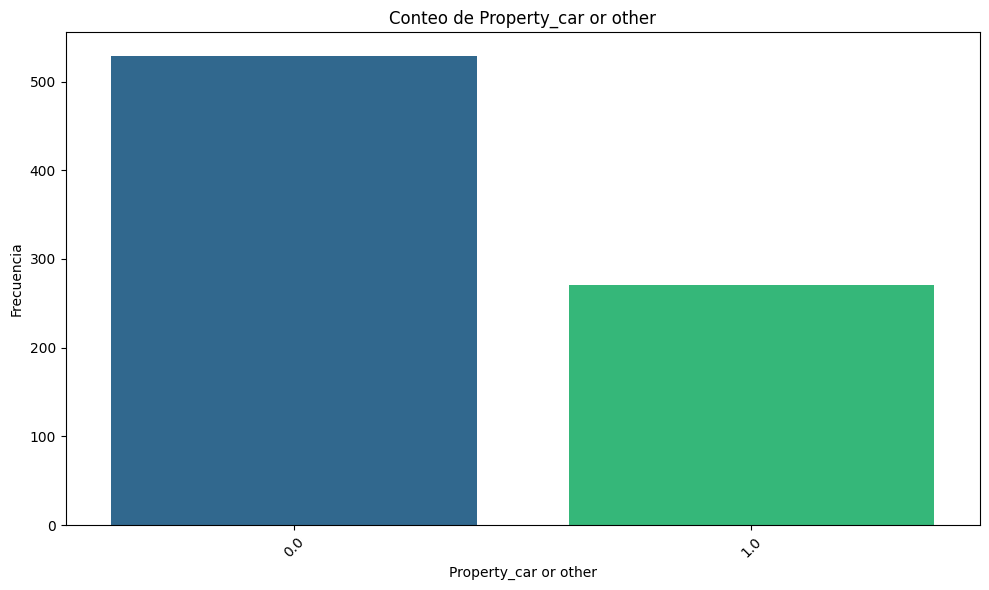

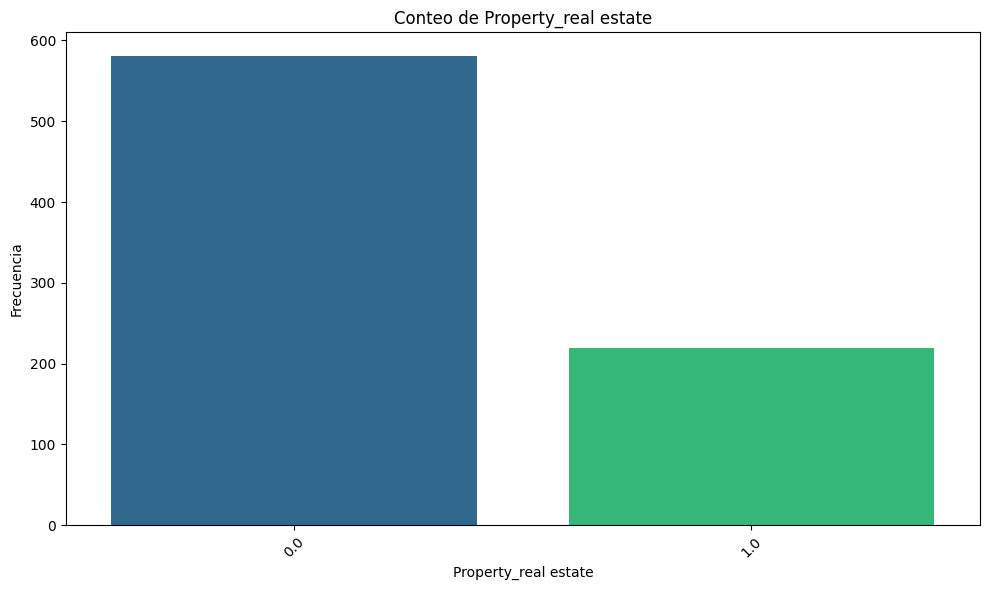

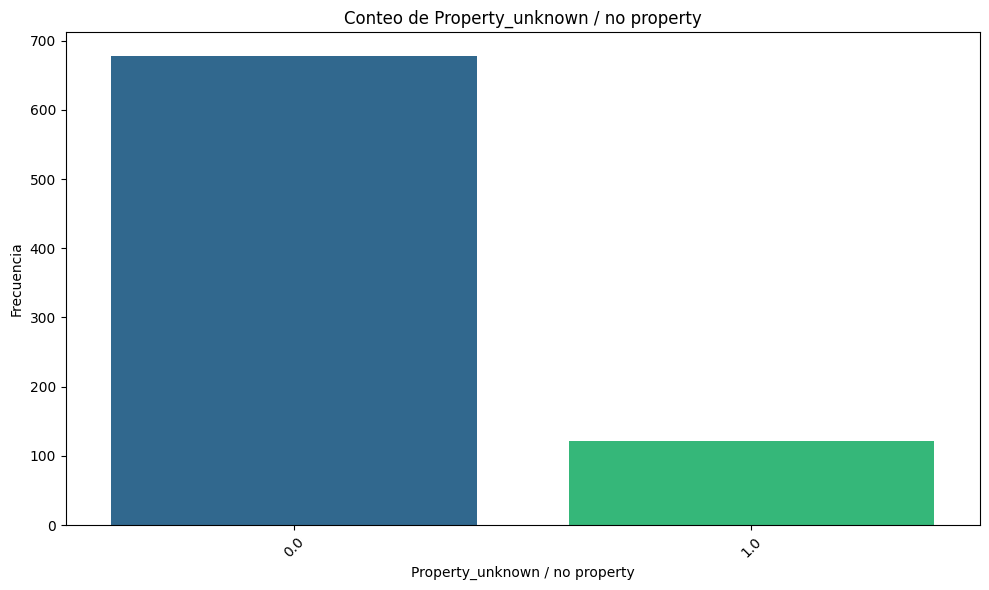

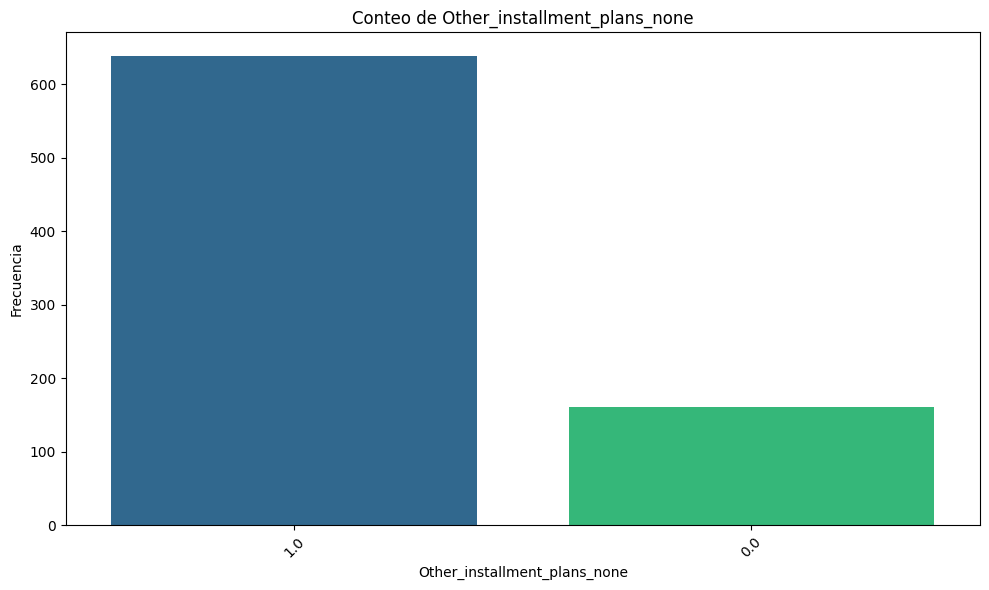

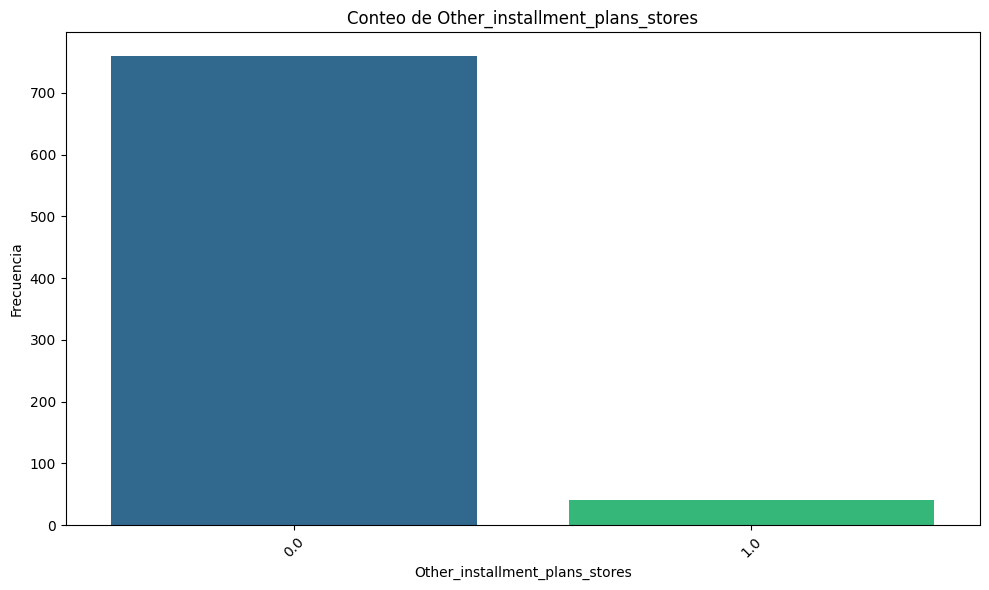

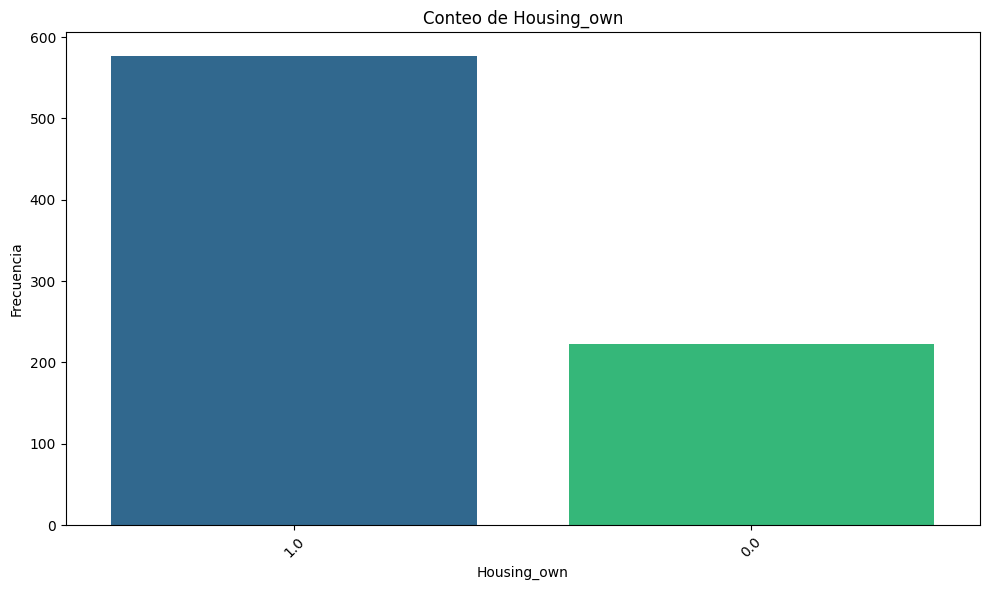

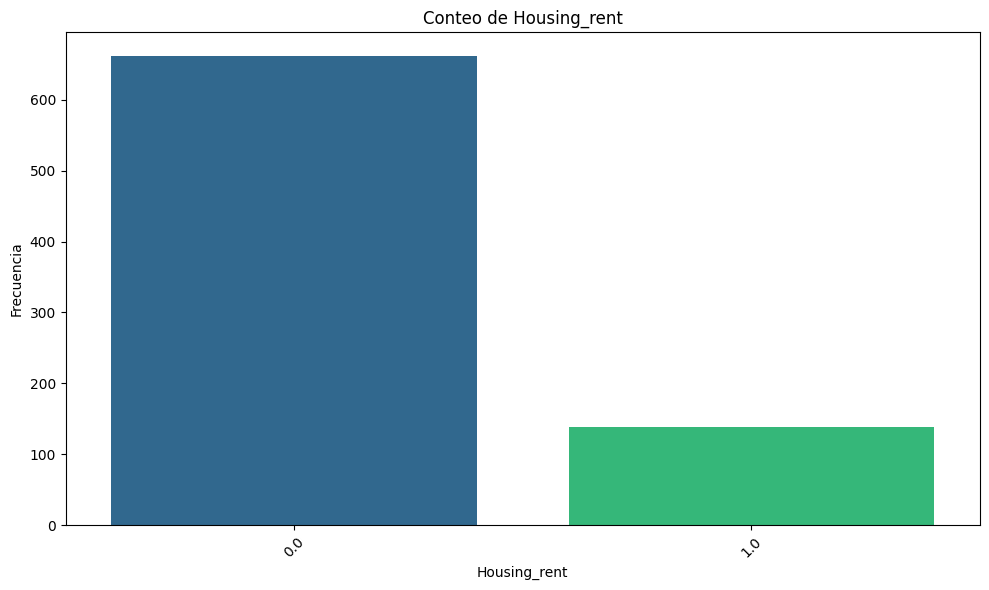

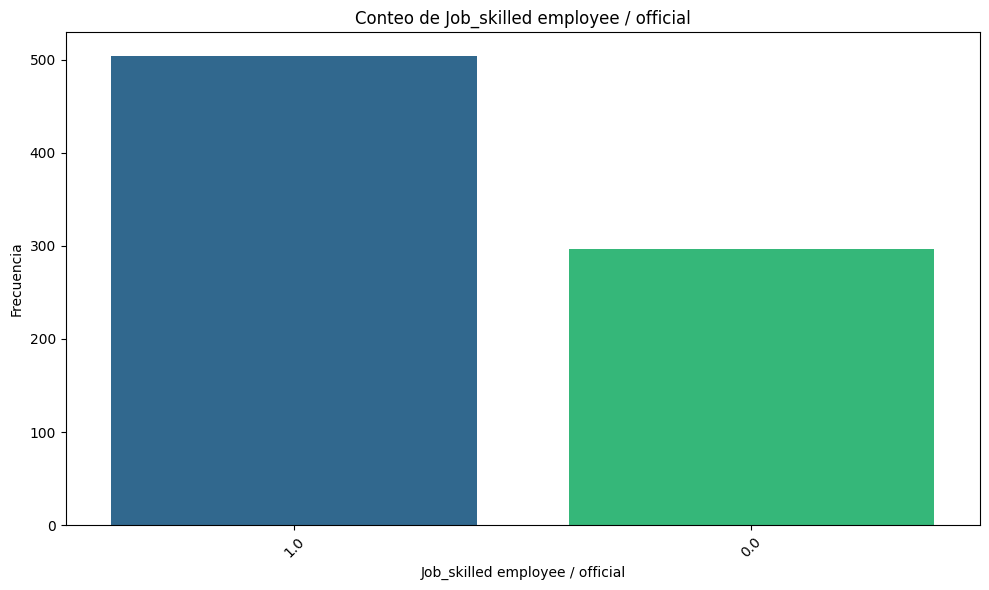

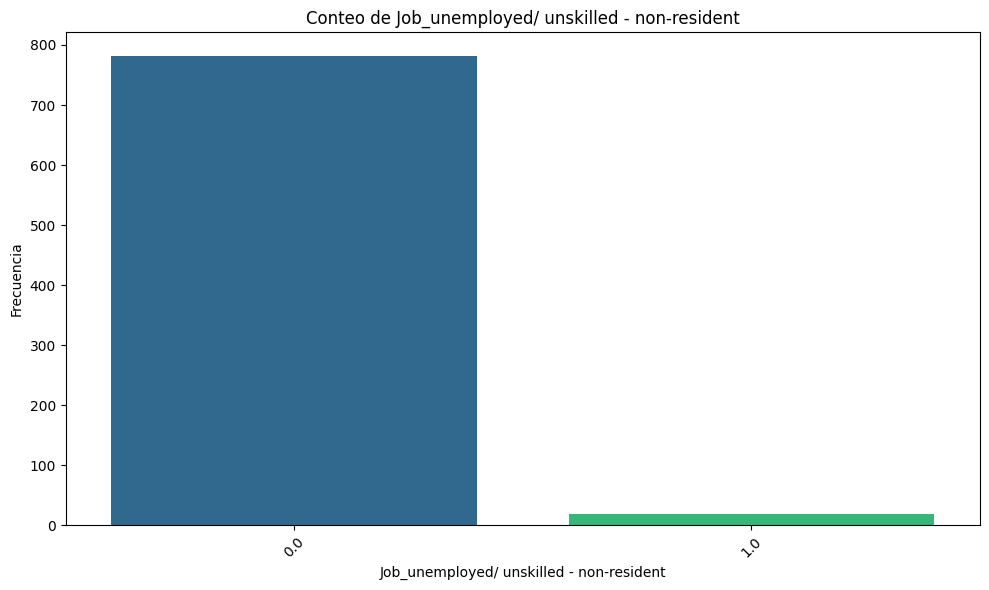

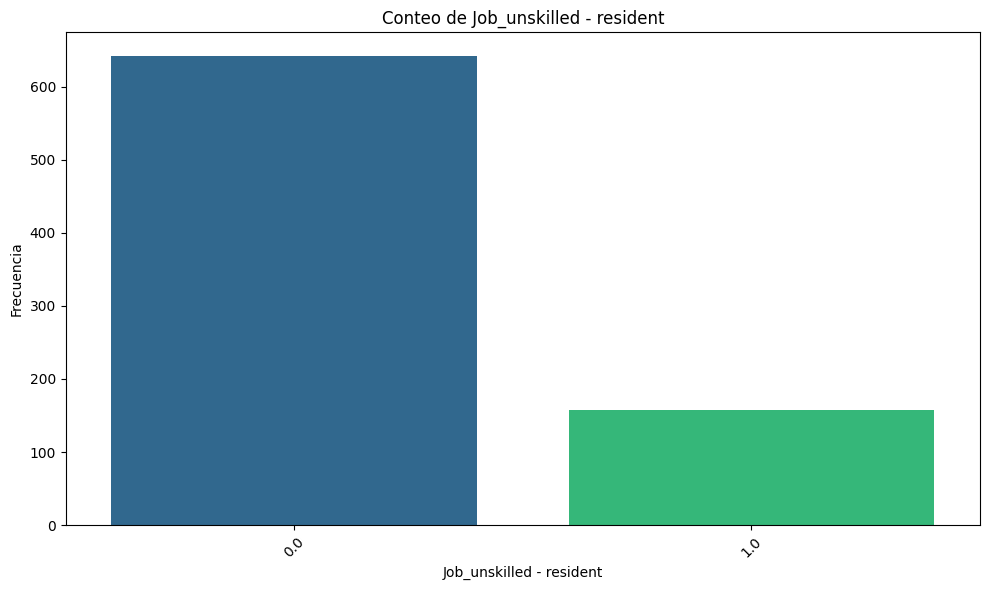

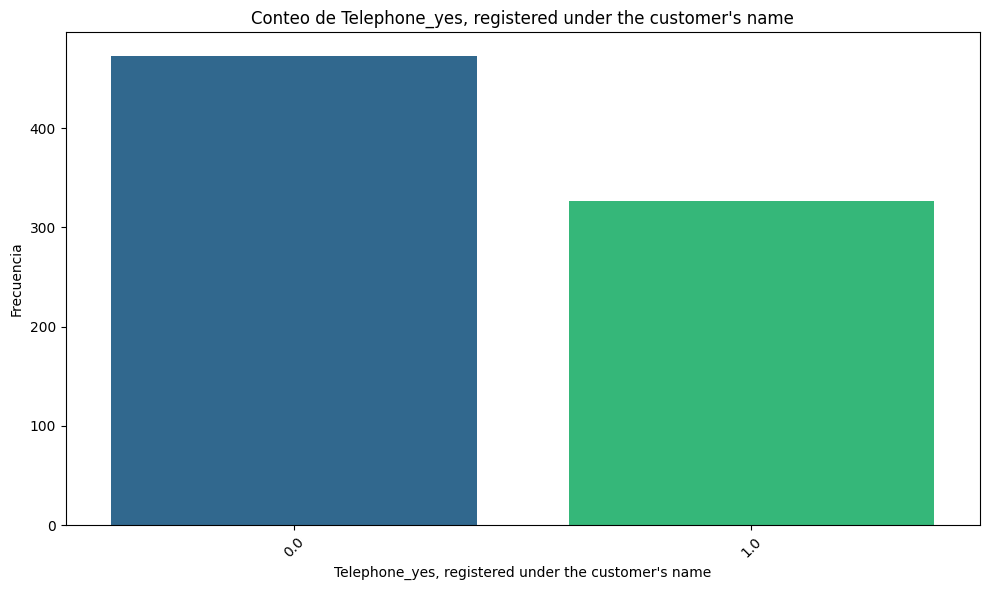

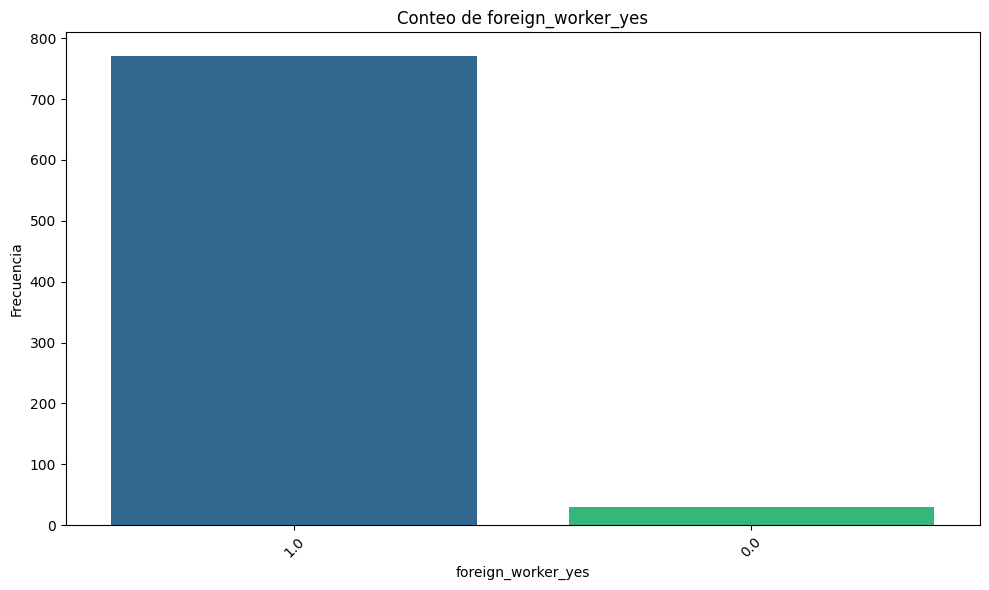

In [51]:
visualize_numerical(X_train_transformed_df, numerical_cols)
visualize_categorical(X_train_transformed_df, ohe_col_names)

# Métodos lineales/cuadráticos

En esta parte del análisis aplicaremos modelos lineales y cuadráticos, como Regresión Logística, Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrático (QDA), para abordar nuestro problema de clasificación. Dado que las clases en nuestro conjunto de datos están desbalanceadas, evaluaremos el rendimiento utilizando métricas como el balanced_accuracy_score, que considera el balance entre las clases calculando el promedio de las tasas de sensibilidad (recall) para cada una. Esto nos permite garantizar que el modelo sea eficaz tanto para la clase mayoritaria como para la minoritaria, proporcionando una evaluación más justa y robusta en este contexto.

## Regresión logística

Ajustando hiperparámetros para Regresión Logística...
Mejores hiperparámetros para Regresión Logística: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Balanced Accuracy promedio en validación cruzada: 0.6929

Regresión Logística:
Accuracy en el conjunto de prueba: 0.7300
Balanced Accuracy en el conjunto de prueba: 0.6405
F1-Score: 0.4808
Precision Clase 1: 0.7756
Precision Clase 2: 0.5682
AUC-ROC: 0.7862

Matriz de confusión:
[[121  19]
 [ 35  25]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.78      0.86      0.82       140
           2       0.57      0.42      0.48        60

    accuracy                           0.73       200
   macro avg       0.67      0.64      0.65       200
weighted avg       0.71      0.73      0.72       200



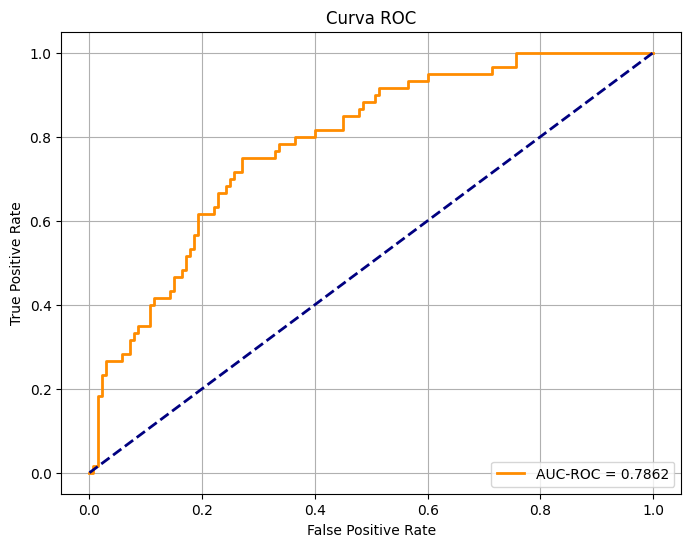

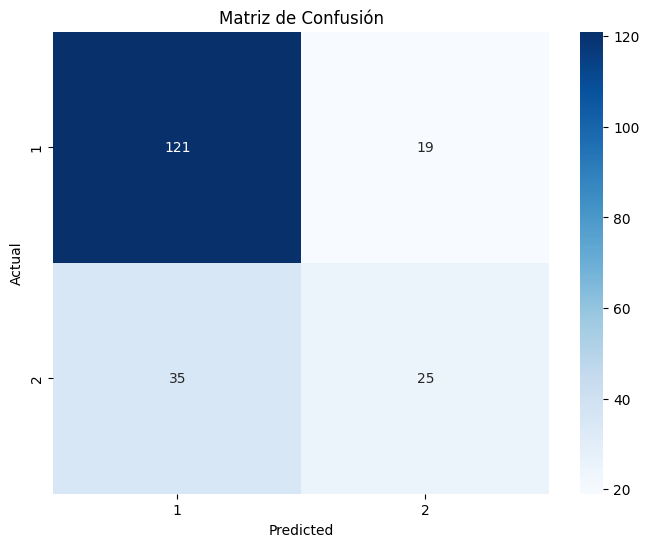


Importancia de los atributos (coeficientes):
                                             Atributo  Coeficiente
10  Credit_history_critical account/ other credits...    -1.783392
34               Other_debtors_/_guarantors_guarantor    -1.639755
9   Status_of_existing_checking_account_no checkin...    -1.571926
23               Savings_account/bonds_... >= 1000 DM    -1.352901
47                                 foreign_worker_yes     1.314602
15                                 Purpose_car (used)    -1.005772
17                                  Purpose_education     0.986631
11     Credit_history_delay in paying off in the past    -0.953442
42                                       Housing_rent     0.942711
26  Savings_account/bonds_unknown/ no savings account    -0.926760
35                    Other_debtors_/_guarantors_none    -0.895305
7   Status_of_existing_checking_account_... >= 200 DM    -0.891568
29        Present_employment_since_4 <= ... < 7 years    -0.830756
16              

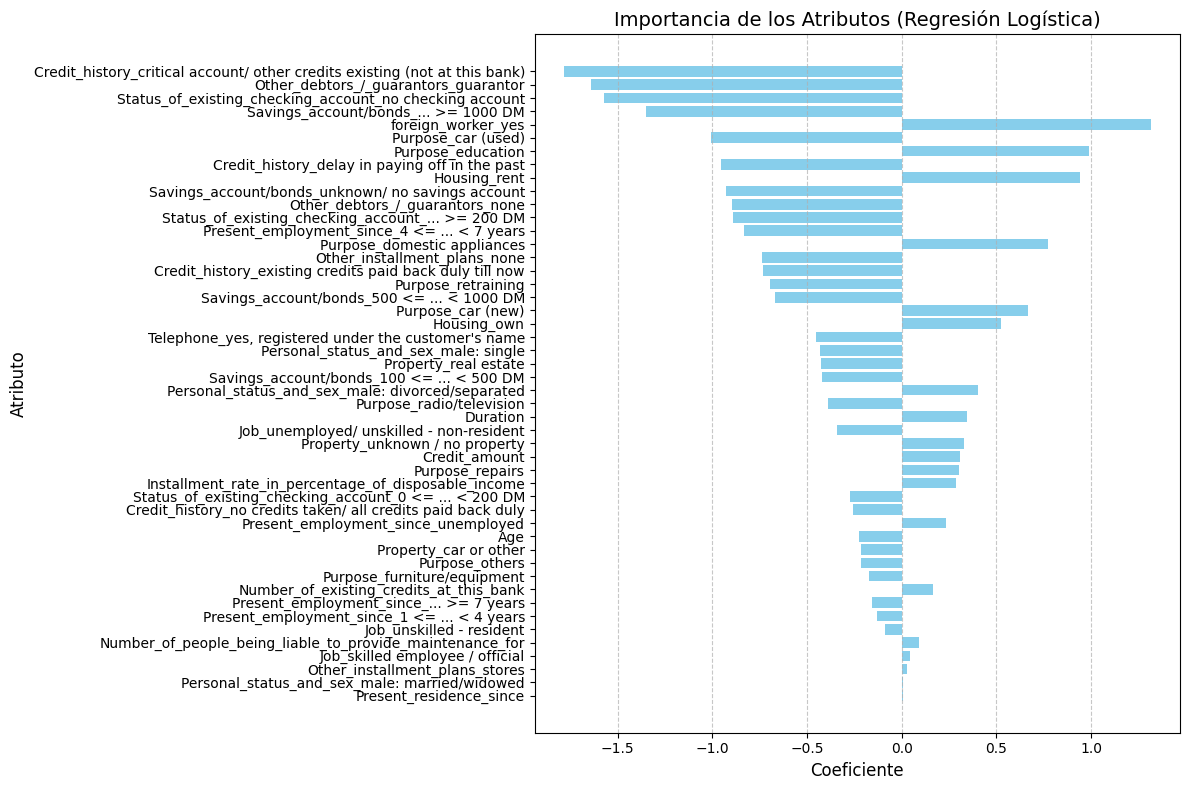

In [52]:
# Configuración de hiperparámetros para la Regresión Logística
param_grid_lr = [
    {
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["l1"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "saga"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["saga"],
        "l1_ratio": [0.5],
        "max_iter": [500, 1000],
    },
]

# Búsqueda en malla para Regresión Logística
print("Ajustando hiperparámetros para Regresión Logística...")
model_lr = LogisticRegression(random_state=random)
grid_search_lr = GridSearchCV(
    model_lr, 
    param_grid_lr, 
    cv=cv, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    verbose=0
)
grid_search_lr.fit(X_train_transformed, y_train)

# Mejor modelo y evaluación
best_lr = grid_search_lr.best_estimator_
print(f"Mejores hiperparámetros para Regresión Logística: {grid_search_lr.best_params_}")
print(f"Balanced Accuracy promedio en validación cruzada: {grid_search_lr.best_score_:.4f}")

# Evaluación en el conjunto de prueba
y_pred_lr = best_lr.predict(X_test_transformed)
y_pred_prob = best_lr.predict_proba(X_test_transformed)[:, 1]  # Probabilidad de la clase positiva

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_lr)
balanced_acc = balanced_accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, pos_label=2)
precision_class_1 = precision_score(y_test, y_pred_lr, pos_label=1)
precision_class_2 = precision_score(y_test, y_pred_lr, pos_label=2)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nRegresión Logística:")
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")
print(f"Balanced Accuracy en el conjunto de prueba: {balanced_acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision Clase 1: {precision_class_1:.4f}")
print(f"Precision Clase 2: {precision_class_2:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr))

# Visualización de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC-ROC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Visualización de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2], yticklabels=[1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

# Análisis de la importancia de los atributos
print("\nImportancia de los atributos (coeficientes):")
coefficients = best_lr.coef_[0]  # Coeficientes para la primera clase (logística binaria)
features = X_train_transformed_df.columns  
coef_df = pd.DataFrame({"Atributo": features, "Coeficiente": coefficients})
coef_df = coef_df.sort_values(by="Coeficiente", key=abs, ascending=False)
print(coef_df)

# Visualización de los coeficientes
plt.figure(figsize=(12, 8)) 
plt.barh(coef_df["Atributo"], coef_df["Coeficiente"], color="skyblue")
plt.xlabel("Coeficiente", fontsize=12)
plt.ylabel("Atributo", fontsize=12)
plt.title("Importancia de los Atributos (Regresión Logística)", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()  
plt.show()



El modelo de Regresión Logística, optimizado con los mejores hiperparámetros, obtuvo un accuracy del 73.50 % en el conjunto de prueba, lo que indica un desempeño global moderado. Sin embargo, el análisis por clase revela una notable disparidad en el rendimiento. La clase mayoritaria (1) tiene un recall del 87 % y un F1-Score de 0.82, lo que demuestra que el modelo identifica con alta precisión a los clientes que no deberían recibir un préstamo. Por otro lado, la clase minoritaria (2) presenta un recall del 42 % y un F1-Score de 0.49, reflejando dificultades para clasificar correctamente a los clientes que deberían recibir un préstamo.

El AUC-ROC de 0.7514 sugiere que el modelo tiene una capacidad moderada para distinguir entre ambas clases, aunque persisten problemas en la identificación de la clase minoritaria. La matriz de confusión confirma que 35 clientes de la clase 2 fueron clasificados incorrectamente como no aptos (falsos negativos), mientras que 18 clientes de la clase 1 fueron clasificados erróneamente como aptos (falsos positivos).

## LDA

Linear Discriminant Analysis (LDA):
Accuracy: 0.7450
Balanced Accuracy: 0.6607
F1-Score: 0.5143
AUC-ROC: 0.7900

Matriz de confusión:
[[122  18]
 [ 33  27]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.79      0.87      0.83       140
           2       0.60      0.45      0.51        60

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200


Importancia de los atributos (coeficientes):
                                             Atributo  Coeficiente
10  Credit_history_critical account/ other credits...    -1.997319
34               Other_debtors_/_guarantors_guarantor    -1.810935
9   Status_of_existing_checking_account_no checkin...    -1.693888
11     Credit_history_delay in paying off in the past    -1.325346
7   Status_of_existing_checking_account_... >= 200 DM    -1.142877
47                                 foreig

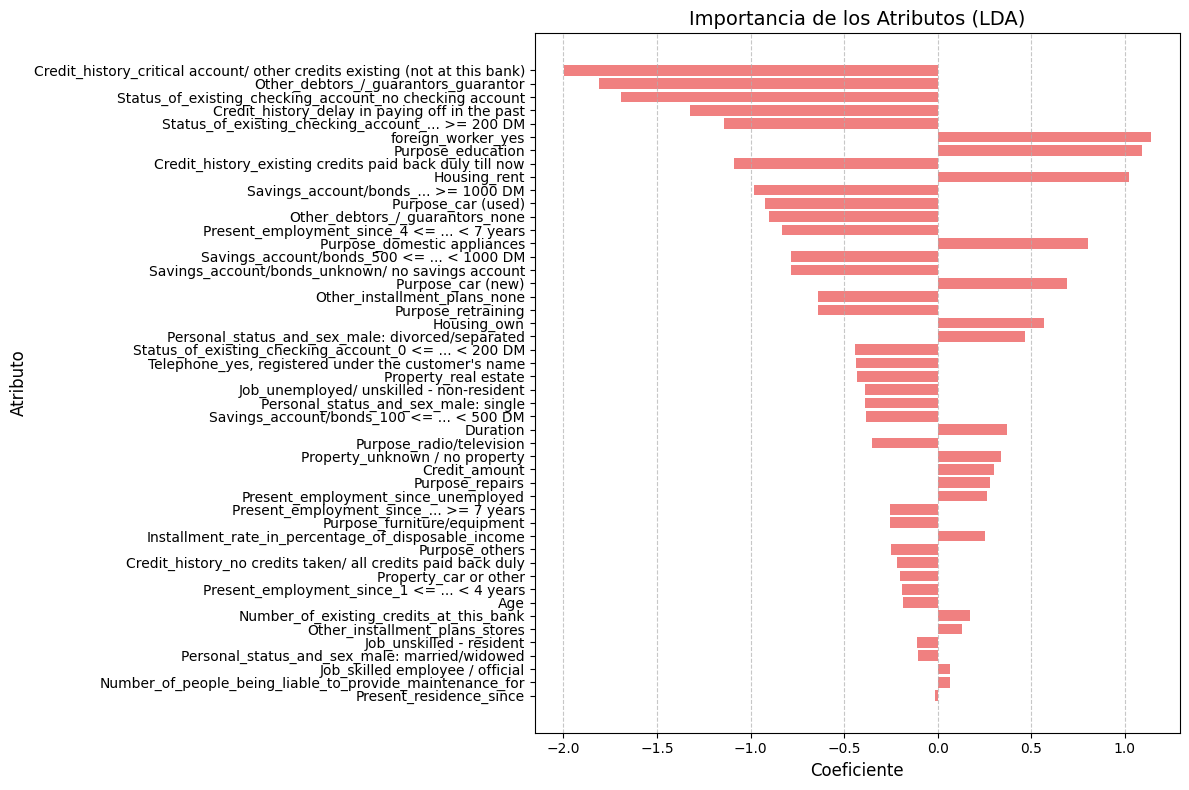

In [ ]:

# Ajustar el modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_transformed, y_train)

# Predicción en el conjunto de prueba
y_pred_lda = lda.predict(X_test_transformed)
y_proba_lda = lda.predict_proba(X_test_transformed)[:, 1]  # Probabilidad para la clase positiva

# Evaluación del modelo LDA
accuracy_lda = accuracy_score(y_test, y_pred_lda)
balanced_acc_lda = balanced_accuracy_score(y_test, y_pred_lda)  # Balanced Accuracy
f1_lda = classification_report(y_test, y_pred_lda, output_dict=True)["2"]["f1-score"]
auc_roc_lda = roc_auc_score(y_test, y_proba_lda)

# Imprimir resultados
print("Linear Discriminant Analysis (LDA):")
print(f"Accuracy: {accuracy_lda:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lda:.4f}")
print(f"F1-Score: {f1_lda:.4f}")
print(f"AUC-ROC: {auc_roc_lda:.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_lda))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lda))

# Análisis de la importancia de los atributos
print("\nImportancia de los atributos (coeficientes):")
lda_coefficients = lda.coef_[0]  # Coeficientes lineales para la proyección
features = X_train_transformed_df.columns  # Nombres de las columnas
coef_df_lda = pd.DataFrame({"Atributo": features, "Coeficiente": lda_coefficients})
coef_df_lda = coef_df_lda.sort_values(by="Coeficiente", key=abs, ascending=False)
print(coef_df_lda)

# Visualización de los coeficientes
plt.figure(figsize=(12, 8))  # Tamaño más grande para evitar solapamientos
plt.barh(coef_df_lda["Atributo"], coef_df_lda["Coeficiente"], color="lightcoral")
plt.xlabel("Coeficiente", fontsize=12)
plt.ylabel("Atributo", fontsize=12)
plt.title("Importancia de los Atributos (LDA)", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar automáticamente los espacios
plt.show()


El modelo de Análisis Discriminante Lineal (LDA) alcanzó un accuracy de 72.50 %, un resultado ligeramente inferior al de la Regresión Logística. Similarmente, el modelo muestra un desempeño desigual entre las clases. Para la clase mayoritaria (1), el recall fue del 86 %, mientras que para la clase minoritaria (2), este valor fue de solo 42 %. Esto se traduce en un F1-Score de 0.81 para la clase 1 y de 0.48 para la clase 2.

El AUC-ROC de 0.7492 es comparable al de la Regresión Logística, lo que indica que el modelo también tiene una capacidad moderada para distinguir entre ambas clases. La matriz de confusión revela que el modelo clasificó incorrectamente a 35 clientes de la clase 2 como no aptos (falsos negativos) y a 20 clientes de la clase 1 como aptos (falsos positivos). Estos resultados sugieren que LDA, al igual que la Regresión Logística, enfrenta desafíos significativos para identificar correctamente la clase minoritaria, probablemente debido a su enfoque lineal y el desbalance en los datos.

## QDA

Realizando búsqueda de hiperparámetros para QDA...
Mejor reg_param: {'reg_param': np.float64(0.05)}
Mejor balanced_accuracy en validación: 0.6720

Quadratic Discriminant Analysis (QDA):
Accuracy en el conjunto de prueba: 0.6900
Balanced Accuracy en el conjunto de prueba: 0.6262
F1-Score: 0.4746
AUC-ROC: 0.7494

Matriz de confusión:
[[110  30]
 [ 32  28]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.77      0.79      0.78       140
           2       0.48      0.47      0.47        60

    accuracy                           0.69       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.69      0.69      0.69       200



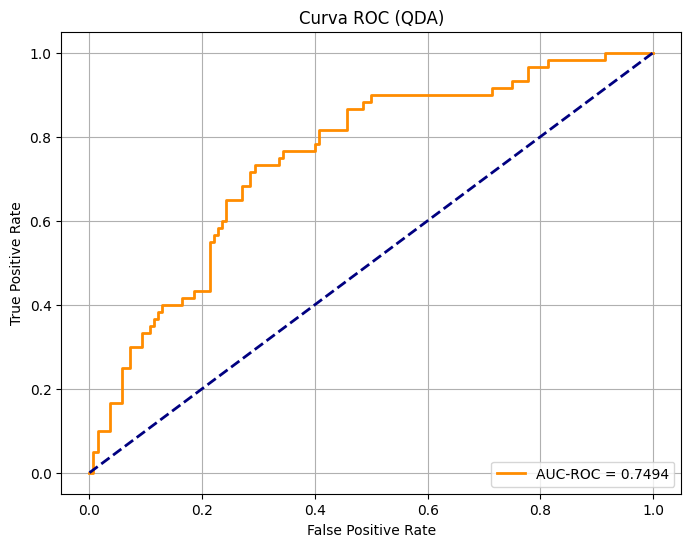

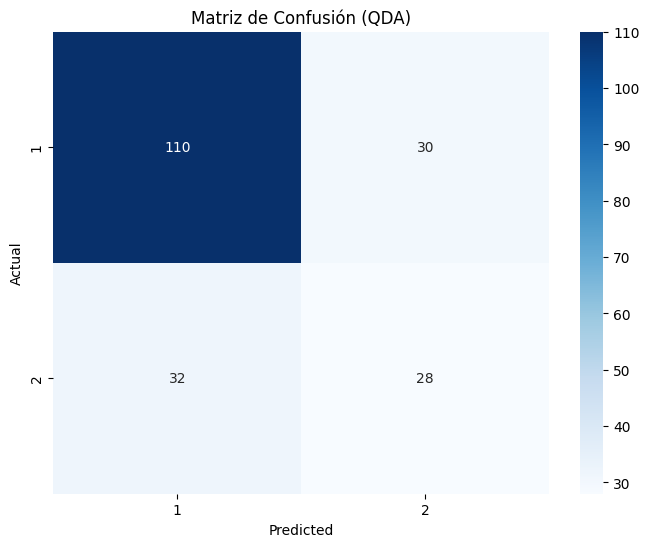


Análisis de la importancia de los atributos (medias por clase):
         Duration  Credit_amount  \
Clase 1 -0.139037      -0.098868   
Clase 2  0.324421       0.230692   

         Installment_rate_in_percentage_of_disposable_income  \
Clase 1                                          -0.036221     
Clase 2                                           0.084516     

         Present_residence_since       Age  \
Clase 1                 0.011109  0.074081   
Clase 2                -0.025922 -0.172855   

         Number_of_existing_credits_at_this_bank  \
Clase 1                                 0.024836   
Clase 2                                -0.057951   

         Number_of_people_being_liable_to_provide_maintenance_for  \
Clase 1                                           0.007697          
Clase 2                                          -0.017961          

         Status_of_existing_checking_account_... >= 200 DM  \
Clase 1                                           0.071429   
Clase

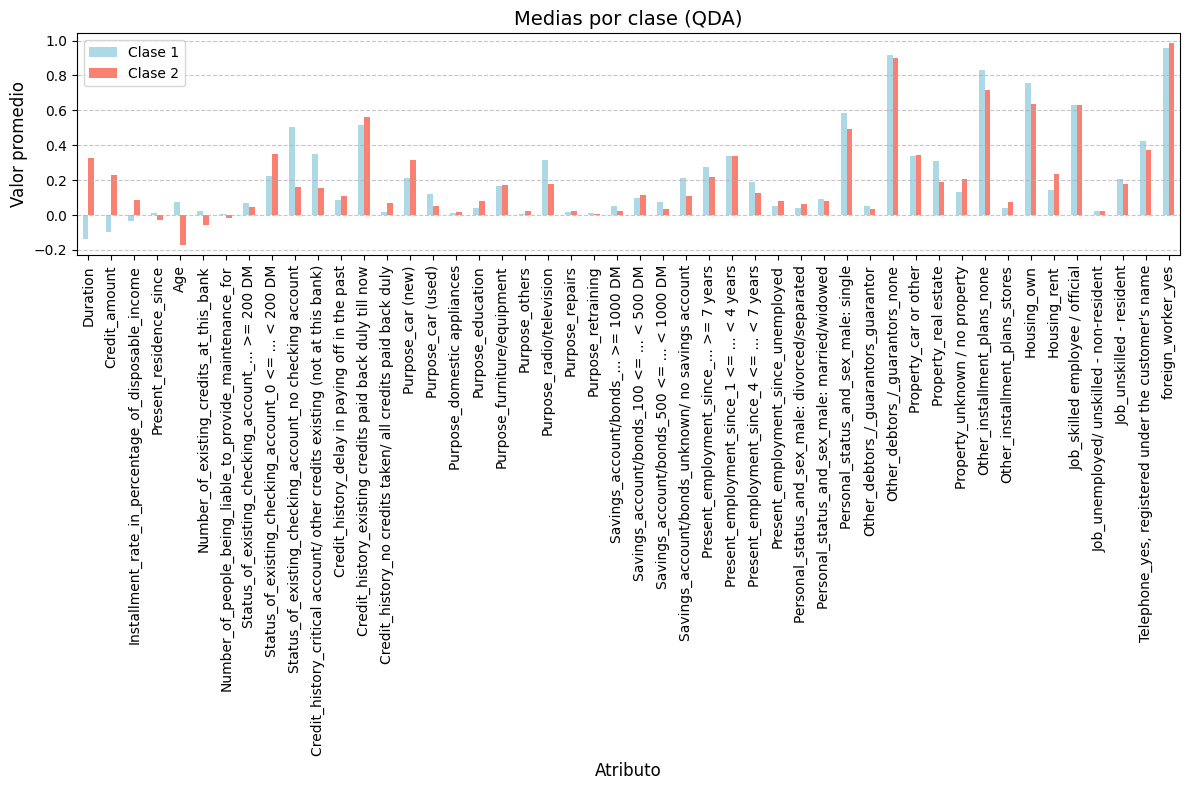


Calculando varianzas aproximadas dentro de cada clase...
                                                     Clase 1   Clase 2  \
Credit_amount                                       0.692370  1.651543   
Duration                                            0.863727  1.176114   
Present_residence_since                             1.005466  0.994621   
Number_of_people_being_liable_to_provide_mainte...  1.015649  0.971305   
Installment_rate_in_percentage_of_disposable_in...  1.013693  0.966095   
Number_of_existing_credits_at_this_bank             1.026900  0.940633   
Age                                                 1.035096  0.883420   
Credit_history_existing credits paid back duly ...  0.250243  0.247123   
Personal_status_and_sex_male: single                0.243087  0.250976   
Telephone_yes, registered under the customer's ...  0.244812  0.234292   
Job_skilled employee / official                     0.233424  0.234292   
Property_car or other                               0.

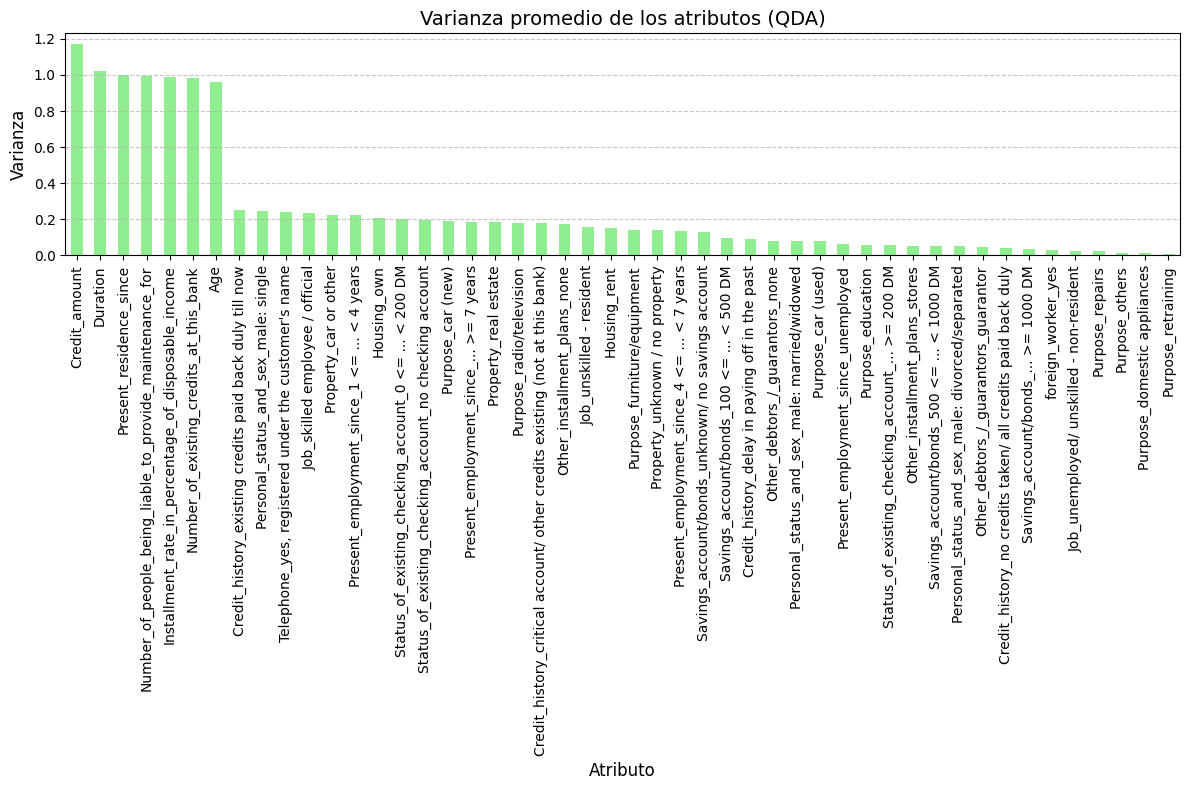

In [54]:
qda = QuadraticDiscriminantAnalysis()

# Definir la rejilla de hiperparámetros para reg_param
param_grid_qda = {'reg_param': np.linspace(0, 1, 21, endpoint=True)}

# Realizar la búsqueda en malla
print("Realizando búsqueda de hiperparámetros para QDA...")
grid_search_qda = GridSearchCV(
    qda, param_grid_qda, cv=5, scoring='balanced_accuracy', n_jobs=-1
)
grid_search_qda.fit(X_train_transformed, y_train)

# Obtener los mejores hiperparámetros
best_qda = grid_search_qda.best_estimator_
print(f"Mejor reg_param: {grid_search_qda.best_params_}")
print(f"Mejor balanced_accuracy en validación: {grid_search_qda.best_score_:.4f}")

# Evaluar el modelo ajustado en el conjunto de prueba
y_pred_qda = best_qda.predict(X_test_transformed)
y_pred_prob_qda = best_qda.predict_proba(X_test_transformed)[:, 1]

# Calcular métricas
accuracy_qda = accuracy_score(y_test, y_pred_qda)
balanced_acc_qda = balanced_accuracy_score(y_test, y_pred_qda)
f1_qda = f1_score(y_test, y_pred_qda, pos_label=2)
roc_auc_qda = roc_auc_score(y_test, y_pred_prob_qda)

print("\nQuadratic Discriminant Analysis (QDA):")
print(f"Accuracy en el conjunto de prueba: {accuracy_qda:.4f}")
print(f"Balanced Accuracy en el conjunto de prueba: {balanced_acc_qda:.4f}")
print(f"F1-Score: {f1_qda:.4f}")
print(f"AUC-ROC: {roc_auc_qda:.4f}")

# Matriz de confusión
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
print("\nMatriz de confusión:")
print(conf_matrix_qda)

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_qda))

# Visualización de la curva ROC
fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test, y_pred_prob_qda, pos_label=2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_qda, tpr_qda, color="darkorange", lw=2, label=f"AUC-ROC = {roc_auc_qda:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (QDA)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2], yticklabels=[1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión (QDA)")
plt.show()

# Análisis de la importancia de los atributos (medias por clase)
print("\nAnálisis de la importancia de los atributos (medias por clase):")
means = pd.DataFrame(best_qda.means_, columns=X_train_transformed_df.columns, index=["Clase 1", "Clase 2"])
print(means)

# Visualización de las medias por clase
means.T.plot(kind="bar", figsize=(12, 8), color=["lightblue", "salmon"])
plt.title("Medias por clase (QDA)", fontsize=14)
plt.ylabel("Valor promedio", fontsize=12)
plt.xlabel("Atributo", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Varianza aproximada de los atributos dentro de cada clase
print("\nCalculando varianzas aproximadas dentro de cada clase...")
var_class_1 = X_train_transformed_df[y_train == 1].var(axis=0)
var_class_2 = X_train_transformed_df[y_train == 2].var(axis=0)

# Crear un DataFrame con las varianzas
variances_df = pd.DataFrame({
    "Clase 1": var_class_1,
    "Clase 2": var_class_2
})
variances_df["Promedio"] = variances_df.mean(axis=1)
variances_df = variances_df.sort_values(by="Promedio", ascending=False)
print(variances_df)

# Visualización de las varianzas
variances_df["Promedio"].plot(kind="bar", figsize=(12, 8), color="lightgreen")
plt.title("Varianza promedio de los atributos (QDA)", fontsize=14)
plt.ylabel("Varianza", fontsize=12)
plt.xlabel("Atributo", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# **Análisis de Resultados**

Los tres modelos (**Regresión Logística**, **LDA**, y **QDA**) presentan resultados variados en términos de desempeño global (**accuracy**, **balanced accuracy**, **f1-score**, y **AUC-ROC**) y en la importancia de los atributos. A continuación, el análisis detallado:

---

## **1. Regresión Logística**

- **Accuracy**: **0.7300**.  
- **Balanced Accuracy**: **0.6405** 
- **Clase 1**:  
  - **Precision**: **0.78** → Buen manejo de falsos positivos.  
  - **Recall**: **0.86** → Alta detección de ejemplos positivos.  
  - **F1-score**: **0.82** → Balance robusto entre precision y recall.  
- **Clase 2**:  
  - **Precision**: **0.57** → Moderada capacidad para evitar falsos positivos.  
  - **Recall**: **0.42** → Baja detección de ejemplos en la clase minoritaria.  
  - **F1-score**: **0.48** → Limitado debido al bajo recall.  
- **AUC-ROC**: **0.7862** → Buena discriminación entre clases.  

### **Importancia de los Atributos**
- **Más relevantes (positivos)**:
  - `foreign_worker_yes` (**1.31**): Ser un trabajador extranjero incrementa la probabilidad de pertenecer a la clase 2.  
  - `Purpose_education` (**0.99**): Créditos para educación están asociados a la clase 2.  
- **Más relevantes (negativos)**:
  - `Credit_history_critical account` (**-1.78**): Historial crítico reduce la probabilidad de pertenecer a la clase 2.  
  - `Other_debtors_guarantor` (**-1.64**): Tener un garante favorece la clase 1.  

### **Comentario**
- La Regresión Logística se basa principalmente en **historial crediticio**, **estado laboral**, y **propósito del crédito**.  
- Tiene buen desempeño en la **clase mayoritaria**, pero enfrenta dificultades significativas en la **clase minoritaria**.

---

## **2. Linear Discriminant Analysis (LDA)**

- **Accuracy**: **0.7450**.  
- **Balanced Accuracy**: **0.6607** → Mejor balance general entre clases.  
- **Clase 1**:  
  - **Precision**: **0.79** → Buen manejo de falsos positivos.  
  - **Recall**: **0.87** → La mejor detección de ejemplos positivos entre los modelos.  
  - **F1-score**: **0.83** → Excelente desempeño global.  
- **Clase 2**:  
  - **Precision**: **0.60** → Mejor que los otros modelos.  
  - **Recall**: **0.45** → Supera a RL y comparable a QDA.  
  - **F1-score**: **0.51** → El mejor para esta clase.  
- **AUC-ROC**: **0.7900** → Buena separación entre clases.  

### **Importancia de los Atributos**
- **Más relevantes (negativos)**:
  - `Credit_history_critical account` (**-1.99**): Historial crítico reduce la probabilidad de pertenecer a la clase 2.  
  - `Other_debtors_guarantor` (**-1.81**): Tener un garante favorece la clase 1.  
- **Más relevantes (positivos)**:
  - `foreign_worker_yes` (**0.95**): Ser un trabajador extranjero aumenta la probabilidad de no recibir crédito.  

### **Comentario**
- LDA se destaca como el modelo más balanceado, con mejor desempeño en ambas clases, especialmente en la **clase minoritaria**.

---

## **3. Quadratic Discriminant Analysis (QDA)**

- **Accuracy**: **0.6900**.  
- **Balanced Accuracy**: **0.6262**  
- **Clase 1**:  
  - **Precision**: **0.77** → Consistente.  
  - **Recall**: **0.79** → Buen desempeño.  
  - **F1-score**: **0.78** → Competitivo.  
- **Clase 2**:  
  - **Precision**: **0.48** → Limitada capacidad para evitar falsos positivos.  
  - **Recall**: **0.47** → Moderado.  
  - **F1-score**: **0.47** → Similar a RL.  
- **AUC-ROC**: **0.7494** → Discriminación moderada entre clases.  

### **Importancia de los Atributos**
Los atributos más relevantes se analizan mediante diferencias en medias y varianzas entre clases:
- **Diferencias significativas en medias**:
  - `Duration` y `Credit_amount` → Valores más altos en la clase 2.  



---

## **4. Análisis Global**

### **Clase mayoritaria (1 = "good"):**
- Todos los modelos tienen buen desempeño, con **LDA** mostrando el mejor recall (**0.87**) y f1-score (**0.83**).  
- **Regresión Logística** y **QDA** ofrecen precisión competitiva, pero su recall es menor.

### **Clase minoritaria (2 = "bad"):**
- **LDA** destaca por su mejor desempeño en **recall** (**0.45**) y **f1-score** (**0.51**).  
- **QDA** tiene un desempeño intermedio en recall (**0.47**), superando a Regresión Logística (**0.42**).  
- **Regresión Logística** es el más limitado en esta clase.

### **Importancia de los Atributos (General)**
- **`Credit_history_critical account`**: Identificado como el atributo más importante en los tres modelos, con un impacto negativo en la clase 2.  
- **`foreign_worker_yes`**: Destaca en RL y LDA como un factor positivo asociado a la clase 2.  
- **`Duration` y `Credit_amount`**: Relevantes en QDA por sus diferencias en medias y varianzas entre clases.  

---

## **Modelo recomendado**
- **LDA** es la opción preferida por su balance y desempeño en ambas clases, especialmente en la **clase minoritaria**.  
- **QDA** es útil en escenarios donde las relaciones no lineales sean significativas.  
- **Regresión Logística** es adecuada para maximizar el desempeño en la **clase mayoritaria**, pero muestra mas limitaciones en la clase minoritaria.



## Métodos No Lineales

En este apartado usaremos métodos no lineales para intentar predecir los valores, nosotros vamos a escoger SVC con kernel RBF, Random Forest y GradientBoostingClassifier.
Como nuestros datos estan desbalanceados en relación a la variable objetivo la métrica que utilizaremos en los modelos será balanced_accuracy ya que esta da igual importancia a las clases mayoritarias y minoritarias y penaliza los modelos que ignoran la clase minoritaria.

In [55]:
# 1) SVM con kernel RBF
svm = SVC(kernel='rbf', probability=True, random_state=random)  # probability=True para obtener probabilidades (para ROC)
param_svm = {
    'C': 10**np.linspace(-3, 3, 101),          
    'gamma': [0.001, 0.01, 0.1, 1],              
    'degree': [2, 3, 4],                        
    'class_weight': [None, 'balanced'],       
    'shrinking': [True, False],
}

# 2) Random Forest
rf = RandomForestClassifier(random_state=random)
param_rf = {
    'n_estimators': [5,10,25,40, 50, 75,100, 200], 
    'criterion':['gini', 'entropy'], 
    'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
    'min_samples_leaf':[1,2,3,5,10],
    'class_weight': [None, 'balanced']
}

# 3) Gradient Boosting
gb = GradientBoostingClassifier(random_state=random)
param_gb = {
    'n_estimators': [25, 50, 75, 100], 
    'loss':['log_loss', 'exponential'], 
    'criterion':['friedman_mse', 'squared_error'], 
    'max_depth':[None, 2, 5, 8, 10, 15],
    'min_samples_leaf':[1,2,3,5,10], 
    'learning_rate':[0.1, 1, 10]
}

# GridSearchCV para SVM
grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_svm,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# GridSearchCV para Random Forest
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_rf,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# GridSearchCV para Gradient Boosting
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_gb,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)



In [56]:
grid_svm.fit(X_train_transformed, y_train)
grid_rf.fit(X_train_transformed, y_train)
grid_gb.fit(X_train_transformed, y_train)

# Extraer los mejores modelos (ya entrenados con sus mejores hiperparámetros)
best_svm = grid_svm.best_estimator_
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

print("Mejores hiperparámetros para SVM:", grid_svm.best_params_)
print("Mejor score de validación cruzada para SVM:", grid_svm.best_score_)

print("\nMejores hiperparámetros para Random Forest:", grid_rf.best_params_)
print("Mejor score de validación cruzada para Random Forest:", grid_rf.best_score_)

print("\nMejores hiperparámetros para Gradient Boosting:", grid_gb.best_params_)
print("Mejor score de validación cruzada para Gradient Boosting:", grid_gb.best_score_)


# Predicciones
y_pred_svm = best_svm.predict(X_test_transformed)
y_pred_rf = best_rf.predict(X_test_transformed)
y_pred_gb = best_gb.predict(X_test_transformed)


# Métricas de clasificación (accuracy, precision, recall, f1, balanced accuracy)
print("=== SVM (RBF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

print("\n=== Gradient Boosting ===")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))



Mejores hiperparámetros para SVM: {'C': np.float64(12.02264434617413), 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.01, 'shrinking': True}
Mejor score de validación cruzada para SVM: 0.7321428571428571

Mejores hiperparámetros para Random Forest: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 100}
Mejor score de validación cruzada para Random Forest: 0.725

Mejores hiperparámetros para Gradient Boosting: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Mejor score de validación cruzada para Gradient Boosting: 0.7071428571428571
=== SVM (RBF) ===
Accuracy: 0.715
Balanced Accuracy: 0.7107142857142856
              precision    recall  f1-score   support

           1       0.85      0.72      0.78       140
           2       0.52      0.70      0.60        60

    accuracy                           0.71       200
   macro avg       0.68   

Rango de y_prob_svm: 0.0 1.0
Rango de y_prob_rf: 0.09116407376986516 0.748737500430238
Rango de y_prob_gb: 0.002938980047153688 0.9754934064032201

ROC AUC Scores:
SVM (RBF): 0.7766666666666667
Random Forest: 0.7538095238095238
Gradient Boosting: 0.7679761904761905


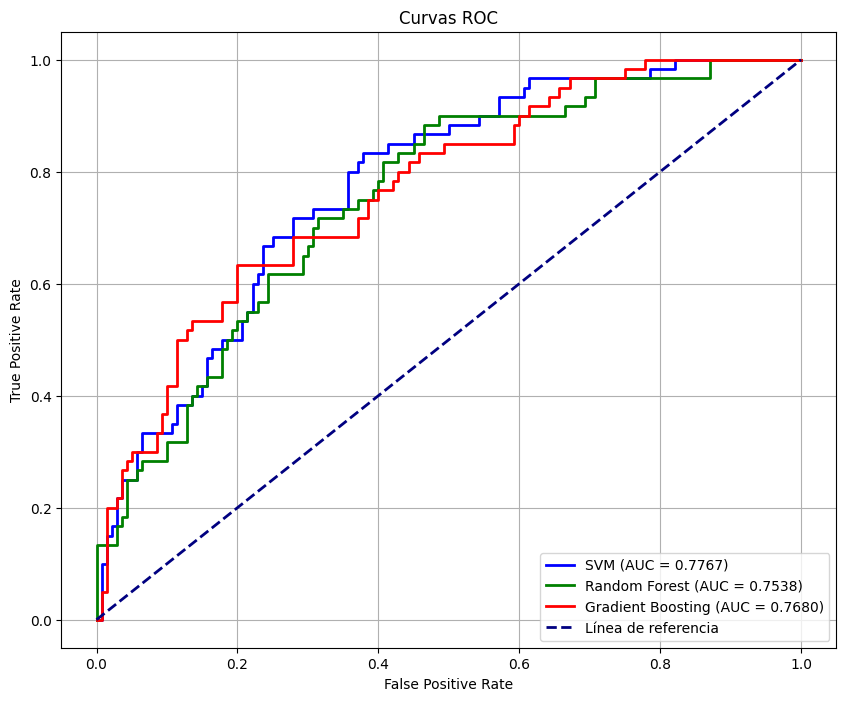

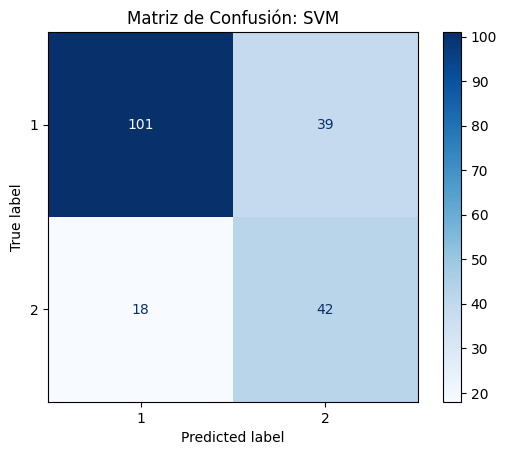

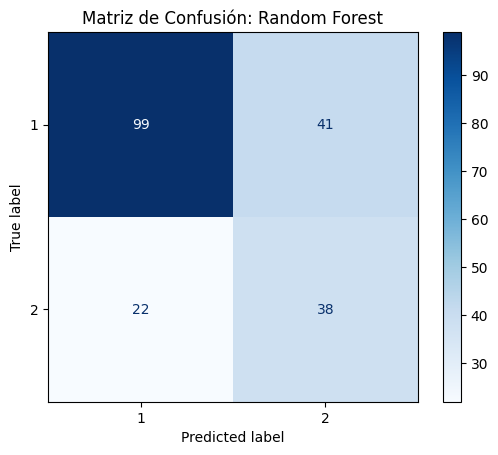

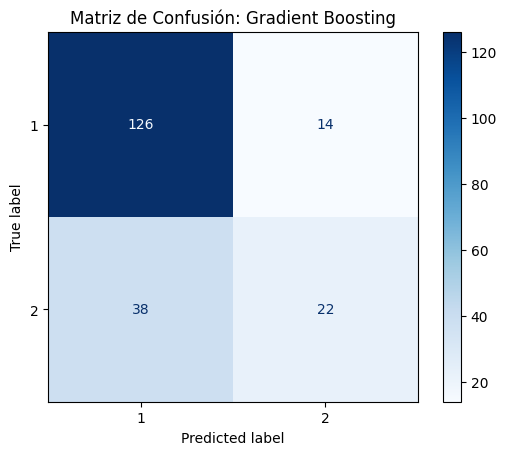

In [57]:

# Calcular probabilidades o puntajes de decisión para el ROC AUC
y_prob_svm = best_svm.decision_function(X_test_transformed)
y_prob_rf = best_rf.predict_proba(X_test_transformed)[:, 1]
y_prob_gb = best_gb.predict_proba(X_test_transformed)[:, 1]

# Escalar decision_function al rango [0, 1]
y_prob_svm = MinMaxScaler().fit_transform(y_prob_svm.reshape(-1, 1)).ravel()

# Calcular ROC AUC
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

# Comprobar rangos en predicciones probabilísticas
print("Rango de y_prob_svm:", y_prob_svm.min(), y_prob_svm.max())
print("Rango de y_prob_rf:", y_prob_rf.min(), y_prob_rf.max())
print("Rango de y_prob_gb:", y_prob_gb.min(), y_prob_gb.max())

print("\nROC AUC Scores:")
print("SVM (RBF):", roc_auc_svm)
print("Random Forest:", roc_auc_rf)
print("Gradient Boosting:", roc_auc_gb)


# Obtener FPR, TPR y thresholds para cada modelo
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm, pos_label=2)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf, pos_label=2)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb, pos_label=2)

# Graficar las curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color="blue", lw=2, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, color="green", lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr_gb, tpr_gb, color="red", lw=2, label=f"Gradient Boosting (AUC = {roc_auc_gb:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Línea de referencia")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Graficar matrices de confusión
models = {'SVM': y_pred_svm, 'Random Forest': y_pred_rf, 'Gradient Boosting': y_pred_gb}
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión: {model_name}")
    plt.show()





In [64]:
# PERMUTATION IMPORTANCE PARA SVM
perm_result_svm = permutation_importance(
    best_svm,
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=random,
    scoring="balanced_accuracy" 
)

# Procesar los resultados
importances_mean_svm = perm_result_svm.importances_mean
importances_std_svm = perm_result_svm.importances_std

# Ordenar las características por importancia
indices_svm = np.argsort(importances_mean_svm)[::-1]

print("\nPermutation Importance - SVM:")
for idx in indices_svm:
    print(f"Feature {X_train_transformed_df.columns[idx]}: {importances_mean_svm[idx]:.4f} +/- {importances_std_svm[idx]:.4f}")

#PERMUTATION IMPORTANCE PARA RANDOM FOREST

perm_result_rf = permutation_importance(
    best_rf,                 # Modelo entrenado
    X_test_transformed,      # Datos transformados
    y_test,                  # Etiquetas verdaderas
    n_repeats=10,            # Número de repeticiones
    random_state=random,     # Control de aleatoriedad
    scoring="balanced_accuracy"       # Métrica de evaluación
)

# Procesar los resultados
importances_mean_rf = perm_result_rf.importances_mean
importances_std_rf = perm_result_rf.importances_std

# Ordenar las características por importancia
indices_rf = np.argsort(importances_mean_rf)[::-1]

print("\nPermutation Importance - Random Forest:")
for idx in indices_rf:
    print(f"Feature {X_train_transformed_df.columns[idx]}: {importances_mean_rf[idx]:.4f} +/- {importances_std_rf[idx]:.4f}")

# PERMUTATION IMPORTANCE PARA GRADIENT BOOSTING
perm_result_gb = permutation_importance(
    best_gb,
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=random,
    scoring="balanced_accuracy"
)

# Procesar los resultados
importances_mean_gb = perm_result_gb.importances_mean
importances_std_gb = perm_result_gb.importances_std

# Ordenar las características por importancia
indices_gb = np.argsort(importances_mean_gb)[::-1]

print("\nPermutation Importance - Gradient Boosting:")
for idx in indices_gb:
    print(f"Feature {X_train_transformed_df.columns[idx]}: {importances_mean_gb[idx]:.4f} +/- {importances_std_gb[idx]:.4f}")



Permutation Importance - SVM:
Feature Status_of_existing_checking_account_no checking account: 0.0629 +/- 0.0241
Feature Duration: 0.0539 +/- 0.0218
Feature Credit_amount: 0.0331 +/- 0.0146
Feature Job_unskilled - resident: 0.0205 +/- 0.0124
Feature Savings_account/bonds_unknown/ no savings account: 0.0189 +/- 0.0103
Feature Credit_history_critical account/ other credits existing (not at this bank): 0.0161 +/- 0.0191
Feature Present_employment_since_... >= 7 years: 0.0156 +/- 0.0112
Feature Credit_history_existing credits paid back duly till now: 0.0142 +/- 0.0081
Feature Present_employment_since_4 <= ... < 7 years: 0.0137 +/- 0.0089
Feature Number_of_existing_credits_at_this_bank: 0.0107 +/- 0.0091
Feature Other_debtors_/_guarantors_guarantor: 0.0093 +/- 0.0088
Feature Number_of_people_being_liable_to_provide_maintenance_for: 0.0086 +/- 0.0086
Feature Property_real estate: 0.0081 +/- 0.0149
Feature Housing_rent: 0.0075 +/- 0.0053
Feature Savings_account/bonds_... >= 1000 DM: 0.0064 +

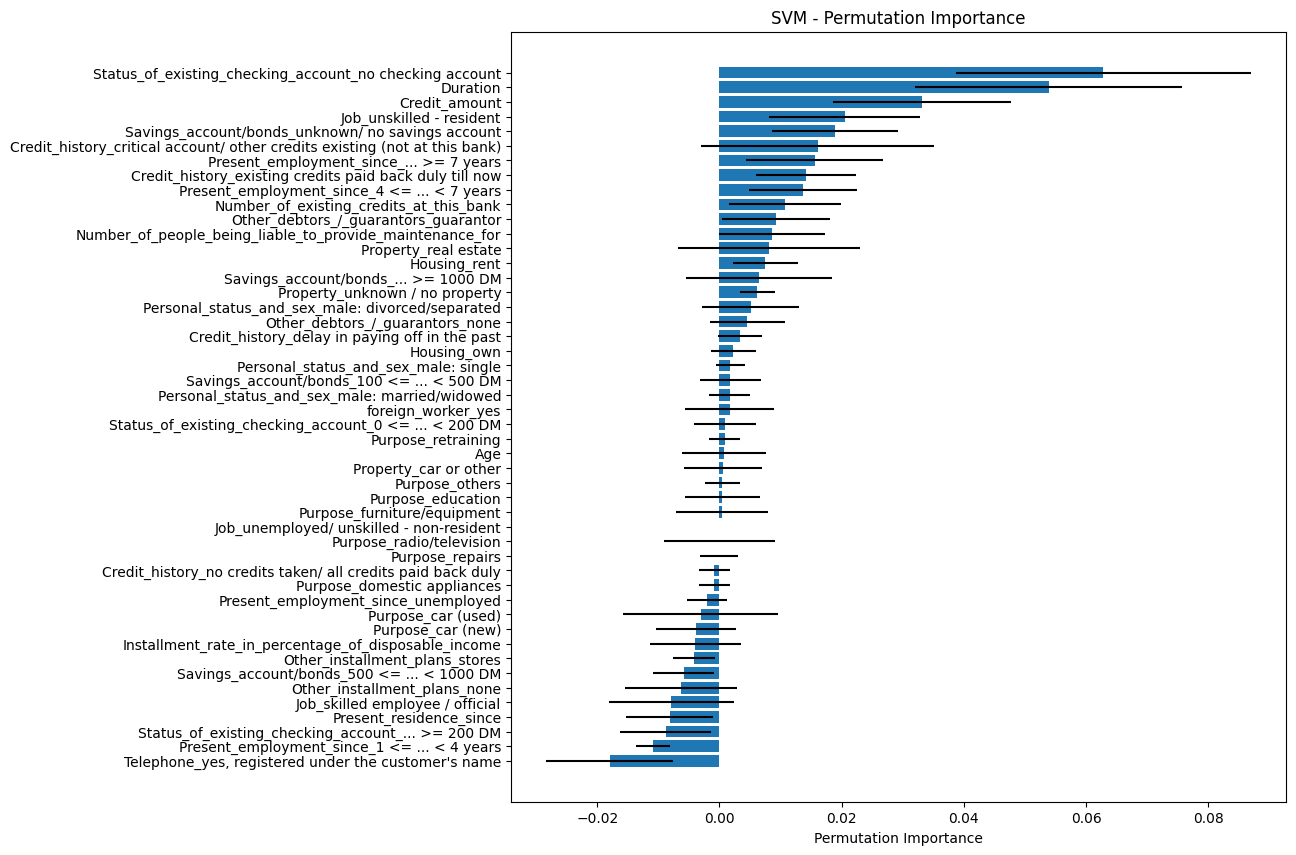

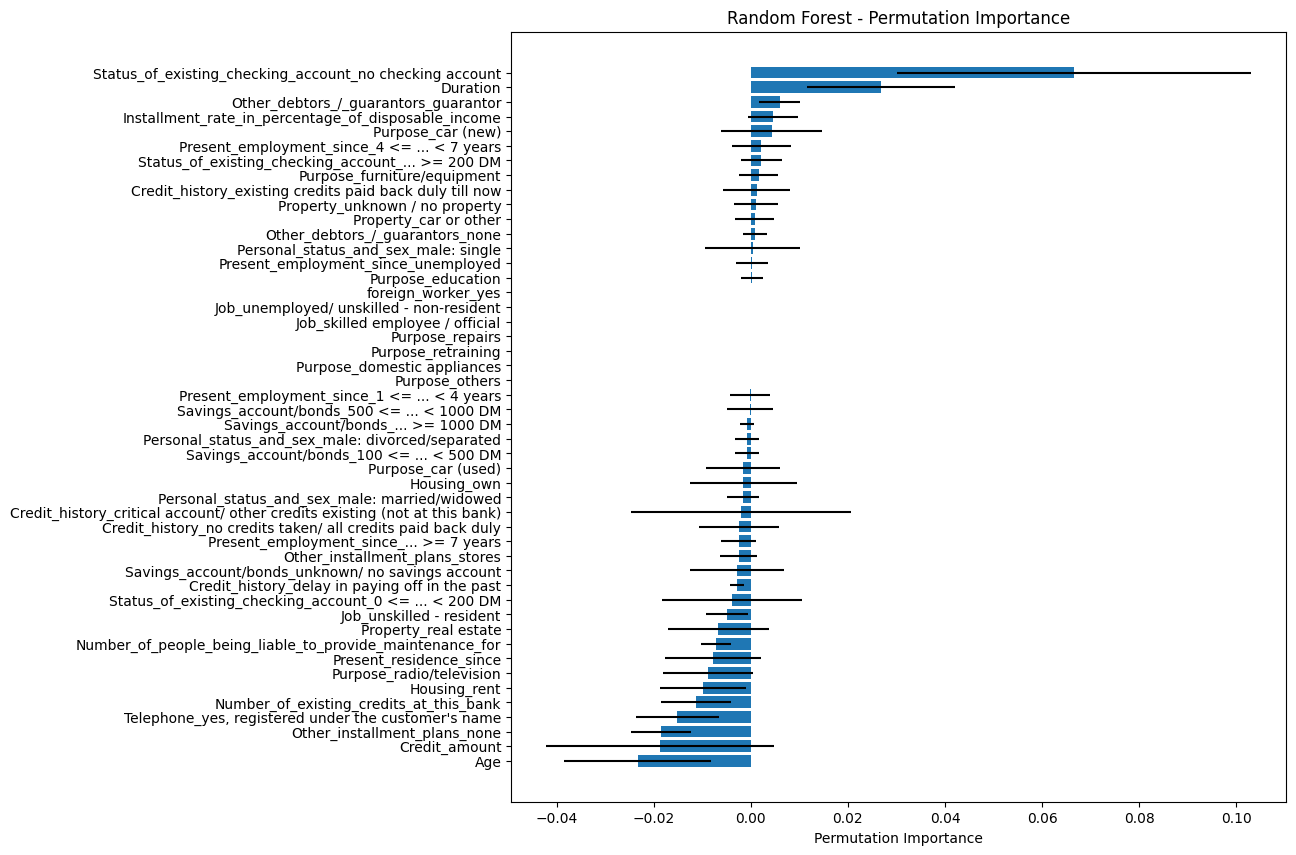

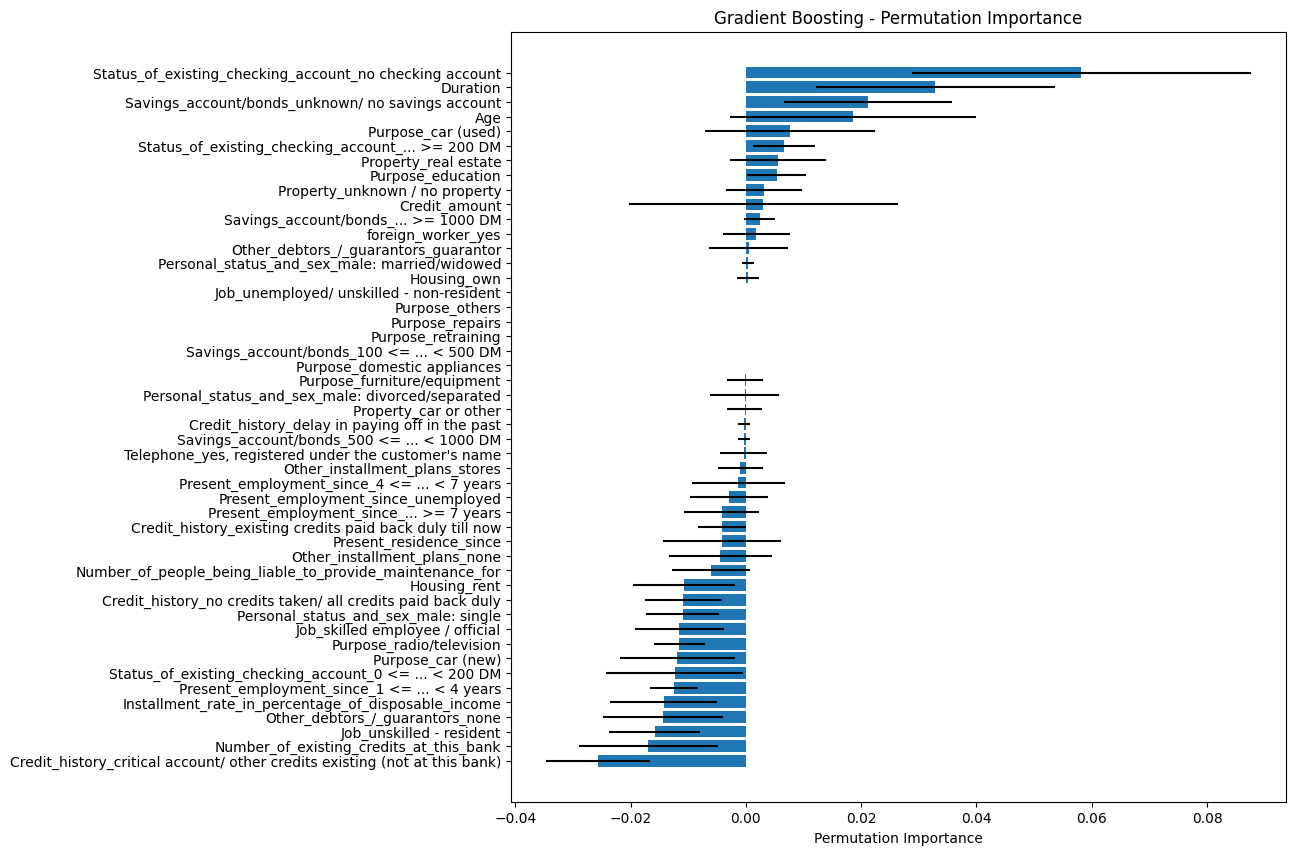

In [65]:
# Visualización de la importancia de las características
# Visualización de Permutation Importance para SVM
plt.figure(figsize=(10, 10))
plt.barh(X_train_transformed_df.columns[indices_svm], importances_mean_svm[indices_svm], xerr=importances_std_svm[indices_svm])
plt.xlabel("Permutation Importance")
plt.title("SVM - Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

# Visualización de Random Forest
plt.figure(figsize=(10, 10))
plt.barh(X_train_transformed_df.columns[indices_rf], importances_mean_rf[indices_rf], xerr=importances_std_rf[indices_rf])
plt.xlabel("Permutation Importance")
plt.title("Random Forest - Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

# Visualización de Gradient Boosting
plt.figure(figsize=(10, 10))
plt.barh(X_train_transformed_df.columns[indices_gb], importances_mean_gb[indices_gb], xerr=importances_std_gb[indices_gb])
plt.xlabel("Permutation Importance")
plt.title("Gradient Boosting - Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

# **Análisis de Resultados**

## **Curvas ROC y AUC**
- **SVM** tiene el mejor AUC (**0.776**), lo que indica un buen balance entre sensibilidad y especificidad.
- **Random Forest** y **Gradient Boosting** tienen AUC similares (**0.753** y **0.751**, respectivamente), pero ligeramente inferiores al de SVM.
- La diferencia en las curvas ROC refleja que **SVM** es más efectivo para separar las clases, mientras que **Random Forest** y **Gradient Boosting** están más equilibrados pero menos precisos.

---

## **Rendimiento en el Conjunto de Prueba**

### **1. SVM (RBF)**
- **Accuracy**: **0.715**
- **Balanced Accuracy**: **0.7107**
- **Clase 1**:
  - **Precision**: 0.85
  - **Recall**: 0.72
  - **F1-Score**: 0.78
- **Clase 2**:
  - **Precision**: 0.52
  - **Recall**: 0.70
  - **F1-Score**: 0.60
- **Comentario**: Maneja bien la clase mayoritaria y tiene un recall razonable para la clase minoritaria gracias al ajuste con `class_weight='balanced'`.

### **2. Random Forest**
- **Accuracy**: **0.685**
- **Balanced Accuracy**: **0.6702**
- **Clase 1**:
  - **Precision**: 0.82
  - **Recall**: 0.71
  - **F1-Score**: 0.76
- **Clase 2**:
  - **Precision**: 0.48
  - **Recall**: 0.63
  - **F1-Score**: 0.55
- **Comentario**: Aunque tiene un buen rendimiento en la clase mayoritaria, no maneja tan bien la minoritaria.

### **3. Gradient Boosting**
- **Accuracy**: **0.73**
- **Balanced Accuracy**: **0.6452**
- **Clase 1**:
  - **Precision**: 0.78
  - **Recall**: 0.86
  - **F1-Score**: 0.82
- **Clase 2**:
  - **Precision**: 0.57
  - **Recall**: 0.43
  - **F1-Score**: 0.49
- **Comentario**: Aunque logra buen desempeño en la clase mayoritaria, tiene dificultades con la clase minoritaria, mostrando un balance menos efectivo que SVM.

## **Conclusiones**
1. **Mejor Modelo General**:
   - **SVM** tiene el mejor desempeño general, equilibrando las métricas de la clase mayoritaria y minoritaria.
   - Tiene el mayor AUC (**0.776**) y buen manejo del desbalance gracias a `class_weight='balanced'`.

2. **Random Forest**:
   - Tiene un rendimiento sólido en la clase mayoritaria pero menos efectivo para la minoritaria.
   - Requiere ajustes para mejorar la sensibilidad (recall) de la clase minoritaria.

3. **Gradient Boosting**:
   - Aunque tiene buen rendimiento en la clase mayoritaria, es el modelo menos efectivo para manejar el desbalance.
